In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


['.gitignore', 'GCP-Coupons-Instructions.rtf', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
with timer('load csv'):
    train = pd.read_csv("../input/train.csv")
    test = pd.read_csv("../input/test.csv")

load csv - done in 102s


**PART 1 --> DATA CLEANSING & EXPLORATORY DATA ANALYSIS (EDA)**

Will perform the following activities
* Shape of train and test sets
* Check for NaNs and drop them (if any)
* Check for outliers and drop them (if any)
* Type conversion of relevant fields

In [3]:
with timer('data cleaning'):
    train = train.drop(train[train.isnull().any(1)].index, axis = 0)
    train = train.drop(train[train['fare_amount']<0].index, axis=0)
    train = train.drop(train[train['passenger_count']>6].index, axis = 0)
    train = train.drop(((train[train['pickup_latitude']<-90])|(train[train['pickup_latitude']>90])).index, axis=0)
    train = train.drop(((train[train['pickup_longitude']<-180])|(train[train['pickup_longitude']>180])).index, axis=0)
    train = train.drop(((train[train['dropoff_latitude']<-90])|(train[train['dropoff_latitude']>90])).index, axis=0)

data cleaning - done in 61s


In [4]:
with timer('deal with datetime'):
    train['key'] = pd.to_datetime(train['key'])
    train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])
    
    test['key'] = pd.to_datetime(test['key'])
    test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

deal with datetime - done in 5651s


Now, for **EDA**. The following are my considerations - 
1. Does the number of passengers affect the fare? 
2. Does the date and time of pickup affect the fare?
3. Does the day of the week affect the fare?
4. Does the distance travelled affect the fare?

First, let's split the datetime field 'pickup_datetime' to the following - 
* year
* month
* date
* hour
* day of week

Using these we shall calculate the day of the week and come to our conclusions about how pickup_location affects the fare.
Also, create a new field 'distance' to fetch the distance between the pickup and the drop.

We can calulate the distance in a sphere when latitudes and longitudes are given by [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

**haversine(θ) = sin²(θ/2)**

Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

**a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)**

**c = 2 * atan2( √a, √(1−a) )**

**d = R ⋅ c**

**d = Haversine distance**

*Refer [this](https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula) page for more info and examples on Haversine formula*

In [5]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [6]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
5        3.222549
6        0.929601
7       21.540102
8        3.873962
9        1.099794
10       2.317685
11       4.819179
12       0.722670
13       1.675503
14       2.504032
15       5.115375
16       0.298838
17       2.531147
18       0.780444
19       0.427282
20       1.651946
21       1.969211
22       1.305441
23       1.901295
24       5.779720
25       1.121687
26      14.306540
27       9.427870
28       1.144529
29       4.696371
          ...    
9884    15.119293
9885     5.006239
9886     7.376754
9887     1.680721
9888     0.000000
9889     2.377723
9890     2.944581
9891     5.952839
9892     2.950361
9893     4.735375
9894     3.101361
9895     9.000325
9896     2.398161
9897     5.081663
9898     0.555287
9899     5.610506
9900     1.890608
9901     1.530118
9902     3.891525
9903     2.299316
9904    15.091263
9905     9.613797
9906     0.369506
9907     9.923999
9908     1

In [7]:
train['H_Distance'].head(10)

0    1.030764
1    8.450134
2    1.389525
3    2.799270
4    1.999157
5    3.787239
6    1.555807
7    4.155444
8    1.253232
9    2.849627
Name: H_Distance, dtype: float64

In [8]:
test['H_Distance'].head(10)

0     2.323260
1     2.425353
2     0.618628
3     1.961033
4     5.387301
5     3.222549
6     0.929601
7    21.540102
8     3.873962
9     1.099794
Name: H_Distance, dtype: float64

In [9]:
train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
5,2011-01-06 09:50:45.000000200,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,3.787239
6,2012-11-20 20:35:00.000000100,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,1.555807
7,2012-01-04 17:22:00.000000810,16.5,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,4.155444
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,1.253232
9,2009-09-02 01:11:00.000000830,8.9,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,2.849627


In [10]:
test.head(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323260
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.425353
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618628
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961033
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.387301
5,2012-12-01 21:12:12.000000500,2012-12-01 21:12:12,-73.960983,40.765547,-73.979177,40.740053,1,3.222549
6,2011-10-06 12:10:20.000000100,2011-10-06 12:10:20,-73.949013,40.773204,-73.959622,40.770893,1,0.929601
7,2011-10-06 12:10:20.000000300,2011-10-06 12:10:20,-73.777282,40.646636,-73.985083,40.759368,1,21.540102
8,2011-10-06 12:10:20.000000200,2011-10-06 12:10:20,-74.014099,40.709638,-73.995106,40.741365,1,3.873962
9,2014-02-18 15:22:20.000000200,2014-02-18 15:22:20,-73.969582,40.765519,-73.980686,40.770725,1,1.099794


Now that we have calculated the distance, we shall create columns for the following - 
* year
* month
* date
* hour
* day of week

In [11]:
with timer('convert datetime'):
    data = [train,test]
    for i in data:
        i['Year'] = i['pickup_datetime'].dt.year
        i['Month'] = i['pickup_datetime'].dt.month
        i['Date'] = i['pickup_datetime'].dt.day
        i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
        i['Hour'] = i['pickup_datetime'].dt.hour

convert datetime - done in 18s


In [12]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009,6,15,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010,1,5,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011,8,18,3,0
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010,3,9,1,7


In [13]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,2015,1,27,1,13
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,2015,1,27,1,13
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,2011,10,8,5,11
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,2012,12,1,5,21
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,2012,12,1,5,21


**4. Does the distance affect the fare?**

This is a no-brainer. I am confident that the distance would affect the fare a great deal. But I will visualise it.

Firstly, let's check the frequency of the distances that we calculated using Haversine formula. I will do so by creating bins (0-10 kms, 10-20 kms, and so on, and check for any outliers)

In [14]:
with timer('make bins'):
    bins_0 = train.loc[(train['H_Distance'] == 0), ['H_Distance']]
    bins_1 = train.loc[(train['H_Distance'] > 0) & (train['H_Distance'] <= 10),['H_Distance']]
    bins_2 = train.loc[(train['H_Distance'] > 10) & (train['H_Distance'] <= 50),['H_Distance']]
    bins_3 = train.loc[(train['H_Distance'] > 50) & (train['H_Distance'] <= 100),['H_Distance']]
    bins_4 = train.loc[(train['H_Distance'] > 100) & (train['H_Distance'] <= 200),['H_Distance']]
    bins_5 = train.loc[(train['H_Distance'] > 200) & (train['H_Distance'] <= 300),['H_Distance']]
    bins_6 = train.loc[(train['H_Distance'] > 300),['H_Distance']]
    bins_0['bins'] = '0'
    bins_1['bins'] = '0-10'
    bins_2['bins'] = '11-50'
    bins_3['bins'] = '51-100'
    bins_4['bins'] = '100-200'
    bins_5['bins'] = '201-300'
    bins_6['bins'] = '>300'
    dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
    #len(dist_bins)
    dist_bins.columns

make bins - done in 11s


In [15]:
train = train.drop(train.loc[((train['pickup_latitude']==0) & (train['pickup_longitude']==0))&((train['dropoff_latitude']!=0) & (train['dropoff_longitude']!=0)) & (train['fare_amount']==0)].index, axis=0)

In [16]:
train = train.drop(train.loc[((train['pickup_latitude']!=0) & (train['pickup_longitude']!=0))&((train['dropoff_latitude']==0) & (train['dropoff_longitude']==0)) & (train['fare_amount']==0)].index, axis=0)

Check the H_Distance fields which are greater than 200 kms cause there is no way that people would travel more than 200 kms at the most in NYC in a CAB!

In [17]:
high_distance = train.loc[(train['H_Distance']>200)&(train['fare_amount']!=0)]

In [18]:
high_distance

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.50,2009-02-22 22:48:00,0.000000,0.000000,-74.005433,40.726685,2,8667.304968,2009,2,22,6,22
1260,2011-03-10 20:25:00.000000490,5.70,2011-03-10 20:25:00,-73.973907,40.754743,0.000000,0.000000,2,8665.268588,2011,3,10,3,20
2280,2011-08-29 08:24:00.000000107,8.90,2011-08-29 08:24:00,-73.936667,40.757815,0.000000,40.757815,1,6026.494216,2011,8,29,0,8
2397,2012-06-24 17:11:10.000000100,45.00,2012-06-24 17:11:10,0.000000,0.000000,-74.010230,40.714553,2,8667.454421,2012,6,24,6,17
4278,2015-04-07 23:33:02.000000500,7.00,2015-04-07 23:33:02,-73.972702,40.757423,0.000000,0.000000,1,8665.223767,2015,4,7,1,23
4597,2010-03-30 07:12:00.000000158,6.90,2010-03-30 07:12:00,0.000000,0.000000,-73.989693,40.754280,1,8666.566030,2010,3,30,1,7
5864,2012-03-04 01:35:00.000000173,8.50,2012-03-04 01:35:00,-73.995030,40.744945,-7.986640,40.729937,1,5420.988959,2012,3,4,6,1
6188,2014-07-28 15:04:00.000000280,15.50,2014-07-28 15:04:00,0.000000,0.000000,-73.952980,40.786670,5,8664.191488,2014,7,28,0,15
6302,2015-02-27 16:18:58.000000400,16.50,2015-02-27 16:18:58,0.000000,0.000000,-73.936600,40.796543,1,8663.039123,2015,2,27,4,16
7014,2011-06-18 04:03:00.000000830,4.50,2011-06-18 04:03:00,-73.988980,40.721697,-74.001073,0.728087,3,4447.086698,2011,6,18,5,4


1938 rows! As you can see from the DF above, the abnormally high distances are due to either the pickup or dropoff co-ordinates being incorrect or 0. However, since all these values have fares, I do not wish to drop them as they contain crucial data. Instead, I will replace the initial distance values with distance values calculated using the fare using the following formula 

> *distance = (fare_amount - 2.5)/1.56*

In [19]:
high_distance.shape

(113227, 14)

In [20]:
high_distance['H_Distance'] = high_distance.apply(
    lambda row: (row['fare_amount'] - 2.50)/1.56,
    axis=1
)

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#The distance values have been replaced by the newly calculated ones according to the fare
high_distance

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.50,2009-02-22 22:48:00,0.000000,0.000000,-74.005433,40.726685,2,0.000000,2009,2,22,6,22
1260,2011-03-10 20:25:00.000000490,5.70,2011-03-10 20:25:00,-73.973907,40.754743,0.000000,0.000000,2,2.051282,2011,3,10,3,20
2280,2011-08-29 08:24:00.000000107,8.90,2011-08-29 08:24:00,-73.936667,40.757815,0.000000,40.757815,1,4.102564,2011,8,29,0,8
2397,2012-06-24 17:11:10.000000100,45.00,2012-06-24 17:11:10,0.000000,0.000000,-74.010230,40.714553,2,27.243590,2012,6,24,6,17
4278,2015-04-07 23:33:02.000000500,7.00,2015-04-07 23:33:02,-73.972702,40.757423,0.000000,0.000000,1,2.884615,2015,4,7,1,23
4597,2010-03-30 07:12:00.000000158,6.90,2010-03-30 07:12:00,0.000000,0.000000,-73.989693,40.754280,1,2.820513,2010,3,30,1,7
5864,2012-03-04 01:35:00.000000173,8.50,2012-03-04 01:35:00,-73.995030,40.744945,-7.986640,40.729937,1,3.846154,2012,3,4,6,1
6188,2014-07-28 15:04:00.000000280,15.50,2014-07-28 15:04:00,0.000000,0.000000,-73.952980,40.786670,5,8.333333,2014,7,28,0,15
6302,2015-02-27 16:18:58.000000400,16.50,2015-02-27 16:18:58,0.000000,0.000000,-73.936600,40.796543,1,8.974359,2015,2,27,4,16
7014,2011-06-18 04:03:00.000000830,4.50,2011-06-18 04:03:00,-73.988980,40.721697,-74.001073,0.728087,3,1.282051,2011,6,18,5,4


In [22]:
#sync the train data with the newly computed distance values from high_distance dataframe
train.update(high_distance)

We can see a few rows with distance =0. This could be due to 2 reasons 
1. The cab waited the whole time and the passenger eventually cancelled. *That's why the pickup and drop co-ordinates are the same and maybe, the passenger was charged for the waiting time.*
2. The pickup and drop co-ordinates were not entered. In other words, these are **missing values**!

28667 rows are too many rows to be deleted. We need to impute these missing values. I have a plan. I intend to impute the missing distance values with the fare and average price per kilometer of NYC cabs.

A quick Google search gave me the following prices  - 

* $$2.5 base-price  +  $1.56/km --> 6AM to 8PM Mon-Fri

* $$3.0 base-price  +  $1.56/km --> 8PM to 6AM Mon-Fri and Sat&Sun

However, before we proceed with the above steps, lets check for the following scenarios to impute the missing fare amount and the H_Distance in train data.

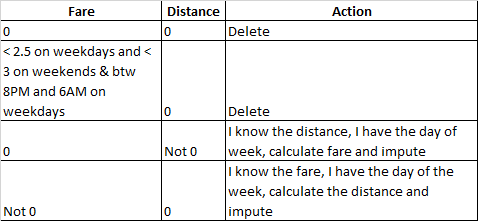


In [23]:
train = train.drop(train[(train['H_Distance']==0)&(train['fare_amount']==0)].index, axis = 0)

In [24]:
#Between 6AM and 8PM on Mon-Fri
rush_hour = train.loc[(((train['Hour']>=6)&(train['Hour']<=20)) & ((train['Day of Week']>=1) & (train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 2.5))]
rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
830616,2015-01-21 06:29:21.000000600,0.01,2015-01-21 06:29:21,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,1.0,21.0,2.0,6.0
925892,2015-01-21 14:12:00.000000400,1.90,2015-01-21 14:12:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,1.0,21.0,2.0,14.0
1112195,2015-03-25 14:55:38.000000200,1.60,2015-03-25 14:55:38,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2015.0,3.0,25.0,2.0,14.0
1215355,2015-05-29 18:15:27.000000600,2.00,2015-05-29 18:15:27,-73.903214,40.747318,-73.903214,40.747318,1.0,0.0,2015.0,5.0,29.0,4.0,18.0
2097377,2013-08-30 15:11:00.000000143,0.50,2013-08-30 15:11:00,-121.340000,38.903350,-121.340000,38.903350,1.0,0.0,2013.0,8.0,30.0,4.0,15.0
2322071,2010-02-25 12:44:00.000000125,1.25,2010-02-25 12:44:00,-73.937722,40.758318,-73.937722,40.758318,5.0,0.0,2010.0,2.0,25.0,3.0,12.0
2949904,2015-01-22 13:34:00.000000300,2.00,2015-01-22 13:34:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,1.0,22.0,3.0,13.0
3010346,2015-01-23 08:50:38.000000600,0.01,2015-01-23 08:50:38,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,1.0,23.0,4.0,8.0
4112515,2015-04-15 20:12:10.000000500,0.01,2015-04-15 20:12:10,-73.994553,40.750240,-73.994553,40.750240,1.0,0.0,2015.0,4.0,15.0,2.0,20.0
4920415,2013-08-09 18:39:00.000000201,1.50,2013-08-09 18:39:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2013.0,8.0,9.0,4.0,18.0


In [25]:
train=train.drop(rush_hour.index, axis=0)

In [26]:
train.shape

(55418184, 14)

In [27]:
#Between 8PM and 6AM on Mon-Fri
non_rush_hour = train.loc[(((train['Hour']<6)|(train['Hour']>20)) & ((train['Day of Week']>=1)&(train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0))]
#print(Counter(non_work_hours['Hour']))
#print(Counter(non_work_hours['Day of Week']))
non_rush_hour
#keep these. Since the fare_amount is not <2.5 (which is the base fare), these values seem legit to me.

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
376,2014-05-29 05:57:22.000000100,2.5,2014-05-29 05:57:22,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2014.0,5.0,29.0,3.0,5.0
503,2010-01-19 01:10:00.000000120,2.5,2010-01-19 01:10:00,-73.998720,40.624708,-73.998720,40.624708,1.0,0.0,2010.0,1.0,19.0,1.0,1.0
657,2009-08-25 01:50:21.000000100,2.5,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1.0,0.0,2009.0,8.0,25.0,1.0,1.0
3168,2012-07-06 22:07:00.000000111,2.5,2012-07-06 22:07:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2012.0,7.0,6.0,4.0,22.0
12953,2010-07-23 03:30:08.000000100,2.9,2010-07-23 03:30:08,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2010.0,7.0,23.0,4.0,3.0
16074,2013-05-30 00:19:40.000000100,2.5,2013-05-30 00:19:40,-73.782520,40.644488,-73.782520,40.644488,1.0,0.0,2013.0,5.0,30.0,3.0,0.0
17862,2014-08-21 23:28:26.000000200,2.5,2014-08-21 23:28:26,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2014.0,8.0,21.0,3.0,23.0
18037,2009-01-07 22:16:00.000000172,2.5,2009-01-07 22:16:00,-73.992220,40.759068,-73.992220,40.759068,2.0,0.0,2009.0,1.0,7.0,2.0,22.0
24835,2015-02-27 02:23:09.000000400,2.5,2015-02-27 02:23:09,-73.983330,40.738205,-73.983330,40.738205,1.0,0.0,2015.0,2.0,27.0,4.0,2.0
29613,2009-06-17 03:14:11.000000100,2.5,2009-06-17 03:14:11,-73.934842,40.740996,-73.934842,40.740996,1.0,0.0,2009.0,6.0,17.0,2.0,3.0


In [28]:
#Saturday and Sunday all hours
weekends = train.loc[((train['Day of Week']==0) | (train['Day of Week']==6)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0)]
weekends
#Counter(weekends['Day of Week'])
#keep these too. Since the fare_amount is not <2.5, these values seem legit to me.

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00,0.000000,0.000000,-74.005433,40.726685,2.0,0.0,2009.0,2.0,22.0,6.0,22.0
1419,2013-07-21 00:10:23.000000100,2.5,2013-07-21 00:10:23,-73.956556,40.779828,-73.956556,40.779828,1.0,0.0,2013.0,7.0,21.0,6.0,0.0
1774,2012-08-27 15:24:00.000000700,2.5,2012-08-27 15:24:00,-73.950282,40.701282,-73.950282,40.701282,1.0,0.0,2012.0,8.0,27.0,0.0,15.0
4367,2014-01-13 16:14:48.000000100,2.5,2014-01-13 16:14:48,-73.948410,40.744969,-73.948410,40.744969,1.0,0.0,2014.0,1.0,13.0,0.0,16.0
4954,2010-01-10 13:44:35.000000700,2.5,2010-01-10 13:44:35,-73.983934,40.754938,-73.983934,40.754938,1.0,0.0,2010.0,1.0,10.0,6.0,13.0
6297,2010-11-15 09:29:00.000000191,2.5,2010-11-15 09:29:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2010.0,11.0,15.0,0.0,9.0
9177,2010-12-06 11:48:34.000000500,2.5,2010-12-06 11:48:34,-73.946993,40.744583,-73.946993,40.744583,3.0,0.0,2010.0,12.0,6.0,0.0,11.0
9621,2015-03-01 22:39:54.000000100,2.5,2015-03-01 22:39:54,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,3.0,1.0,6.0,22.0
11593,2010-10-17 04:28:00.000000150,2.9,2010-10-17 04:28:00,-73.851972,40.679820,-73.851972,40.679820,5.0,0.0,2010.0,10.0,17.0,6.0,4.0
13571,2009-03-09 12:26:25.000000100,2.5,2009-03-09 12:26:25,-73.416169,40.784140,-73.416169,40.784140,1.0,0.0,2009.0,3.0,9.0,0.0,12.0


**SCENARIO 3**

Fare is 0, but Distance is not 0. These values need to be imputed.

I can calculate the fare as I have the distance. I shall use the following formula
> *fare = 2.5 + 1.56(H_Distance)*

In [29]:
train.loc[(train['H_Distance']!=0) & (train['fare_amount']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
10002,2010-02-15 14:26:01.000000300,0.0,2010-02-15 14:26:01,-73.987115,40.738808,-74.005911,40.713960,1.0,3.184763,2010.0,2.0,15.0,0.0,14.0
27891,2015-05-15 21:40:28.000000100,0.0,2015-05-15 21:40:28,-74.077927,40.805714,-74.077919,40.805721,1.0,0.001064,2015.0,5.0,15.0,4.0,21.0
47302,2010-03-18 19:13:39.000000200,0.0,2010-03-18 19:13:39,-73.942346,40.806269,-73.942463,40.806129,1.0,0.018420,2010.0,3.0,18.0,3.0,19.0
175352,2014-06-29 16:04:29.000000200,0.0,2014-06-29 16:04:29,-73.484480,40.813401,-73.484442,40.813323,2.0,0.009244,2014.0,6.0,29.0,6.0,16.0
211455,2015-04-15 14:02:39.000000300,0.0,2015-04-15 14:02:39,-73.937378,40.758450,-73.937447,40.758450,1.0,0.005783,2015.0,4.0,15.0,2.0,14.0
211499,2010-03-08 18:22:00.000000760,0.0,2010-03-08 18:22:00,-73.937353,40.758227,-73.937358,40.758230,1.0,0.000537,2010.0,3.0,8.0,0.0,18.0
266485,2010-02-20 09:51:27.000000400,0.0,2010-02-20 09:51:27,-73.877376,40.772415,-73.877403,40.772391,1.0,0.003506,2010.0,2.0,20.0,5.0,9.0
386734,2015-05-08 07:02:38.000000100,0.0,2015-05-08 07:02:38,-73.999496,40.748787,-74.002556,40.744659,1.0,0.526370,2015.0,5.0,8.0,4.0,7.0
431819,2015-01-13 00:48:21.000000100,0.0,2015-01-13 00:48:21,-73.998383,40.759418,-74.031189,40.748924,1.0,2.999630,2015.0,1.0,13.0,1.0,0.0
489767,2015-02-14 21:06:53.000000700,0.0,2015-02-14 21:06:53,-73.949951,40.776215,-73.949959,40.776218,2.0,0.000770,2015.0,2.0,14.0,5.0,21.0


In [30]:
scenario_3 = train.loc[(train['H_Distance']!=0) & (train['fare_amount']==0)]

In [31]:
len(scenario_3)

951

In [32]:
#We do not have any distance values that are outliers.
scenario_3.sort_values('H_Distance', ascending=False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
10298873,2015-02-24 04:49:57.000000100,0.0,2015-02-24 04:49:57,-73.979218,40.750992,-73.980278,41.203316,3.0,50.296203,2015.0,2.0,24.0,1.0,4.0
31634561,2015-01-21 16:11:34.000000500,0.0,2015-01-21 16:11:34,-73.787720,40.663593,-74.210564,40.947937,1.0,47.605296,2015.0,1.0,21.0,2.0,16.0
52446781,2015-02-02 15:58:19.000000200,0.0,2015-02-02 15:58:19,-73.874123,40.773781,-73.514107,41.045540,1.0,42.760149,2015.0,2.0,2.0,0.0,15.0
30713817,2015-06-18 03:48:22.000000200,0.0,2015-06-18 03:48:22,-73.990417,40.761440,-74.454628,40.840805,1.0,40.057925,2015.0,6.0,18.0,3.0,3.0
26852762,2015-06-09 20:38:31.000000100,0.0,2015-06-09 20:38:31,-74.009041,40.730591,-74.332802,40.472439,1.0,39.637208,2015.0,6.0,9.0,1.0,20.0
40349997,2015-05-17 01:16:20.000000500,0.0,2015-05-17 01:16:20,-73.993973,40.757397,-74.425850,40.860146,2.0,38.101303,2015.0,5.0,17.0,6.0,1.0
7417060,2013-08-27 11:57:21.000000100,0.0,2013-08-27 11:57:21,-73.972717,40.749389,-74.395686,40.651782,1.0,37.271467,2013.0,8.0,27.0,1.0,11.0
39335120,2015-06-02 12:52:10.000000300,0.0,2015-06-02 12:52:10,-73.853592,40.756676,-73.417984,40.782120,1.0,36.792667,2015.0,6.0,2.0,1.0,12.0
46100250,2013-08-31 19:50:15.000000200,0.0,2013-08-31 19:50:15,-73.989063,40.754194,-74.382002,40.809972,2.0,33.660486,2013.0,8.0,31.0,5.0,19.0
45784628,2015-04-17 22:48:32.000000700,0.0,2015-04-17 22:48:32,-73.801750,40.665936,-73.971832,40.930836,4.0,32.750582,2015.0,4.0,17.0,4.0,22.0


In [33]:
scenario_3['fare_amount'] = scenario_3.apply(
    lambda row: ((row['H_Distance'] * 1.56) + 2.50), axis=1
)

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
scenario_3['fare_amount']

10002        7.468230
27891        2.501660
47302        2.528736
175352       2.514421
211455       2.509022
211499       2.500838
266485       2.505469
386734       3.321137
431819       7.179423
489767       2.501201
495273       2.500662
520715       3.157114
561786      19.524533
670254       2.500662
681342       2.501577
760662       3.034632
762802      25.597788
788466      28.034391
895361       3.369958
938020       2.501202
957590       2.505506
1104435     27.117942
1107618     40.420482
1155672      9.100196
1160560     29.457723
1161016      2.955397
1249746      3.162058
1290023      2.504680
1291130      2.937446
1296011      7.772359
              ...    
53690881     2.501661
53823521     2.501846
53907065     2.512856
53928407     2.500906
53965124     2.509549
53993203     3.043559
54160171    15.856935
54179744     2.511609
54335761     2.501201
54393765     2.605546
54491199     2.621007
54513177    10.395023
54568682     9.592136
54618427    22.757666
54672421  

In [35]:
train.update(scenario_3)

In [36]:
train.shape

(55418184, 14)

**SCENARIO 4**

Fare is  not 0, but Distance is 0. These values need to be imputed.

In [37]:
train.loc[(train['H_Distance']==0) & (train['fare_amount']!=0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
11,2012-12-24 11:24:00.000000980,5.50,2012-12-24 11:24:00,0.000000,0.000000,0.000000,0.000000,3.0,0.0,2012.0,12.0,24.0,0.0,11.0
15,2013-11-23 12:57:00.000000190,5.00,2013-11-23 12:57:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2013.0,11.0,23.0,5.0,12.0
26,2011-02-07 20:01:00.000000114,6.50,2011-02-07 20:01:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2011.0,2.0,7.0,0.0,20.0
105,2009-03-25 00:08:52.000000100,52.00,2009-03-25 00:08:52,-74.035839,40.747320,-74.035839,40.747320,1.0,0.0,2009.0,3.0,25.0,2.0,0.0
124,2013-01-17 17:22:00.000000430,8.00,2013-01-17 17:22:00,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2013.0,1.0,17.0,3.0,17.0
191,2014-01-08 21:55:58.000000600,6.50,2014-01-08 21:55:58,-73.998488,40.726303,-73.998488,40.726303,1.0,0.0,2014.0,1.0,8.0,2.0,21.0
192,2010-09-05 17:08:00.000000920,3.70,2010-09-05 17:08:00,0.000000,0.000000,0.000000,0.000000,5.0,0.0,2010.0,9.0,5.0,6.0,17.0
233,2011-07-24 01:14:35.000000200,8.50,2011-07-24 01:14:35,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2011.0,7.0,24.0,6.0,1.0
270,2012-08-25 01:53:42.000000500,7.50,2012-08-25 01:53:42,-73.995892,40.746454,-73.995892,40.746454,1.0,0.0,2012.0,8.0,25.0,5.0,1.0
273,2009-10-30 18:13:00.000000210,8.10,2009-10-30 18:13:00,0.000000,0.000000,0.000000,0.000000,4.0,0.0,2009.0,10.0,30.0,4.0,18.0


In [38]:
scenario_4 = train.loc[(train['H_Distance']==0) & (train['fare_amount']!=0)]

In [39]:
len(scenario_4)

1590944

In [40]:
#Using our prior knowledge about the base price during weekdays and weekends for the cabs.
#I do not want to impute these 1502 values as they are legible ones.
scenario_4.loc[(scenario_4['fare_amount']<=3.0)&(scenario_4['H_Distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
376,2014-05-29 05:57:22.000000100,2.5,2014-05-29 05:57:22,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2014.0,5.0,29.0,3.0,5.0
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00,0.000000,0.000000,-74.005433,40.726685,2.0,0.0,2009.0,2.0,22.0,6.0,22.0
503,2010-01-19 01:10:00.000000120,2.5,2010-01-19 01:10:00,-73.998720,40.624708,-73.998720,40.624708,1.0,0.0,2010.0,1.0,19.0,1.0,1.0
657,2009-08-25 01:50:21.000000100,2.5,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1.0,0.0,2009.0,8.0,25.0,1.0,1.0
799,2013-12-08 23:39:00.000000800,3.0,2013-12-08 23:39:00,0.000000,0.000000,0.000000,0.000000,5.0,0.0,2013.0,12.0,8.0,6.0,23.0
958,2011-02-22 14:09:00.000000660,2.5,2011-02-22 14:09:00,0.000000,0.000000,0.000000,0.000000,5.0,0.0,2011.0,2.0,22.0,1.0,14.0
1419,2013-07-21 00:10:23.000000100,2.5,2013-07-21 00:10:23,-73.956556,40.779828,-73.956556,40.779828,1.0,0.0,2013.0,7.0,21.0,6.0,0.0
1774,2012-08-27 15:24:00.000000700,2.5,2012-08-27 15:24:00,-73.950282,40.701282,-73.950282,40.701282,1.0,0.0,2012.0,8.0,27.0,0.0,15.0
3168,2012-07-06 22:07:00.000000111,2.5,2012-07-06 22:07:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2012.0,7.0,6.0,4.0,22.0
4367,2014-01-13 16:14:48.000000100,2.5,2014-01-13 16:14:48,-73.948410,40.744969,-73.948410,40.744969,1.0,0.0,2014.0,1.0,13.0,0.0,16.0


In [41]:
scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
11,2012-12-24 11:24:00.000000980,5.50,2012-12-24 11:24:00,0.000000,0.000000,0.000000,0.000000,3.0,0.0,2012.0,12.0,24.0,0.0,11.0
15,2013-11-23 12:57:00.000000190,5.00,2013-11-23 12:57:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2013.0,11.0,23.0,5.0,12.0
26,2011-02-07 20:01:00.000000114,6.50,2011-02-07 20:01:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2011.0,2.0,7.0,0.0,20.0
105,2009-03-25 00:08:52.000000100,52.00,2009-03-25 00:08:52,-74.035839,40.747320,-74.035839,40.747320,1.0,0.0,2009.0,3.0,25.0,2.0,0.0
124,2013-01-17 17:22:00.000000430,8.00,2013-01-17 17:22:00,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2013.0,1.0,17.0,3.0,17.0
191,2014-01-08 21:55:58.000000600,6.50,2014-01-08 21:55:58,-73.998488,40.726303,-73.998488,40.726303,1.0,0.0,2014.0,1.0,8.0,2.0,21.0
192,2010-09-05 17:08:00.000000920,3.70,2010-09-05 17:08:00,0.000000,0.000000,0.000000,0.000000,5.0,0.0,2010.0,9.0,5.0,6.0,17.0
233,2011-07-24 01:14:35.000000200,8.50,2011-07-24 01:14:35,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2011.0,7.0,24.0,6.0,1.0
270,2012-08-25 01:53:42.000000500,7.50,2012-08-25 01:53:42,-73.995892,40.746454,-73.995892,40.746454,1.0,0.0,2012.0,8.0,25.0,5.0,1.0
273,2009-10-30 18:13:00.000000210,8.10,2009-10-30 18:13:00,0.000000,0.000000,0.000000,0.000000,4.0,0.0,2009.0,10.0,30.0,4.0,18.0


These 27159 rows need to be imputed using the following formula - 
> *distance = (fare_amount - 2.5)/1.56*

In [42]:
scenario_4_sub = scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

In [43]:
len(scenario_4_sub)

1508931

In [44]:
scenario_4_sub['H_Distance'] = scenario_4_sub.apply(
lambda row: ((row['fare_amount']-2.50)/1.56), axis=1
)

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
train.update(scenario_4_sub)

In [46]:
train.shape

(55418184, 14)

**PART 2 --> MODELLING AND PREDICTION**

FINALLY! Data cleansing is done! Now to split the x and y variables and proceed to modelling. I shall use the random forest method for prediction

In [47]:
#not including the pickup_datetime columns as datetime columns cannot be directly used while modelling. Features need to extracted from the 
#timestamp fields which will later be used as features for modelling.
train = train.drop(['key','pickup_datetime'], axis = 1)
test = test.drop(['key','pickup_datetime'], axis = 1)

In [48]:
x_train = train.iloc[:,train.columns!='fare_amount']
y_train = train['fare_amount'].values
x_test = test

In [49]:
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, ParameterGrid, KFold
from  tqdm import tqdm

kf = KFold(n_splits=5)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

best_score = 100
best_params = None

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['regression'], 'metric': ['rmse'], 
          'learning_rate': [0.01], 'num_leaves': [31, 127, 255, 511], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[-1], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
          'min_split_gain':[0.01], 'min_child_weight':[3, 5, 10], 'seed':[114], 'max_bin':[511]}

list_score = []

for params in tqdm(list(ParameterGrid(all_params))):
#    for train_idx, valid_idx in cv.split(x_train, y_train):
    for train_idx, valid_idx in kf.split(x_train):
        trn_x = x_train.iloc[train_idx, :]
        val_x = x_train.iloc[valid_idx, :]
    
        trn_y = y_train[train_idx]
        val_y = y_train[valid_idx]
           
        clf = lgb.sklearn.LGBMRegressor(**params)
        clf.fit(trn_x,
                    trn_y,
                    eval_set=[(val_x, val_y)],
                    early_stopping_rounds=150,
                    eval_metric='rmse'
                )        
        preds_val = clf.predict(val_x,  num_iteration=clf.best_iteration_)
        
        rems = np.sqrt(mean_squared_error(val_y, preds_val))
        list_score.append(rems)
        
        if (best_score > rems):
            best_score = rems
            best_params = params
    
sc_score = np.mean(list_score)
print(sc_score, best_score, best_params)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71614
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64064
[3]	valid_0's rmse: 9.56581
[4]	valid_0's rmse: 9.49161
[5]	valid_0's rmse: 9.44402
[6]	valid_0's rmse: 9.3718
[7]	valid_0's rmse: 9.30034
[8]	valid_0's rmse: 9.22926
[9]	valid_0's rmse: 9.15905
[10]	valid_0's rmse: 9.09001
[11]	valid_0's rmse: 9.0465
[12]	valid_0's rmse: 8.97838
[13]	valid_0's rmse: 8.91157
[14]	valid_0's rmse: 8.84567
[15]	valid_0's rmse: 8.79439
[16]	valid_0's rmse: 8.76584
[17]	valid_0's rmse: 8.70156
[18]	valid_0's rmse: 8.63822
[19]	valid_0's rmse: 8.57551
[20]	valid_0's rmse: 8.51307
[21]	valid_0's rmse: 8.46928
[22]	valid_0's rmse: 8.40795
[23]	valid_0's rmse: 8.34759
[24]	valid_0's rmse: 8.28799
[25]	valid_0's rmse: 8.22946
[26]	valid_0's rmse: 8.17156
[27]	valid_0's rmse: 8.11448
[28]	valid_0's rmse: 8.0701
[29]	valid_0's rmse: 8.01414
[30]	valid_0's rmse: 7.95903
[31]	valid_0's rmse: 7.90408
[32]	valid_0's rmse: 7.85031
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.12731
[277]	valid_0's rmse: 4.12514
[278]	valid_0's rmse: 4.12284
[279]	valid_0's rmse: 4.12095
[280]	valid_0's rmse: 4.1189
[281]	valid_0's rmse: 4.11704
[282]	valid_0's rmse: 4.11488
[283]	valid_0's rmse: 4.11345
[284]	valid_0's rmse: 4.11117
[285]	valid_0's rmse: 4.10915
[286]	valid_0's rmse: 4.10782
[287]	valid_0's rmse: 4.10593
[288]	valid_0's rmse: 4.10374
[289]	valid_0's rmse: 4.10208
[290]	valid_0's rmse: 4.10005
[291]	valid_0's rmse: 4.0981
[292]	valid_0's rmse: 4.097
[293]	valid_0's rmse: 4.09506
[294]	valid_0's rmse: 4.09343
[295]	valid_0's rmse: 4.09139
[296]	valid_0's rmse: 4.08955
[297]	valid_0's rmse: 4.08769
[298]	valid_0's rmse: 4.08582
[299]	valid_0's rmse: 4.08393
[300]	valid_0's rmse: 4.0824
[301]	valid_0's rmse: 4.08045
[302]	valid_0's rmse: 4.07875
[303]	valid_0's rmse: 4.07748
[304]	valid_0's rmse: 4.0759
[305]	valid_0's rmse: 4.0743
[306]	valid_0's rmse: 4.07263
[307]	valid_0's rmse: 4.07099
[308]	valid_0's rmse: 4.06939
[309]	valid_0's r

[550]	valid_0's rmse: 3.91989
[551]	valid_0's rmse: 3.91977
[552]	valid_0's rmse: 3.91941
[553]	valid_0's rmse: 3.91928
[554]	valid_0's rmse: 3.91901
[555]	valid_0's rmse: 3.91868
[556]	valid_0's rmse: 3.91831
[557]	valid_0's rmse: 3.91808
[558]	valid_0's rmse: 3.91863
[559]	valid_0's rmse: 3.91807
[560]	valid_0's rmse: 3.91825
[561]	valid_0's rmse: 3.91792
[562]	valid_0's rmse: 3.91795
[563]	valid_0's rmse: 3.9181
[564]	valid_0's rmse: 3.91783
[565]	valid_0's rmse: 3.91773
[566]	valid_0's rmse: 3.91764
[567]	valid_0's rmse: 3.9181
[568]	valid_0's rmse: 3.91763
[569]	valid_0's rmse: 3.91728
[570]	valid_0's rmse: 3.91792
[571]	valid_0's rmse: 3.91735
[572]	valid_0's rmse: 3.91759
[573]	valid_0's rmse: 3.91748
[574]	valid_0's rmse: 3.91763
[575]	valid_0's rmse: 3.91745
[576]	valid_0's rmse: 3.91705
[577]	valid_0's rmse: 3.91675
[578]	valid_0's rmse: 3.91649
[579]	valid_0's rmse: 3.91611
[580]	valid_0's rmse: 3.91564
[581]	valid_0's rmse: 3.91576
[582]	valid_0's rmse: 3.91542
[583]	valid_

[824]	valid_0's rmse: 3.90078
[825]	valid_0's rmse: 3.90063
[826]	valid_0's rmse: 3.90047
[827]	valid_0's rmse: 3.90032
[828]	valid_0's rmse: 3.89988
[829]	valid_0's rmse: 3.89971
[830]	valid_0's rmse: 3.89961
[831]	valid_0's rmse: 3.89938
[832]	valid_0's rmse: 3.90011
[833]	valid_0's rmse: 3.90013
[834]	valid_0's rmse: 3.8997
[835]	valid_0's rmse: 3.89954
[836]	valid_0's rmse: 3.89942
[837]	valid_0's rmse: 3.89961
[838]	valid_0's rmse: 3.89942
[839]	valid_0's rmse: 3.89915
[840]	valid_0's rmse: 3.89928
[841]	valid_0's rmse: 3.89893
[842]	valid_0's rmse: 3.89885
[843]	valid_0's rmse: 3.89867
[844]	valid_0's rmse: 3.8986
[845]	valid_0's rmse: 3.89846
[846]	valid_0's rmse: 3.89838
[847]	valid_0's rmse: 3.89818
[848]	valid_0's rmse: 3.89796
[849]	valid_0's rmse: 3.89887
[850]	valid_0's rmse: 3.89866
[851]	valid_0's rmse: 3.89878
[852]	valid_0's rmse: 3.89854
[853]	valid_0's rmse: 3.89837
[854]	valid_0's rmse: 3.89824
[855]	valid_0's rmse: 3.89784
[856]	valid_0's rmse: 3.89766
[857]	valid_

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8941
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.859
[3]	valid_0's rmse: 20.8245
[4]	valid_0's rmse: 20.7904
[5]	valid_0's rmse: 20.7687
[6]	valid_0's rmse: 20.7359
[7]	valid_0's rmse: 20.7036
[8]	valid_0's rmse: 20.6717
[9]	valid_0's rmse: 20.6404
[10]	valid_0's rmse: 20.6097
[11]	valid_0's rmse: 20.5905
[12]	valid_0's rmse: 20.5606
[13]	valid_0's rmse: 20.5314
[14]	valid_0's rmse: 20.5029
[15]	valid_0's rmse: 20.4808
[16]	valid_0's rmse: 20.4685
[17]	valid_0's rmse: 20.4409
[18]	valid_0's rmse: 20.414
[19]	valid_0's rmse: 20.3875
[20]	valid_0's rmse: 20.3612
[21]	valid_0's rmse: 20.3429
[22]	valid_0's rmse: 20.3175
[23]	valid_0's rmse: 20.2925
[24]	valid_0's rmse: 20.268
[25]	valid_0's rmse: 20.2441
[26]	valid_0's rmse: 20.2206
[27]	valid_0's rmse: 20.1975
[28]	valid_0's rmse: 20.1798
[29]	valid_0's rmse: 20.1574
[30]	valid_0's rmse: 20.1355
[31]	valid_0's rmse: 20.1138
[32]	valid_0's rmse: 20.0927
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 18.9497
[277]	valid_0's rmse: 18.9492
[278]	valid_0's rmse: 18.9487
[279]	valid_0's rmse: 18.9482
[280]	valid_0's rmse: 18.9478
[281]	valid_0's rmse: 18.9473
[282]	valid_0's rmse: 18.9469
[283]	valid_0's rmse: 18.9466
[284]	valid_0's rmse: 18.9461
[285]	valid_0's rmse: 18.9457
[286]	valid_0's rmse: 18.9454
[287]	valid_0's rmse: 18.9449
[288]	valid_0's rmse: 18.9444
[289]	valid_0's rmse: 18.944
[290]	valid_0's rmse: 18.9436
[291]	valid_0's rmse: 18.9432
[292]	valid_0's rmse: 18.943
[293]	valid_0's rmse: 18.9426
[294]	valid_0's rmse: 18.9422
[295]	valid_0's rmse: 18.9418
[296]	valid_0's rmse: 18.9414
[297]	valid_0's rmse: 18.941
[298]	valid_0's rmse: 18.9406
[299]	valid_0's rmse: 18.9403
[300]	valid_0's rmse: 18.9399
[301]	valid_0's rmse: 18.9395
[302]	valid_0's rmse: 18.9391
[303]	valid_0's rmse: 18.9389
[304]	valid_0's rmse: 18.9385
[305]	valid_0's rmse: 18.9382
[306]	valid_0's rmse: 18.9378
[307]	valid_0's rmse: 18.9375
[308]	valid_0's rmse: 18.9371
[309]	valid_0

[549]	valid_0's rmse: 18.9057
[550]	valid_0's rmse: 18.9057
[551]	valid_0's rmse: 18.9057
[552]	valid_0's rmse: 18.9056
[553]	valid_0's rmse: 18.9055
[554]	valid_0's rmse: 18.9055
[555]	valid_0's rmse: 18.9054
[556]	valid_0's rmse: 18.9053
[557]	valid_0's rmse: 18.9052
[558]	valid_0's rmse: 18.9052
[559]	valid_0's rmse: 18.9052
[560]	valid_0's rmse: 18.9053
[561]	valid_0's rmse: 18.9052
[562]	valid_0's rmse: 18.9051
[563]	valid_0's rmse: 18.905
[564]	valid_0's rmse: 18.905
[565]	valid_0's rmse: 18.905
[566]	valid_0's rmse: 18.9049
[567]	valid_0's rmse: 18.905
[568]	valid_0's rmse: 18.9049
[569]	valid_0's rmse: 18.9049
[570]	valid_0's rmse: 18.9051
[571]	valid_0's rmse: 18.9051
[572]	valid_0's rmse: 18.9052
[573]	valid_0's rmse: 18.9051
[574]	valid_0's rmse: 18.9051
[575]	valid_0's rmse: 18.905
[576]	valid_0's rmse: 18.905
[577]	valid_0's rmse: 18.9049
[578]	valid_0's rmse: 18.9048
[579]	valid_0's rmse: 18.9048
[580]	valid_0's rmse: 18.9047
[581]	valid_0's rmse: 18.9047
[582]	valid_0's 

[823]	valid_0's rmse: 18.8987
[824]	valid_0's rmse: 18.8986
[825]	valid_0's rmse: 18.8986
[826]	valid_0's rmse: 18.8985
[827]	valid_0's rmse: 18.8985
[828]	valid_0's rmse: 18.8985
[829]	valid_0's rmse: 18.8984
[830]	valid_0's rmse: 18.8985
[831]	valid_0's rmse: 18.8984
[832]	valid_0's rmse: 18.8984
[833]	valid_0's rmse: 18.8986
[834]	valid_0's rmse: 18.8985
[835]	valid_0's rmse: 18.8985
[836]	valid_0's rmse: 18.8984
[837]	valid_0's rmse: 18.8985
[838]	valid_0's rmse: 18.8985
[839]	valid_0's rmse: 18.8984
[840]	valid_0's rmse: 18.8985
[841]	valid_0's rmse: 18.8987
[842]	valid_0's rmse: 18.8986
[843]	valid_0's rmse: 18.8986
[844]	valid_0's rmse: 18.8986
[845]	valid_0's rmse: 18.8986
[846]	valid_0's rmse: 18.8985
[847]	valid_0's rmse: 18.8986
[848]	valid_0's rmse: 18.8985
[849]	valid_0's rmse: 18.8989
[850]	valid_0's rmse: 18.8988
[851]	valid_0's rmse: 18.8987
[852]	valid_0's rmse: 18.8988
[853]	valid_0's rmse: 18.8987
[854]	valid_0's rmse: 18.8987
[855]	valid_0's rmse: 18.8987
[856]	vali

[1094]	valid_0's rmse: 18.8979
[1095]	valid_0's rmse: 18.8979
[1096]	valid_0's rmse: 18.8978
[1097]	valid_0's rmse: 18.8978
[1098]	valid_0's rmse: 18.8978
[1099]	valid_0's rmse: 18.8977
[1100]	valid_0's rmse: 18.8977
[1101]	valid_0's rmse: 18.8977
[1102]	valid_0's rmse: 18.8977
[1103]	valid_0's rmse: 18.8976
[1104]	valid_0's rmse: 18.8976
[1105]	valid_0's rmse: 18.8975
[1106]	valid_0's rmse: 18.8975
[1107]	valid_0's rmse: 18.8975
[1108]	valid_0's rmse: 18.8976
[1109]	valid_0's rmse: 18.8976
[1110]	valid_0's rmse: 18.8975
[1111]	valid_0's rmse: 18.8976
[1112]	valid_0's rmse: 18.8975
[1113]	valid_0's rmse: 18.8976
[1114]	valid_0's rmse: 18.8976
[1115]	valid_0's rmse: 18.8976
[1116]	valid_0's rmse: 18.8979
[1117]	valid_0's rmse: 18.8979
[1118]	valid_0's rmse: 18.8978
[1119]	valid_0's rmse: 18.8978
[1120]	valid_0's rmse: 18.8978
[1121]	valid_0's rmse: 18.8977
[1122]	valid_0's rmse: 18.898
[1123]	valid_0's rmse: 18.898
[1124]	valid_0's rmse: 18.898
[1125]	valid_0's rmse: 18.898
[1126]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78468
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.7096
[3]	valid_0's rmse: 9.63553
[4]	valid_0's rmse: 9.5618
[5]	valid_0's rmse: 9.51465
[6]	valid_0's rmse: 9.44301
[7]	valid_0's rmse: 9.37192
[8]	valid_0's rmse: 9.3013
[9]	valid_0's rmse: 9.23155
[10]	valid_0's rmse: 9.16294
[11]	valid_0's rmse: 9.11966
[12]	valid_0's rmse: 9.05211
[13]	valid_0's rmse: 8.98567
[14]	valid_0's rmse: 8.92024
[15]	valid_0's rmse: 8.86946
[16]	valid_0's rmse: 8.84112
[17]	valid_0's rmse: 8.77723
[18]	valid_0's rmse: 8.71447
[19]	valid_0's rmse: 8.65226
[20]	valid_0's rmse: 8.59021
[21]	valid_0's rmse: 8.54689
[22]	valid_0's rmse: 8.48612
[23]	valid_0's rmse: 8.42627
[24]	valid_0's rmse: 8.3669
[25]	valid_0's rmse: 8.30899
[26]	valid_0's rmse: 8.2516
[27]	valid_0's rmse: 8.19482
[28]	valid_0's rmse: 8.1509
[29]	valid_0's rmse: 8.09538
[30]	valid_0's rmse: 8.04084
[31]	valid_0's rmse: 7.98638
[32]	valid_0's rmse: 7.93311
[33]	valid_0's rmse: 7.8

[276]	valid_0's rmse: 4.27617
[277]	valid_0's rmse: 4.27399
[278]	valid_0's rmse: 4.27175
[279]	valid_0's rmse: 4.26963
[280]	valid_0's rmse: 4.26764
[281]	valid_0's rmse: 4.26557
[282]	valid_0's rmse: 4.26352
[283]	valid_0's rmse: 4.26221
[284]	valid_0's rmse: 4.26009
[285]	valid_0's rmse: 4.25802
[286]	valid_0's rmse: 4.25675
[287]	valid_0's rmse: 4.25481
[288]	valid_0's rmse: 4.25284
[289]	valid_0's rmse: 4.25122
[290]	valid_0's rmse: 4.24926
[291]	valid_0's rmse: 4.2474
[292]	valid_0's rmse: 4.24636
[293]	valid_0's rmse: 4.24452
[294]	valid_0's rmse: 4.24308
[295]	valid_0's rmse: 4.24113
[296]	valid_0's rmse: 4.23942
[297]	valid_0's rmse: 4.23762
[298]	valid_0's rmse: 4.23589
[299]	valid_0's rmse: 4.23412
[300]	valid_0's rmse: 4.23273
[301]	valid_0's rmse: 4.23111
[302]	valid_0's rmse: 4.22956
[303]	valid_0's rmse: 4.22835
[304]	valid_0's rmse: 4.22707
[305]	valid_0's rmse: 4.22541
[306]	valid_0's rmse: 4.22381
[307]	valid_0's rmse: 4.22222
[308]	valid_0's rmse: 4.22068
[309]	valid

[550]	valid_0's rmse: 4.07638
[551]	valid_0's rmse: 4.07603
[552]	valid_0's rmse: 4.07568
[553]	valid_0's rmse: 4.07528
[554]	valid_0's rmse: 4.07502
[555]	valid_0's rmse: 4.07476
[556]	valid_0's rmse: 4.0742
[557]	valid_0's rmse: 4.07399
[558]	valid_0's rmse: 4.07393
[559]	valid_0's rmse: 4.07354
[560]	valid_0's rmse: 4.07389
[561]	valid_0's rmse: 4.07378
[562]	valid_0's rmse: 4.07435
[563]	valid_0's rmse: 4.07418
[564]	valid_0's rmse: 4.07392
[565]	valid_0's rmse: 4.07419
[566]	valid_0's rmse: 4.07403
[567]	valid_0's rmse: 4.07411
[568]	valid_0's rmse: 4.07391
[569]	valid_0's rmse: 4.0741
[570]	valid_0's rmse: 4.07417
[571]	valid_0's rmse: 4.07402
[572]	valid_0's rmse: 4.07527
[573]	valid_0's rmse: 4.07488
[574]	valid_0's rmse: 4.07461
[575]	valid_0's rmse: 4.07444
[576]	valid_0's rmse: 4.07412
[577]	valid_0's rmse: 4.07394
[578]	valid_0's rmse: 4.07347
[579]	valid_0's rmse: 4.07316
[580]	valid_0's rmse: 4.07291
[581]	valid_0's rmse: 4.07283
[582]	valid_0's rmse: 4.07273
[583]	valid_

[824]	valid_0's rmse: 4.07021
[825]	valid_0's rmse: 4.07007
[826]	valid_0's rmse: 4.06963
[827]	valid_0's rmse: 4.07
[828]	valid_0's rmse: 4.06994
[829]	valid_0's rmse: 4.06979
[830]	valid_0's rmse: 4.06961
[831]	valid_0's rmse: 4.06948
[832]	valid_0's rmse: 4.06939
[833]	valid_0's rmse: 4.06975
[834]	valid_0's rmse: 4.06934
[835]	valid_0's rmse: 4.06913
[836]	valid_0's rmse: 4.06949
[837]	valid_0's rmse: 4.0709
[838]	valid_0's rmse: 4.07073
[839]	valid_0's rmse: 4.07059
[840]	valid_0's rmse: 4.07037
[841]	valid_0's rmse: 4.07023
[842]	valid_0's rmse: 4.07011
[843]	valid_0's rmse: 4.06996
[844]	valid_0's rmse: 4.06984
[845]	valid_0's rmse: 4.06972
[846]	valid_0's rmse: 4.06944
[847]	valid_0's rmse: 4.06949
[848]	valid_0's rmse: 4.06933
[849]	valid_0's rmse: 4.06919
[850]	valid_0's rmse: 4.06904
[851]	valid_0's rmse: 4.06899
[852]	valid_0's rmse: 4.06908
[853]	valid_0's rmse: 4.06888
[854]	valid_0's rmse: 4.06876
[855]	valid_0's rmse: 4.06841
[856]	valid_0's rmse: 4.06844
[857]	valid_0'

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6278
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6083
[3]	valid_0's rmse: 37.5891
[4]	valid_0's rmse: 37.5703
[5]	valid_0's rmse: 37.5584
[6]	valid_0's rmse: 37.5403
[7]	valid_0's rmse: 37.5225
[8]	valid_0's rmse: 37.5049
[9]	valid_0's rmse: 37.4877
[10]	valid_0's rmse: 37.4708
[11]	valid_0's rmse: 37.4602
[12]	valid_0's rmse: 37.4438
[13]	valid_0's rmse: 37.4278
[14]	valid_0's rmse: 37.4122
[15]	valid_0's rmse: 37.4001
[16]	valid_0's rmse: 37.3934
[17]	valid_0's rmse: 37.3784
[18]	valid_0's rmse: 37.3637
[19]	valid_0's rmse: 37.3492
[20]	valid_0's rmse: 37.3349
[21]	valid_0's rmse: 37.3249
[22]	valid_0's rmse: 37.311
[23]	valid_0's rmse: 37.2974
[24]	valid_0's rmse: 37.284
[25]	valid_0's rmse: 37.2711
[26]	valid_0's rmse: 37.2584
[27]	valid_0's rmse: 37.2458
[28]	valid_0's rmse: 37.2362
[29]	valid_0's rmse: 37.2241
[30]	valid_0's rmse: 37.2123
[31]	valid_0's rmse: 37.2005
[32]	valid_0's rmse: 37.1891
[33]	valid_0's rmse:

[276]	valid_0's rmse: 36.5837
[277]	valid_0's rmse: 36.5835
[278]	valid_0's rmse: 36.5832
[279]	valid_0's rmse: 36.583
[280]	valid_0's rmse: 36.5827
[281]	valid_0's rmse: 36.5825
[282]	valid_0's rmse: 36.5822
[283]	valid_0's rmse: 36.582
[284]	valid_0's rmse: 36.5818
[285]	valid_0's rmse: 36.5816
[286]	valid_0's rmse: 36.5814
[287]	valid_0's rmse: 36.5812
[288]	valid_0's rmse: 36.5809
[289]	valid_0's rmse: 36.5807
[290]	valid_0's rmse: 36.5805
[291]	valid_0's rmse: 36.5803
[292]	valid_0's rmse: 36.5802
[293]	valid_0's rmse: 36.58
[294]	valid_0's rmse: 36.5798
[295]	valid_0's rmse: 36.5796
[296]	valid_0's rmse: 36.5794
[297]	valid_0's rmse: 36.5792
[298]	valid_0's rmse: 36.579
[299]	valid_0's rmse: 36.5788
[300]	valid_0's rmse: 36.5786
[301]	valid_0's rmse: 36.5784
[302]	valid_0's rmse: 36.5782
[303]	valid_0's rmse: 36.578
[304]	valid_0's rmse: 36.5778
[305]	valid_0's rmse: 36.5777
[306]	valid_0's rmse: 36.5775
[307]	valid_0's rmse: 36.5773
[308]	valid_0's rmse: 36.5771
[309]	valid_0's 

[550]	valid_0's rmse: 36.5592
[551]	valid_0's rmse: 36.5592
[552]	valid_0's rmse: 36.5591
[553]	valid_0's rmse: 36.5591
[554]	valid_0's rmse: 36.5591
[555]	valid_0's rmse: 36.559
[556]	valid_0's rmse: 36.559
[557]	valid_0's rmse: 36.5589
[558]	valid_0's rmse: 36.5589
[559]	valid_0's rmse: 36.5589
[560]	valid_0's rmse: 36.5588
[561]	valid_0's rmse: 36.5588
[562]	valid_0's rmse: 36.5588
[563]	valid_0's rmse: 36.5588
[564]	valid_0's rmse: 36.5587
[565]	valid_0's rmse: 36.5587
[566]	valid_0's rmse: 36.5587
[567]	valid_0's rmse: 36.5587
[568]	valid_0's rmse: 36.5586
[569]	valid_0's rmse: 36.5586
[570]	valid_0's rmse: 36.5586
[571]	valid_0's rmse: 36.5585
[572]	valid_0's rmse: 36.5585
[573]	valid_0's rmse: 36.5584
[574]	valid_0's rmse: 36.5584
[575]	valid_0's rmse: 36.5584
[576]	valid_0's rmse: 36.5583
[577]	valid_0's rmse: 36.5583
[578]	valid_0's rmse: 36.5582
[579]	valid_0's rmse: 36.5582
[580]	valid_0's rmse: 36.5581
[581]	valid_0's rmse: 36.5581
[582]	valid_0's rmse: 36.5581
[583]	valid_

[823]	valid_0's rmse: 36.5523
[824]	valid_0's rmse: 36.5523
[825]	valid_0's rmse: 36.5523
[826]	valid_0's rmse: 36.5523
[827]	valid_0's rmse: 36.5523
[828]	valid_0's rmse: 36.5522
[829]	valid_0's rmse: 36.5523
[830]	valid_0's rmse: 36.5522
[831]	valid_0's rmse: 36.5522
[832]	valid_0's rmse: 36.5522
[833]	valid_0's rmse: 36.5522
[834]	valid_0's rmse: 36.5522
[835]	valid_0's rmse: 36.5522
[836]	valid_0's rmse: 36.5522
[837]	valid_0's rmse: 36.5521
[838]	valid_0's rmse: 36.5521
[839]	valid_0's rmse: 36.5521
[840]	valid_0's rmse: 36.5521
[841]	valid_0's rmse: 36.5521
[842]	valid_0's rmse: 36.552
[843]	valid_0's rmse: 36.552
[844]	valid_0's rmse: 36.552
[845]	valid_0's rmse: 36.552
[846]	valid_0's rmse: 36.552
[847]	valid_0's rmse: 36.552
[848]	valid_0's rmse: 36.552
[849]	valid_0's rmse: 36.5519
[850]	valid_0's rmse: 36.5519
[851]	valid_0's rmse: 36.5519
[852]	valid_0's rmse: 36.5519
[853]	valid_0's rmse: 36.5519
[854]	valid_0's rmse: 36.5519
[855]	valid_0's rmse: 36.5518
[856]	valid_0's r

[1094]	valid_0's rmse: 36.5479
[1095]	valid_0's rmse: 36.5479
[1096]	valid_0's rmse: 36.5479
[1097]	valid_0's rmse: 36.5479
[1098]	valid_0's rmse: 36.5479
[1099]	valid_0's rmse: 36.5478
[1100]	valid_0's rmse: 36.5478
[1101]	valid_0's rmse: 36.5478
[1102]	valid_0's rmse: 36.5478
[1103]	valid_0's rmse: 36.5478
[1104]	valid_0's rmse: 36.5478
[1105]	valid_0's rmse: 36.5477
[1106]	valid_0's rmse: 36.5477
[1107]	valid_0's rmse: 36.5477
[1108]	valid_0's rmse: 36.5477
[1109]	valid_0's rmse: 36.5477
[1110]	valid_0's rmse: 36.5477
[1111]	valid_0's rmse: 36.5477
[1112]	valid_0's rmse: 36.5476
[1113]	valid_0's rmse: 36.5476
[1114]	valid_0's rmse: 36.5476
[1115]	valid_0's rmse: 36.5476
[1116]	valid_0's rmse: 36.5476
[1117]	valid_0's rmse: 36.5476
[1118]	valid_0's rmse: 36.5476
[1119]	valid_0's rmse: 36.5475
[1120]	valid_0's rmse: 36.5475
[1121]	valid_0's rmse: 36.5475
[1122]	valid_0's rmse: 36.5475
[1123]	valid_0's rmse: 36.5475
[1124]	valid_0's rmse: 36.5475
[1125]	valid_0's rmse: 36.5475
[1126]	v

[1359]	valid_0's rmse: 36.5449
[1360]	valid_0's rmse: 36.5449
[1361]	valid_0's rmse: 36.5449
[1362]	valid_0's rmse: 36.5449
[1363]	valid_0's rmse: 36.5449
[1364]	valid_0's rmse: 36.5449
[1365]	valid_0's rmse: 36.5449
[1366]	valid_0's rmse: 36.5449
[1367]	valid_0's rmse: 36.5449
[1368]	valid_0's rmse: 36.5448
[1369]	valid_0's rmse: 36.5449
[1370]	valid_0's rmse: 36.5449
[1371]	valid_0's rmse: 36.5449
[1372]	valid_0's rmse: 36.5449
[1373]	valid_0's rmse: 36.5449
[1374]	valid_0's rmse: 36.5449
[1375]	valid_0's rmse: 36.5449
[1376]	valid_0's rmse: 36.5448
[1377]	valid_0's rmse: 36.5448
[1378]	valid_0's rmse: 36.5448
[1379]	valid_0's rmse: 36.5448
[1380]	valid_0's rmse: 36.5448
[1381]	valid_0's rmse: 36.5448
[1382]	valid_0's rmse: 36.5448
[1383]	valid_0's rmse: 36.5448
[1384]	valid_0's rmse: 36.5448
[1385]	valid_0's rmse: 36.5448
[1386]	valid_0's rmse: 36.5447
[1387]	valid_0's rmse: 36.5447
[1388]	valid_0's rmse: 36.5447
[1389]	valid_0's rmse: 36.5447
[1390]	valid_0's rmse: 36.5447
[1391]	v

[1624]	valid_0's rmse: 36.5425
[1625]	valid_0's rmse: 36.5425
[1626]	valid_0's rmse: 36.5425
[1627]	valid_0's rmse: 36.5425
[1628]	valid_0's rmse: 36.5425
[1629]	valid_0's rmse: 36.5425
[1630]	valid_0's rmse: 36.5425
[1631]	valid_0's rmse: 36.5425
[1632]	valid_0's rmse: 36.5425
[1633]	valid_0's rmse: 36.5425
[1634]	valid_0's rmse: 36.5425
[1635]	valid_0's rmse: 36.5425
[1636]	valid_0's rmse: 36.5425
[1637]	valid_0's rmse: 36.5424
[1638]	valid_0's rmse: 36.5424
[1639]	valid_0's rmse: 36.5424
[1640]	valid_0's rmse: 36.5424
[1641]	valid_0's rmse: 36.5424
[1642]	valid_0's rmse: 36.5424
[1643]	valid_0's rmse: 36.5424
[1644]	valid_0's rmse: 36.5424
[1645]	valid_0's rmse: 36.5424
[1646]	valid_0's rmse: 36.5424
[1647]	valid_0's rmse: 36.5423
[1648]	valid_0's rmse: 36.5423
[1649]	valid_0's rmse: 36.5423
[1650]	valid_0's rmse: 36.5423
[1651]	valid_0's rmse: 36.5423
[1652]	valid_0's rmse: 36.5423
[1653]	valid_0's rmse: 36.5423
[1654]	valid_0's rmse: 36.5423
[1655]	valid_0's rmse: 36.5423
[1656]	v

[1889]	valid_0's rmse: 36.5405
[1890]	valid_0's rmse: 36.5405
[1891]	valid_0's rmse: 36.5405
[1892]	valid_0's rmse: 36.5405
[1893]	valid_0's rmse: 36.5405
[1894]	valid_0's rmse: 36.5405
[1895]	valid_0's rmse: 36.5405
[1896]	valid_0's rmse: 36.5405
[1897]	valid_0's rmse: 36.5405
[1898]	valid_0's rmse: 36.5405
[1899]	valid_0's rmse: 36.5405
[1900]	valid_0's rmse: 36.5405
[1901]	valid_0's rmse: 36.5405
[1902]	valid_0's rmse: 36.5405
[1903]	valid_0's rmse: 36.5405
[1904]	valid_0's rmse: 36.5405
[1905]	valid_0's rmse: 36.5405
[1906]	valid_0's rmse: 36.5405
[1907]	valid_0's rmse: 36.5405
[1908]	valid_0's rmse: 36.5404
[1909]	valid_0's rmse: 36.5404
[1910]	valid_0's rmse: 36.5404
[1911]	valid_0's rmse: 36.5404
[1912]	valid_0's rmse: 36.5404
[1913]	valid_0's rmse: 36.5404
[1914]	valid_0's rmse: 36.5404
[1915]	valid_0's rmse: 36.5404
[1916]	valid_0's rmse: 36.5404
[1917]	valid_0's rmse: 36.5404
[1918]	valid_0's rmse: 36.5404
[1919]	valid_0's rmse: 36.5404
[1920]	valid_0's rmse: 36.5404
[1921]	v

[2154]	valid_0's rmse: 36.5392
[2155]	valid_0's rmse: 36.5392
[2156]	valid_0's rmse: 36.5392
[2157]	valid_0's rmse: 36.5392
[2158]	valid_0's rmse: 36.5392
[2159]	valid_0's rmse: 36.5392
[2160]	valid_0's rmse: 36.5392
[2161]	valid_0's rmse: 36.5392
[2162]	valid_0's rmse: 36.5392
[2163]	valid_0's rmse: 36.5392
[2164]	valid_0's rmse: 36.5392
[2165]	valid_0's rmse: 36.5392
[2166]	valid_0's rmse: 36.5392
[2167]	valid_0's rmse: 36.5392
[2168]	valid_0's rmse: 36.5392
[2169]	valid_0's rmse: 36.5392
[2170]	valid_0's rmse: 36.5391
[2171]	valid_0's rmse: 36.5391
[2172]	valid_0's rmse: 36.5391
[2173]	valid_0's rmse: 36.5391
[2174]	valid_0's rmse: 36.5391
[2175]	valid_0's rmse: 36.5391
[2176]	valid_0's rmse: 36.5391
[2177]	valid_0's rmse: 36.5391
[2178]	valid_0's rmse: 36.5391
[2179]	valid_0's rmse: 36.5391
[2180]	valid_0's rmse: 36.5391
[2181]	valid_0's rmse: 36.5391
[2182]	valid_0's rmse: 36.5391
[2183]	valid_0's rmse: 36.5391
[2184]	valid_0's rmse: 36.5391
[2185]	valid_0's rmse: 36.5391
[2186]	v

[2419]	valid_0's rmse: 36.5379
[2420]	valid_0's rmse: 36.5379
[2421]	valid_0's rmse: 36.5379
[2422]	valid_0's rmse: 36.538
[2423]	valid_0's rmse: 36.538
[2424]	valid_0's rmse: 36.538
[2425]	valid_0's rmse: 36.538
[2426]	valid_0's rmse: 36.538
[2427]	valid_0's rmse: 36.538
[2428]	valid_0's rmse: 36.538
[2429]	valid_0's rmse: 36.538
[2430]	valid_0's rmse: 36.538
[2431]	valid_0's rmse: 36.538
[2432]	valid_0's rmse: 36.538
[2433]	valid_0's rmse: 36.538
[2434]	valid_0's rmse: 36.538
[2435]	valid_0's rmse: 36.538
[2436]	valid_0's rmse: 36.538
[2437]	valid_0's rmse: 36.538
[2438]	valid_0's rmse: 36.538
[2439]	valid_0's rmse: 36.538
[2440]	valid_0's rmse: 36.538
[2441]	valid_0's rmse: 36.538
[2442]	valid_0's rmse: 36.538
[2443]	valid_0's rmse: 36.538
[2444]	valid_0's rmse: 36.538
[2445]	valid_0's rmse: 36.538
[2446]	valid_0's rmse: 36.5379
[2447]	valid_0's rmse: 36.5379
[2448]	valid_0's rmse: 36.5379
[2449]	valid_0's rmse: 36.5379
[2450]	valid_0's rmse: 36.5379
[2451]	valid_0's rmse: 36.5379
[

[2684]	valid_0's rmse: 36.5372
[2685]	valid_0's rmse: 36.5372
[2686]	valid_0's rmse: 36.5372
[2687]	valid_0's rmse: 36.5372
[2688]	valid_0's rmse: 36.5372
[2689]	valid_0's rmse: 36.5372
[2690]	valid_0's rmse: 36.5372
[2691]	valid_0's rmse: 36.5372
[2692]	valid_0's rmse: 36.5372
[2693]	valid_0's rmse: 36.5372
[2694]	valid_0's rmse: 36.5372
[2695]	valid_0's rmse: 36.5372
[2696]	valid_0's rmse: 36.5372
[2697]	valid_0's rmse: 36.5372
[2698]	valid_0's rmse: 36.5372
[2699]	valid_0's rmse: 36.5372
[2700]	valid_0's rmse: 36.5372
[2701]	valid_0's rmse: 36.5371
[2702]	valid_0's rmse: 36.5371
[2703]	valid_0's rmse: 36.5371
[2704]	valid_0's rmse: 36.5371
[2705]	valid_0's rmse: 36.5371
[2706]	valid_0's rmse: 36.5371
[2707]	valid_0's rmse: 36.5371
[2708]	valid_0's rmse: 36.5371
[2709]	valid_0's rmse: 36.5371
[2710]	valid_0's rmse: 36.5371
[2711]	valid_0's rmse: 36.5371
[2712]	valid_0's rmse: 36.5371
[2713]	valid_0's rmse: 36.5371
[2714]	valid_0's rmse: 36.5371
[2715]	valid_0's rmse: 36.5371
[2716]	v

[2951]	valid_0's rmse: 36.5368
[2952]	valid_0's rmse: 36.5368
[2953]	valid_0's rmse: 36.5368
[2954]	valid_0's rmse: 36.5368
[2955]	valid_0's rmse: 36.5368
[2956]	valid_0's rmse: 36.5368
[2957]	valid_0's rmse: 36.5368
[2958]	valid_0's rmse: 36.5368
[2959]	valid_0's rmse: 36.5368
[2960]	valid_0's rmse: 36.5368
[2961]	valid_0's rmse: 36.5368
[2962]	valid_0's rmse: 36.5368
[2963]	valid_0's rmse: 36.5368
[2964]	valid_0's rmse: 36.5368
[2965]	valid_0's rmse: 36.5367
[2966]	valid_0's rmse: 36.5368
[2967]	valid_0's rmse: 36.5368
[2968]	valid_0's rmse: 36.5368
[2969]	valid_0's rmse: 36.5368
[2970]	valid_0's rmse: 36.5368
[2971]	valid_0's rmse: 36.5368
[2972]	valid_0's rmse: 36.5368
[2973]	valid_0's rmse: 36.5368
[2974]	valid_0's rmse: 36.5368
[2975]	valid_0's rmse: 36.5368
[2976]	valid_0's rmse: 36.5368
[2977]	valid_0's rmse: 36.5368
[2978]	valid_0's rmse: 36.5368
[2979]	valid_0's rmse: 36.5368
[2980]	valid_0's rmse: 36.5368
[2981]	valid_0's rmse: 36.5368
[2982]	valid_0's rmse: 36.5368
[2983]	v

[3215]	valid_0's rmse: 36.5366
[3216]	valid_0's rmse: 36.5366
[3217]	valid_0's rmse: 36.5366
[3218]	valid_0's rmse: 36.5366
[3219]	valid_0's rmse: 36.5366
[3220]	valid_0's rmse: 36.5366
[3221]	valid_0's rmse: 36.5366
[3222]	valid_0's rmse: 36.5366
[3223]	valid_0's rmse: 36.5366
[3224]	valid_0's rmse: 36.5366
[3225]	valid_0's rmse: 36.5366
[3226]	valid_0's rmse: 36.5366
[3227]	valid_0's rmse: 36.5366
[3228]	valid_0's rmse: 36.5366
[3229]	valid_0's rmse: 36.5367
[3230]	valid_0's rmse: 36.5367
[3231]	valid_0's rmse: 36.5367
[3232]	valid_0's rmse: 36.5367
[3233]	valid_0's rmse: 36.5367
[3234]	valid_0's rmse: 36.5367
[3235]	valid_0's rmse: 36.5367
[3236]	valid_0's rmse: 36.5367
[3237]	valid_0's rmse: 36.5367
[3238]	valid_0's rmse: 36.5367
[3239]	valid_0's rmse: 36.5367
[3240]	valid_0's rmse: 36.5367
[3241]	valid_0's rmse: 36.5367
[3242]	valid_0's rmse: 36.5367
[3243]	valid_0's rmse: 36.5367
[3244]	valid_0's rmse: 36.5367
[3245]	valid_0's rmse: 36.5367
[3246]	valid_0's rmse: 36.5367
[3247]	v

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72694
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.65162
[3]	valid_0's rmse: 9.57691
[4]	valid_0's rmse: 9.50274
[5]	valid_0's rmse: 9.45525
[6]	valid_0's rmse: 9.38314
[7]	valid_0's rmse: 9.31149
[8]	valid_0's rmse: 9.24045
[9]	valid_0's rmse: 9.17023
[10]	valid_0's rmse: 9.10142
[11]	valid_0's rmse: 9.05777
[12]	valid_0's rmse: 8.98968
[13]	valid_0's rmse: 8.92289
[14]	valid_0's rmse: 8.85703
[15]	valid_0's rmse: 8.8058
[16]	valid_0's rmse: 8.77724
[17]	valid_0's rmse: 8.71296
[18]	valid_0's rmse: 8.64967
[19]	valid_0's rmse: 8.58711
[20]	valid_0's rmse: 8.52475
[21]	valid_0's rmse: 8.48091
[22]	valid_0's rmse: 8.41956
[23]	valid_0's rmse: 8.35922
[24]	valid_0's rmse: 8.29941
[25]	valid_0's rmse: 8.24104
[26]	valid_0's rmse: 8.18335
[27]	valid_0's rmse: 8.12623
[28]	valid_0's rmse: 8.08188
[29]	valid_0's rmse: 8.02596
[30]	valid_0's rmse: 7.97097
[31]	valid_0's rmse: 7.9161
[32]	valid_0's rmse: 7.86237
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.15293
[277]	valid_0's rmse: 4.1507
[278]	valid_0's rmse: 4.14831
[279]	valid_0's rmse: 4.14618
[280]	valid_0's rmse: 4.14402
[281]	valid_0's rmse: 4.14191
[282]	valid_0's rmse: 4.13981
[283]	valid_0's rmse: 4.13851
[284]	valid_0's rmse: 4.13647
[285]	valid_0's rmse: 4.1344
[286]	valid_0's rmse: 4.13324
[287]	valid_0's rmse: 4.13167
[288]	valid_0's rmse: 4.12954
[289]	valid_0's rmse: 4.12791
[290]	valid_0's rmse: 4.12591
[291]	valid_0's rmse: 4.12399
[292]	valid_0's rmse: 4.123
[293]	valid_0's rmse: 4.12107
[294]	valid_0's rmse: 4.11954
[295]	valid_0's rmse: 4.11761
[296]	valid_0's rmse: 4.11583
[297]	valid_0's rmse: 4.11406
[298]	valid_0's rmse: 4.11223
[299]	valid_0's rmse: 4.1104
[300]	valid_0's rmse: 4.10892
[301]	valid_0's rmse: 4.10704
[302]	valid_0's rmse: 4.10546
[303]	valid_0's rmse: 4.10435
[304]	valid_0's rmse: 4.10259
[305]	valid_0's rmse: 4.10111
[306]	valid_0's rmse: 4.09946
[307]	valid_0's rmse: 4.09784
[308]	valid_0's rmse: 4.09623
[309]	valid_0's

[550]	valid_0's rmse: 3.94804
[551]	valid_0's rmse: 3.94779
[552]	valid_0's rmse: 3.94803
[553]	valid_0's rmse: 3.94758
[554]	valid_0's rmse: 3.94736
[555]	valid_0's rmse: 3.94734
[556]	valid_0's rmse: 3.94701
[557]	valid_0's rmse: 3.9468
[558]	valid_0's rmse: 3.94667
[559]	valid_0's rmse: 3.94609
[560]	valid_0's rmse: 3.94604
[561]	valid_0's rmse: 3.94552
[562]	valid_0's rmse: 3.94548
[563]	valid_0's rmse: 3.9452
[564]	valid_0's rmse: 3.94498
[565]	valid_0's rmse: 3.94473
[566]	valid_0's rmse: 3.94443
[567]	valid_0's rmse: 3.94471
[568]	valid_0's rmse: 3.94441
[569]	valid_0's rmse: 3.94433
[570]	valid_0's rmse: 3.94421
[571]	valid_0's rmse: 3.94419
[572]	valid_0's rmse: 3.9439
[573]	valid_0's rmse: 3.94372
[574]	valid_0's rmse: 3.94354
[575]	valid_0's rmse: 3.94341
[576]	valid_0's rmse: 3.94307
[577]	valid_0's rmse: 3.94293
[578]	valid_0's rmse: 3.94273
[579]	valid_0's rmse: 3.94248
[580]	valid_0's rmse: 3.94201
[581]	valid_0's rmse: 3.94203
[582]	valid_0's rmse: 3.94172
[583]	valid_0

[823]	valid_0's rmse: 3.92082
[824]	valid_0's rmse: 3.92063
[825]	valid_0's rmse: 3.92043
[826]	valid_0's rmse: 3.92022
[827]	valid_0's rmse: 3.92028
[828]	valid_0's rmse: 3.9208
[829]	valid_0's rmse: 3.92066
[830]	valid_0's rmse: 3.9206
[831]	valid_0's rmse: 3.92039
[832]	valid_0's rmse: 3.92024
[833]	valid_0's rmse: 3.92037
[834]	valid_0's rmse: 3.9203
[835]	valid_0's rmse: 3.92016
[836]	valid_0's rmse: 3.92004
[837]	valid_0's rmse: 3.91963
[838]	valid_0's rmse: 3.91942
[839]	valid_0's rmse: 3.91919
[840]	valid_0's rmse: 3.91994
[841]	valid_0's rmse: 3.92041
[842]	valid_0's rmse: 3.92026
[843]	valid_0's rmse: 3.92007
[844]	valid_0's rmse: 3.92029
[845]	valid_0's rmse: 3.92008
[846]	valid_0's rmse: 3.92008
[847]	valid_0's rmse: 3.91993
[848]	valid_0's rmse: 3.91987
[849]	valid_0's rmse: 3.91986
[850]	valid_0's rmse: 3.91968
[851]	valid_0's rmse: 3.91928
[852]	valid_0's rmse: 3.91953
[853]	valid_0's rmse: 3.91937
[854]	valid_0's rmse: 3.91921
[855]	valid_0's rmse: 3.91902
[856]	valid_0

[1094]	valid_0's rmse: 3.91555
[1095]	valid_0's rmse: 3.91534
[1096]	valid_0's rmse: 3.91524
[1097]	valid_0's rmse: 3.91518
[1098]	valid_0's rmse: 3.91505
[1099]	valid_0's rmse: 3.91488
[1100]	valid_0's rmse: 3.91476
[1101]	valid_0's rmse: 3.91468
[1102]	valid_0's rmse: 3.91619
[1103]	valid_0's rmse: 3.91612
[1104]	valid_0's rmse: 3.91602
[1105]	valid_0's rmse: 3.91653
[1106]	valid_0's rmse: 3.91644
[1107]	valid_0's rmse: 3.91708
[1108]	valid_0's rmse: 3.91698
[1109]	valid_0's rmse: 3.91676
[1110]	valid_0's rmse: 3.91649
[1111]	valid_0's rmse: 3.91644
[1112]	valid_0's rmse: 3.91638
[1113]	valid_0's rmse: 3.91704
[1114]	valid_0's rmse: 3.91854
[1115]	valid_0's rmse: 3.91844
[1116]	valid_0's rmse: 3.9183
[1117]	valid_0's rmse: 3.91821
[1118]	valid_0's rmse: 3.91811
[1119]	valid_0's rmse: 3.91806
[1120]	valid_0's rmse: 3.91798
[1121]	valid_0's rmse: 3.91791
[1122]	valid_0's rmse: 3.91793
[1123]	valid_0's rmse: 3.91888
[1124]	valid_0's rmse: 3.9197
[1125]	valid_0's rmse: 3.91972
[1126]	val

  8%|██████▎                                                                     | 1/12 [2:12:08<24:13:35, 7928.66s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71316
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63519
[3]	valid_0's rmse: 9.55804
[4]	valid_0's rmse: 9.48103
[5]	valid_0's rmse: 9.42672
[6]	valid_0's rmse: 9.35164
[7]	valid_0's rmse: 9.27783
[8]	valid_0's rmse: 9.20431
[9]	valid_0's rmse: 9.13144
[10]	valid_0's rmse: 9.06022
[11]	valid_0's rmse: 9.01239
[12]	valid_0's rmse: 8.94165
[13]	valid_0's rmse: 8.87296
[14]	valid_0's rmse: 8.80519
[15]	valid_0's rmse: 8.74932
[16]	valid_0's rmse: 8.71895
[17]	valid_0's rmse: 8.65286
[18]	valid_0's rmse: 8.58733
[19]	valid_0's rmse: 8.52285
[20]	valid_0's rmse: 8.4579
[21]	valid_0's rmse: 8.40814
[22]	valid_0's rmse: 8.34463
[23]	valid_0's rmse: 8.28186
[24]	valid_0's rmse: 8.22003
[25]	valid_0's rmse: 8.15939
[26]	valid_0's rmse: 8.09961
[27]	valid_0's rmse: 8.04098
[28]	valid_0's rmse: 7.99222
[29]	valid_0's rmse: 7.93483
[30]	valid_0's rmse: 7.87763
[31]	valid_0's rmse: 7.821
[32]	valid_0's rmse: 7.76597
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.05156
[277]	valid_0's rmse: 4.05084
[278]	valid_0's rmse: 4.04873
[279]	valid_0's rmse: 4.04888
[280]	valid_0's rmse: 4.04812
[281]	valid_0's rmse: 4.0479
[282]	valid_0's rmse: 4.04719
[283]	valid_0's rmse: 4.04623
[284]	valid_0's rmse: 4.04724
[285]	valid_0's rmse: 4.04686
[286]	valid_0's rmse: 4.04627
[287]	valid_0's rmse: 4.04573
[288]	valid_0's rmse: 4.04517
[289]	valid_0's rmse: 4.04456
[290]	valid_0's rmse: 4.04596
[291]	valid_0's rmse: 4.04476
[292]	valid_0's rmse: 4.04455
[293]	valid_0's rmse: 4.04369
[294]	valid_0's rmse: 4.04312
[295]	valid_0's rmse: 4.04158
[296]	valid_0's rmse: 4.04073
[297]	valid_0's rmse: 4.03919
[298]	valid_0's rmse: 4.03765
[299]	valid_0's rmse: 4.03669
[300]	valid_0's rmse: 4.03603
[301]	valid_0's rmse: 4.03453
[302]	valid_0's rmse: 4.03454
[303]	valid_0's rmse: 4.03436
[304]	valid_0's rmse: 4.03344
[305]	valid_0's rmse: 4.03209
[306]	valid_0's rmse: 4.03078
[307]	valid_0's rmse: 4.03008
[308]	valid_0's rmse: 4.02886
[309]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8928
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8566
[3]	valid_0's rmse: 20.8211
[4]	valid_0's rmse: 20.7858
[5]	valid_0's rmse: 20.7612
[6]	valid_0's rmse: 20.7272
[7]	valid_0's rmse: 20.6939
[8]	valid_0's rmse: 20.661
[9]	valid_0's rmse: 20.6286
[10]	valid_0's rmse: 20.5971
[11]	valid_0's rmse: 20.576
[12]	valid_0's rmse: 20.5451
[13]	valid_0's rmse: 20.5152
[14]	valid_0's rmse: 20.4859
[15]	valid_0's rmse: 20.462
[16]	valid_0's rmse: 20.449
[17]	valid_0's rmse: 20.4208
[18]	valid_0's rmse: 20.3931
[19]	valid_0's rmse: 20.3661
[20]	valid_0's rmse: 20.339
[21]	valid_0's rmse: 20.3183
[22]	valid_0's rmse: 20.292
[23]	valid_0's rmse: 20.2662
[24]	valid_0's rmse: 20.241
[25]	valid_0's rmse: 20.2164
[26]	valid_0's rmse: 20.1924
[27]	valid_0's rmse: 20.1688
[28]	valid_0's rmse: 20.1495
[29]	valid_0's rmse: 20.1267
[30]	valid_0's rmse: 20.1042
[31]	valid_0's rmse: 20.082
[32]	valid_0's rmse: 20.0605
[33]	valid_0's rmse: 20.04

[276]	valid_0's rmse: 18.9321
[277]	valid_0's rmse: 18.9319
[278]	valid_0's rmse: 18.9314
[279]	valid_0's rmse: 18.9311
[280]	valid_0's rmse: 18.9308
[281]	valid_0's rmse: 18.9305
[282]	valid_0's rmse: 18.9303
[283]	valid_0's rmse: 18.9301
[284]	valid_0's rmse: 18.9301
[285]	valid_0's rmse: 18.93
[286]	valid_0's rmse: 18.9299
[287]	valid_0's rmse: 18.9297
[288]	valid_0's rmse: 18.9296
[289]	valid_0's rmse: 18.9293
[290]	valid_0's rmse: 18.9293
[291]	valid_0's rmse: 18.9291
[292]	valid_0's rmse: 18.9289
[293]	valid_0's rmse: 18.9287
[294]	valid_0's rmse: 18.9285
[295]	valid_0's rmse: 18.9284
[296]	valid_0's rmse: 18.9281
[297]	valid_0's rmse: 18.9282
[298]	valid_0's rmse: 18.9283
[299]	valid_0's rmse: 18.928
[300]	valid_0's rmse: 18.9278
[301]	valid_0's rmse: 18.9276
[302]	valid_0's rmse: 18.9275
[303]	valid_0's rmse: 18.9273
[304]	valid_0's rmse: 18.9272
[305]	valid_0's rmse: 18.9269
[306]	valid_0's rmse: 18.9266
[307]	valid_0's rmse: 18.9265
[308]	valid_0's rmse: 18.9263
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78156
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70406
[3]	valid_0's rmse: 9.62755
[4]	valid_0's rmse: 9.55111
[5]	valid_0's rmse: 9.49733
[6]	valid_0's rmse: 9.42282
[7]	valid_0's rmse: 9.34948
[8]	valid_0's rmse: 9.27639
[9]	valid_0's rmse: 9.20396
[10]	valid_0's rmse: 9.13322
[11]	valid_0's rmse: 9.08564
[12]	valid_0's rmse: 9.01548
[13]	valid_0's rmse: 8.94726
[14]	valid_0's rmse: 8.87997
[15]	valid_0's rmse: 8.82398
[16]	valid_0's rmse: 8.79384
[17]	valid_0's rmse: 8.72827
[18]	valid_0's rmse: 8.66329
[19]	valid_0's rmse: 8.59945
[20]	valid_0's rmse: 8.53497
[21]	valid_0's rmse: 8.48568
[22]	valid_0's rmse: 8.42284
[23]	valid_0's rmse: 8.36047
[24]	valid_0's rmse: 8.29921
[25]	valid_0's rmse: 8.2391
[26]	valid_0's rmse: 8.1798
[27]	valid_0's rmse: 8.12169
[28]	valid_0's rmse: 8.07341
[29]	valid_0's rmse: 8.01655
[30]	valid_0's rmse: 7.95997
[31]	valid_0's rmse: 7.90372
[32]	valid_0's rmse: 7.84918
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.20704
[277]	valid_0's rmse: 4.20635
[278]	valid_0's rmse: 4.2044
[279]	valid_0's rmse: 4.20382
[280]	valid_0's rmse: 4.20385
[281]	valid_0's rmse: 4.20337
[282]	valid_0's rmse: 4.20265
[283]	valid_0's rmse: 4.20199
[284]	valid_0's rmse: 4.20122
[285]	valid_0's rmse: 4.19983
[286]	valid_0's rmse: 4.19928
[287]	valid_0's rmse: 4.1982
[288]	valid_0's rmse: 4.19805
[289]	valid_0's rmse: 4.19763
[290]	valid_0's rmse: 4.19724
[291]	valid_0's rmse: 4.19597
[292]	valid_0's rmse: 4.19563
[293]	valid_0's rmse: 4.19437
[294]	valid_0's rmse: 4.19381
[295]	valid_0's rmse: 4.193
[296]	valid_0's rmse: 4.19184
[297]	valid_0's rmse: 4.19076
[298]	valid_0's rmse: 4.1907
[299]	valid_0's rmse: 4.18953
[300]	valid_0's rmse: 4.1886
[301]	valid_0's rmse: 4.18717
[302]	valid_0's rmse: 4.18622
[303]	valid_0's rmse: 4.1858
[304]	valid_0's rmse: 4.18562
[305]	valid_0's rmse: 4.18472
[306]	valid_0's rmse: 4.18374
[307]	valid_0's rmse: 4.1825
[308]	valid_0's rmse: 4.18199
[309]	valid_0's rm

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6269
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6068
[3]	valid_0's rmse: 37.5871
[4]	valid_0's rmse: 37.5676
[5]	valid_0's rmse: 37.5539
[6]	valid_0's rmse: 37.5351
[7]	valid_0's rmse: 37.5168
[8]	valid_0's rmse: 37.4986
[9]	valid_0's rmse: 37.4807
[10]	valid_0's rmse: 37.4634
[11]	valid_0's rmse: 37.4518
[12]	valid_0's rmse: 37.4347
[13]	valid_0's rmse: 37.4184
[14]	valid_0's rmse: 37.4023
[15]	valid_0's rmse: 37.3891
[16]	valid_0's rmse: 37.3819
[17]	valid_0's rmse: 37.3665
[18]	valid_0's rmse: 37.3514
[19]	valid_0's rmse: 37.3366
[20]	valid_0's rmse: 37.3218
[21]	valid_0's rmse: 37.3106
[22]	valid_0's rmse: 37.2962
[23]	valid_0's rmse: 37.2822
[24]	valid_0's rmse: 37.2685
[25]	valid_0's rmse: 37.2551
[26]	valid_0's rmse: 37.242
[27]	valid_0's rmse: 37.2293
[28]	valid_0's rmse: 37.2188
[29]	valid_0's rmse: 37.2065
[30]	valid_0's rmse: 37.1943
[31]	valid_0's rmse: 37.1823
[32]	valid_0's rmse: 37.1707
[33]	valid_0's rmse

[276]	valid_0's rmse: 36.5634
[277]	valid_0's rmse: 36.5631
[278]	valid_0's rmse: 36.563
[279]	valid_0's rmse: 36.5628
[280]	valid_0's rmse: 36.5625
[281]	valid_0's rmse: 36.5623
[282]	valid_0's rmse: 36.5621
[283]	valid_0's rmse: 36.562
[284]	valid_0's rmse: 36.5618
[285]	valid_0's rmse: 36.5616
[286]	valid_0's rmse: 36.5615
[287]	valid_0's rmse: 36.5613
[288]	valid_0's rmse: 36.5612
[289]	valid_0's rmse: 36.5611
[290]	valid_0's rmse: 36.5609
[291]	valid_0's rmse: 36.5607
[292]	valid_0's rmse: 36.5606
[293]	valid_0's rmse: 36.5604
[294]	valid_0's rmse: 36.5603
[295]	valid_0's rmse: 36.5602
[296]	valid_0's rmse: 36.56
[297]	valid_0's rmse: 36.5598
[298]	valid_0's rmse: 36.5596
[299]	valid_0's rmse: 36.5595
[300]	valid_0's rmse: 36.5593
[301]	valid_0's rmse: 36.5592
[302]	valid_0's rmse: 36.559
[303]	valid_0's rmse: 36.5589
[304]	valid_0's rmse: 36.5588
[305]	valid_0's rmse: 36.5586
[306]	valid_0's rmse: 36.5585
[307]	valid_0's rmse: 36.5584
[308]	valid_0's rmse: 36.5582
[309]	valid_0's

[550]	valid_0's rmse: 36.5458
[551]	valid_0's rmse: 36.5458
[552]	valid_0's rmse: 36.5459
[553]	valid_0's rmse: 36.5459
[554]	valid_0's rmse: 36.5459
[555]	valid_0's rmse: 36.5459
[556]	valid_0's rmse: 36.5459
[557]	valid_0's rmse: 36.5459
[558]	valid_0's rmse: 36.5459
[559]	valid_0's rmse: 36.5459
[560]	valid_0's rmse: 36.5459
[561]	valid_0's rmse: 36.5458
[562]	valid_0's rmse: 36.5458
[563]	valid_0's rmse: 36.5459
[564]	valid_0's rmse: 36.5459
[565]	valid_0's rmse: 36.5459
[566]	valid_0's rmse: 36.546
[567]	valid_0's rmse: 36.546
[568]	valid_0's rmse: 36.5461
[569]	valid_0's rmse: 36.5462
[570]	valid_0's rmse: 36.5462
[571]	valid_0's rmse: 36.5462
[572]	valid_0's rmse: 36.5462
[573]	valid_0's rmse: 36.5462
[574]	valid_0's rmse: 36.5462
[575]	valid_0's rmse: 36.5462
[576]	valid_0's rmse: 36.5462
[577]	valid_0's rmse: 36.5462
[578]	valid_0's rmse: 36.5461
[579]	valid_0's rmse: 36.5461
[580]	valid_0's rmse: 36.5461
[581]	valid_0's rmse: 36.5461
[582]	valid_0's rmse: 36.5461
[583]	valid_

[824]	valid_0's rmse: 36.5433
[825]	valid_0's rmse: 36.5433
[826]	valid_0's rmse: 36.5433
[827]	valid_0's rmse: 36.5432
[828]	valid_0's rmse: 36.5432
[829]	valid_0's rmse: 36.5432
[830]	valid_0's rmse: 36.5432
[831]	valid_0's rmse: 36.5432
[832]	valid_0's rmse: 36.5432
[833]	valid_0's rmse: 36.5432
[834]	valid_0's rmse: 36.5432
[835]	valid_0's rmse: 36.5432
[836]	valid_0's rmse: 36.5432
[837]	valid_0's rmse: 36.5431
[838]	valid_0's rmse: 36.5431
[839]	valid_0's rmse: 36.5431
[840]	valid_0's rmse: 36.5431
[841]	valid_0's rmse: 36.5431
[842]	valid_0's rmse: 36.543
[843]	valid_0's rmse: 36.543
[844]	valid_0's rmse: 36.543
[845]	valid_0's rmse: 36.543
[846]	valid_0's rmse: 36.543
[847]	valid_0's rmse: 36.543
[848]	valid_0's rmse: 36.543
[849]	valid_0's rmse: 36.543
[850]	valid_0's rmse: 36.543
[851]	valid_0's rmse: 36.543
[852]	valid_0's rmse: 36.543
[853]	valid_0's rmse: 36.5429
[854]	valid_0's rmse: 36.5429
[855]	valid_0's rmse: 36.5429
[856]	valid_0's rmse: 36.5429
[857]	valid_0's rmse:

[1094]	valid_0's rmse: 36.5413
[1095]	valid_0's rmse: 36.5413
[1096]	valid_0's rmse: 36.5413
[1097]	valid_0's rmse: 36.5413
[1098]	valid_0's rmse: 36.5413
[1099]	valid_0's rmse: 36.5413
[1100]	valid_0's rmse: 36.5412
[1101]	valid_0's rmse: 36.5412
[1102]	valid_0's rmse: 36.5413
[1103]	valid_0's rmse: 36.5413
[1104]	valid_0's rmse: 36.5413
[1105]	valid_0's rmse: 36.5413
[1106]	valid_0's rmse: 36.5413
[1107]	valid_0's rmse: 36.5413
[1108]	valid_0's rmse: 36.5412
[1109]	valid_0's rmse: 36.5412
[1110]	valid_0's rmse: 36.5412
[1111]	valid_0's rmse: 36.5412
[1112]	valid_0's rmse: 36.5412
[1113]	valid_0's rmse: 36.5412
[1114]	valid_0's rmse: 36.5412
[1115]	valid_0's rmse: 36.5412
[1116]	valid_0's rmse: 36.5412
[1117]	valid_0's rmse: 36.5412
[1118]	valid_0's rmse: 36.5412
[1119]	valid_0's rmse: 36.5412
[1120]	valid_0's rmse: 36.5411
[1121]	valid_0's rmse: 36.5411
[1122]	valid_0's rmse: 36.5412
[1123]	valid_0's rmse: 36.5412
[1124]	valid_0's rmse: 36.5412
[1125]	valid_0's rmse: 36.5412
[1126]	v

[1358]	valid_0's rmse: 36.5404
[1359]	valid_0's rmse: 36.5405
[1360]	valid_0's rmse: 36.5405
[1361]	valid_0's rmse: 36.5405
[1362]	valid_0's rmse: 36.5405
[1363]	valid_0's rmse: 36.5404
[1364]	valid_0's rmse: 36.5404
[1365]	valid_0's rmse: 36.5404
[1366]	valid_0's rmse: 36.5404
[1367]	valid_0's rmse: 36.5404
[1368]	valid_0's rmse: 36.5404
[1369]	valid_0's rmse: 36.5404
[1370]	valid_0's rmse: 36.5404
[1371]	valid_0's rmse: 36.5404
[1372]	valid_0's rmse: 36.5404
[1373]	valid_0's rmse: 36.5404
[1374]	valid_0's rmse: 36.5404
[1375]	valid_0's rmse: 36.5404
[1376]	valid_0's rmse: 36.5403
[1377]	valid_0's rmse: 36.5403
[1378]	valid_0's rmse: 36.5403
[1379]	valid_0's rmse: 36.5403
[1380]	valid_0's rmse: 36.5403
[1381]	valid_0's rmse: 36.5403
[1382]	valid_0's rmse: 36.5403
[1383]	valid_0's rmse: 36.5403
[1384]	valid_0's rmse: 36.5403
[1385]	valid_0's rmse: 36.5403
[1386]	valid_0's rmse: 36.5403
[1387]	valid_0's rmse: 36.5403
[1388]	valid_0's rmse: 36.5403
[1389]	valid_0's rmse: 36.5403
[1390]	v

[1624]	valid_0's rmse: 36.5399
[1625]	valid_0's rmse: 36.5399
[1626]	valid_0's rmse: 36.5399
[1627]	valid_0's rmse: 36.54
[1628]	valid_0's rmse: 36.54
[1629]	valid_0's rmse: 36.5399
[1630]	valid_0's rmse: 36.5399
[1631]	valid_0's rmse: 36.5399
[1632]	valid_0's rmse: 36.5399
[1633]	valid_0's rmse: 36.5399
[1634]	valid_0's rmse: 36.5399
[1635]	valid_0's rmse: 36.5399
[1636]	valid_0's rmse: 36.5399
[1637]	valid_0's rmse: 36.5399
[1638]	valid_0's rmse: 36.5399
[1639]	valid_0's rmse: 36.5399
[1640]	valid_0's rmse: 36.5399
[1641]	valid_0's rmse: 36.5399
[1642]	valid_0's rmse: 36.5399
[1643]	valid_0's rmse: 36.5399
[1644]	valid_0's rmse: 36.5399
[1645]	valid_0's rmse: 36.5399
[1646]	valid_0's rmse: 36.5399
[1647]	valid_0's rmse: 36.5399
[1648]	valid_0's rmse: 36.5399
[1649]	valid_0's rmse: 36.5399
[1650]	valid_0's rmse: 36.5399
[1651]	valid_0's rmse: 36.5399
[1652]	valid_0's rmse: 36.5399
[1653]	valid_0's rmse: 36.5399
[1654]	valid_0's rmse: 36.5399
[1655]	valid_0's rmse: 36.5399
[1656]	valid

[1888]	valid_0's rmse: 36.5396
[1889]	valid_0's rmse: 36.5396
[1890]	valid_0's rmse: 36.5396
[1891]	valid_0's rmse: 36.5396
[1892]	valid_0's rmse: 36.5396
[1893]	valid_0's rmse: 36.5396
[1894]	valid_0's rmse: 36.5396
[1895]	valid_0's rmse: 36.5396
[1896]	valid_0's rmse: 36.5396
[1897]	valid_0's rmse: 36.5396
[1898]	valid_0's rmse: 36.5396
[1899]	valid_0's rmse: 36.5396
[1900]	valid_0's rmse: 36.5396
[1901]	valid_0's rmse: 36.5396
[1902]	valid_0's rmse: 36.5396
[1903]	valid_0's rmse: 36.5396
[1904]	valid_0's rmse: 36.5396
[1905]	valid_0's rmse: 36.5396
[1906]	valid_0's rmse: 36.5396
[1907]	valid_0's rmse: 36.5396
[1908]	valid_0's rmse: 36.5396
[1909]	valid_0's rmse: 36.5396
[1910]	valid_0's rmse: 36.5396
[1911]	valid_0's rmse: 36.5396
[1912]	valid_0's rmse: 36.5396
[1913]	valid_0's rmse: 36.5396
[1914]	valid_0's rmse: 36.5396
[1915]	valid_0's rmse: 36.5396
[1916]	valid_0's rmse: 36.5396
[1917]	valid_0's rmse: 36.5396
[1918]	valid_0's rmse: 36.5396
[1919]	valid_0's rmse: 36.5396
[1920]	v

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72378
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64585
[3]	valid_0's rmse: 9.56904
[4]	valid_0's rmse: 9.49206
[5]	valid_0's rmse: 9.43794
[6]	valid_0's rmse: 9.36284
[7]	valid_0's rmse: 9.28944
[8]	valid_0's rmse: 9.21606
[9]	valid_0's rmse: 9.14309
[10]	valid_0's rmse: 9.07252
[11]	valid_0's rmse: 9.02463
[12]	valid_0's rmse: 8.95392
[13]	valid_0's rmse: 8.88606
[14]	valid_0's rmse: 8.81838
[15]	valid_0's rmse: 8.76214
[16]	valid_0's rmse: 8.73171
[17]	valid_0's rmse: 8.66664
[18]	valid_0's rmse: 8.60117
[19]	valid_0's rmse: 8.53681
[20]	valid_0's rmse: 8.47186
[21]	valid_0's rmse: 8.42221
[22]	valid_0's rmse: 8.35921
[23]	valid_0's rmse: 8.29643
[24]	valid_0's rmse: 8.23479
[25]	valid_0's rmse: 8.17424
[26]	valid_0's rmse: 8.11455
[27]	valid_0's rmse: 8.05607
[28]	valid_0's rmse: 8.00743
[29]	valid_0's rmse: 7.95005
[30]	valid_0's rmse: 7.89299
[31]	valid_0's rmse: 7.83656
[32]	valid_0's rmse: 7.78156
[33]	valid_0's rms

[276]	valid_0's rmse: 4.07961
[277]	valid_0's rmse: 4.07852
[278]	valid_0's rmse: 4.07703
[279]	valid_0's rmse: 4.07659
[280]	valid_0's rmse: 4.07642
[281]	valid_0's rmse: 4.07556
[282]	valid_0's rmse: 4.07487
[283]	valid_0's rmse: 4.0742
[284]	valid_0's rmse: 4.07262
[285]	valid_0's rmse: 4.0723
[286]	valid_0's rmse: 4.07193
[287]	valid_0's rmse: 4.07167
[288]	valid_0's rmse: 4.07139
[289]	valid_0's rmse: 4.07005
[290]	valid_0's rmse: 4.07015
[291]	valid_0's rmse: 4.06889
[292]	valid_0's rmse: 4.06878
[293]	valid_0's rmse: 4.06843
[294]	valid_0's rmse: 4.06788
[295]	valid_0's rmse: 4.06769
[296]	valid_0's rmse: 4.06686
[297]	valid_0's rmse: 4.06531
[298]	valid_0's rmse: 4.06374
[299]	valid_0's rmse: 4.06286
[300]	valid_0's rmse: 4.062
[301]	valid_0's rmse: 4.06048
[302]	valid_0's rmse: 4.06025
[303]	valid_0's rmse: 4.05925
[304]	valid_0's rmse: 4.05793
[305]	valid_0's rmse: 4.05699
[306]	valid_0's rmse: 4.05642
[307]	valid_0's rmse: 4.05606
[308]	valid_0's rmse: 4.05585
[309]	valid_0'

 17%|████████████▋                                                               | 2/12 [4:13:17<21:06:29, 7598.94s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71214
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63354
[3]	valid_0's rmse: 9.55576
[4]	valid_0's rmse: 9.47799
[5]	valid_0's rmse: 9.42131
[6]	valid_0's rmse: 9.34544
[7]	valid_0's rmse: 9.27104
[8]	valid_0's rmse: 9.1968
[9]	valid_0's rmse: 9.12307
[10]	valid_0's rmse: 9.05125
[11]	valid_0's rmse: 9.0022
[12]	valid_0's rmse: 8.93069
[13]	valid_0's rmse: 8.86162
[14]	valid_0's rmse: 8.79316
[15]	valid_0's rmse: 8.73453
[16]	valid_0's rmse: 8.70357
[17]	valid_0's rmse: 8.63696
[18]	valid_0's rmse: 8.57091
[19]	valid_0's rmse: 8.50609
[20]	valid_0's rmse: 8.44019
[21]	valid_0's rmse: 8.38885
[22]	valid_0's rmse: 8.32478
[23]	valid_0's rmse: 8.26116
[24]	valid_0's rmse: 8.19851
[25]	valid_0's rmse: 8.13722
[26]	valid_0's rmse: 8.07717
[27]	valid_0's rmse: 8.01807
[28]	valid_0's rmse: 7.96781
[29]	valid_0's rmse: 7.91014
[30]	valid_0's rmse: 7.85244
[31]	valid_0's rmse: 7.79534
[32]	valid_0's rmse: 7.73996
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.10303
[277]	valid_0's rmse: 4.10229
[278]	valid_0's rmse: 4.10123
[279]	valid_0's rmse: 4.09983
[280]	valid_0's rmse: 4.1006
[281]	valid_0's rmse: 4.09962
[282]	valid_0's rmse: 4.1001
[283]	valid_0's rmse: 4.09925
[284]	valid_0's rmse: 4.1008
[285]	valid_0's rmse: 4.0995
[286]	valid_0's rmse: 4.0995
[287]	valid_0's rmse: 4.09898
[288]	valid_0's rmse: 4.10035
[289]	valid_0's rmse: 4.09975
[290]	valid_0's rmse: 4.09974
[291]	valid_0's rmse: 4.09964
[292]	valid_0's rmse: 4.09962
[293]	valid_0's rmse: 4.09954
[294]	valid_0's rmse: 4.09938
[295]	valid_0's rmse: 4.09889
[296]	valid_0's rmse: 4.09894
[297]	valid_0's rmse: 4.0975
[298]	valid_0's rmse: 4.09602
[299]	valid_0's rmse: 4.09706
[300]	valid_0's rmse: 4.09701
[301]	valid_0's rmse: 4.09629
[302]	valid_0's rmse: 4.09882
[303]	valid_0's rmse: 4.09816
[304]	valid_0's rmse: 4.09785
[305]	valid_0's rmse: 4.09748
[306]	valid_0's rmse: 4.09735
[307]	valid_0's rmse: 4.09676
[308]	valid_0's rmse: 4.09558
[309]	valid_0's 

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8923
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8558
[3]	valid_0's rmse: 20.82
[4]	valid_0's rmse: 20.7843
[5]	valid_0's rmse: 20.7585
[6]	valid_0's rmse: 20.7241
[7]	valid_0's rmse: 20.6907
[8]	valid_0's rmse: 20.6574
[9]	valid_0's rmse: 20.6246
[10]	valid_0's rmse: 20.5929
[11]	valid_0's rmse: 20.5713
[12]	valid_0's rmse: 20.5401
[13]	valid_0's rmse: 20.51
[14]	valid_0's rmse: 20.4805
[15]	valid_0's rmse: 20.4554
[16]	valid_0's rmse: 20.4422
[17]	valid_0's rmse: 20.4138
[18]	valid_0's rmse: 20.3858
[19]	valid_0's rmse: 20.3586
[20]	valid_0's rmse: 20.3312
[21]	valid_0's rmse: 20.3099
[22]	valid_0's rmse: 20.2834
[23]	valid_0's rmse: 20.2573
[24]	valid_0's rmse: 20.2318
[25]	valid_0's rmse: 20.2069
[26]	valid_0's rmse: 20.1828
[27]	valid_0's rmse: 20.1591
[28]	valid_0's rmse: 20.139
[29]	valid_0's rmse: 20.1161
[30]	valid_0's rmse: 20.0934
[31]	valid_0's rmse: 20.0712
[32]	valid_0's rmse: 20.0497
[33]	valid_0's rmse: 20

[276]	valid_0's rmse: 18.929
[277]	valid_0's rmse: 18.9287
[278]	valid_0's rmse: 18.9286
[279]	valid_0's rmse: 18.9286
[280]	valid_0's rmse: 18.9284
[281]	valid_0's rmse: 18.9281
[282]	valid_0's rmse: 18.9278
[283]	valid_0's rmse: 18.9276
[284]	valid_0's rmse: 18.9273
[285]	valid_0's rmse: 18.9273
[286]	valid_0's rmse: 18.9274
[287]	valid_0's rmse: 18.9272
[288]	valid_0's rmse: 18.927
[289]	valid_0's rmse: 18.9267
[290]	valid_0's rmse: 18.9268
[291]	valid_0's rmse: 18.9268
[292]	valid_0's rmse: 18.9266
[293]	valid_0's rmse: 18.9263
[294]	valid_0's rmse: 18.9262
[295]	valid_0's rmse: 18.9261
[296]	valid_0's rmse: 18.9259
[297]	valid_0's rmse: 18.9259
[298]	valid_0's rmse: 18.9257
[299]	valid_0's rmse: 18.9257
[300]	valid_0's rmse: 18.9255
[301]	valid_0's rmse: 18.9254
[302]	valid_0's rmse: 18.9251
[303]	valid_0's rmse: 18.9249
[304]	valid_0's rmse: 18.9247
[305]	valid_0's rmse: 18.9248
[306]	valid_0's rmse: 18.9246
[307]	valid_0's rmse: 18.9246
[308]	valid_0's rmse: 18.9244
[309]	valid_

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78074
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70258
[3]	valid_0's rmse: 9.62541
[4]	valid_0's rmse: 9.54813
[5]	valid_0's rmse: 9.49191
[6]	valid_0's rmse: 9.41654
[7]	valid_0's rmse: 9.34263
[8]	valid_0's rmse: 9.26883
[9]	valid_0's rmse: 9.19575
[10]	valid_0's rmse: 9.12448
[11]	valid_0's rmse: 9.07581
[12]	valid_0's rmse: 9.00505
[13]	valid_0's rmse: 8.93632
[14]	valid_0's rmse: 8.86834
[15]	valid_0's rmse: 8.81057
[16]	valid_0's rmse: 8.77992
[17]	valid_0's rmse: 8.71382
[18]	valid_0's rmse: 8.6481
[19]	valid_0's rmse: 8.58381
[20]	valid_0's rmse: 8.51853
[21]	valid_0's rmse: 8.46776
[22]	valid_0's rmse: 8.40439
[23]	valid_0's rmse: 8.34147
[24]	valid_0's rmse: 8.27937
[25]	valid_0's rmse: 8.21859
[26]	valid_0's rmse: 8.15905
[27]	valid_0's rmse: 8.10037
[28]	valid_0's rmse: 8.05048
[29]	valid_0's rmse: 7.99315
[30]	valid_0's rmse: 7.93599
[31]	valid_0's rmse: 7.87936
[32]	valid_0's rmse: 7.82444
[33]	valid_0's rmse

[276]	valid_0's rmse: 4.27114
[277]	valid_0's rmse: 4.27069
[278]	valid_0's rmse: 4.26904
[279]	valid_0's rmse: 4.2685
[280]	valid_0's rmse: 4.26782
[281]	valid_0's rmse: 4.26719
[282]	valid_0's rmse: 4.26793
[283]	valid_0's rmse: 4.26754
[284]	valid_0's rmse: 4.26754
[285]	valid_0's rmse: 4.26664
[286]	valid_0's rmse: 4.26595
[287]	valid_0's rmse: 4.26644
[288]	valid_0's rmse: 4.26583
[289]	valid_0's rmse: 4.26469
[290]	valid_0's rmse: 4.26465
[291]	valid_0's rmse: 4.26456
[292]	valid_0's rmse: 4.26466
[293]	valid_0's rmse: 4.26432
[294]	valid_0's rmse: 4.26378
[295]	valid_0's rmse: 4.26354
[296]	valid_0's rmse: 4.26214
[297]	valid_0's rmse: 4.26207
[298]	valid_0's rmse: 4.26198
[299]	valid_0's rmse: 4.26233
[300]	valid_0's rmse: 4.26201
[301]	valid_0's rmse: 4.26197
[302]	valid_0's rmse: 4.26188
[303]	valid_0's rmse: 4.26108
[304]	valid_0's rmse: 4.25994
[305]	valid_0's rmse: 4.26007
[306]	valid_0's rmse: 4.259
[307]	valid_0's rmse: 4.25799
[308]	valid_0's rmse: 4.25749
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6267
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6064
[3]	valid_0's rmse: 37.5865
[4]	valid_0's rmse: 37.5668
[5]	valid_0's rmse: 37.5525
[6]	valid_0's rmse: 37.5335
[7]	valid_0's rmse: 37.515
[8]	valid_0's rmse: 37.4966
[9]	valid_0's rmse: 37.4785
[10]	valid_0's rmse: 37.4611
[11]	valid_0's rmse: 37.4492
[12]	valid_0's rmse: 37.4321
[13]	valid_0's rmse: 37.4156
[14]	valid_0's rmse: 37.3994
[15]	valid_0's rmse: 37.3857
[16]	valid_0's rmse: 37.3784
[17]	valid_0's rmse: 37.3629
[18]	valid_0's rmse: 37.3476
[19]	valid_0's rmse: 37.3327
[20]	valid_0's rmse: 37.3177
[21]	valid_0's rmse: 37.3062
[22]	valid_0's rmse: 37.2917
[23]	valid_0's rmse: 37.2775
[24]	valid_0's rmse: 37.2636
[25]	valid_0's rmse: 37.2501
[26]	valid_0's rmse: 37.237
[27]	valid_0's rmse: 37.2241
[28]	valid_0's rmse: 37.2133
[29]	valid_0's rmse: 37.2009
[30]	valid_0's rmse: 37.1886
[31]	valid_0's rmse: 37.1765
[32]	valid_0's rmse: 37.1649
[33]	valid_0's rmse:

[276]	valid_0's rmse: 36.5577
[277]	valid_0's rmse: 36.5576
[278]	valid_0's rmse: 36.5574
[279]	valid_0's rmse: 36.5572
[280]	valid_0's rmse: 36.5571
[281]	valid_0's rmse: 36.5569
[282]	valid_0's rmse: 36.5567
[283]	valid_0's rmse: 36.5566
[284]	valid_0's rmse: 36.5565
[285]	valid_0's rmse: 36.5563
[286]	valid_0's rmse: 36.5562
[287]	valid_0's rmse: 36.556
[288]	valid_0's rmse: 36.5559
[289]	valid_0's rmse: 36.5557
[290]	valid_0's rmse: 36.5556
[291]	valid_0's rmse: 36.5554
[292]	valid_0's rmse: 36.5553
[293]	valid_0's rmse: 36.5552
[294]	valid_0's rmse: 36.5551
[295]	valid_0's rmse: 36.555
[296]	valid_0's rmse: 36.5549
[297]	valid_0's rmse: 36.5547
[298]	valid_0's rmse: 36.5546
[299]	valid_0's rmse: 36.5544
[300]	valid_0's rmse: 36.5543
[301]	valid_0's rmse: 36.5542
[302]	valid_0's rmse: 36.554
[303]	valid_0's rmse: 36.554
[304]	valid_0's rmse: 36.5538
[305]	valid_0's rmse: 36.5537
[306]	valid_0's rmse: 36.5535
[307]	valid_0's rmse: 36.5535
[308]	valid_0's rmse: 36.5533
[309]	valid_0'

[549]	valid_0's rmse: 36.5441
[550]	valid_0's rmse: 36.544
[551]	valid_0's rmse: 36.5441
[552]	valid_0's rmse: 36.5441
[553]	valid_0's rmse: 36.5441
[554]	valid_0's rmse: 36.5441
[555]	valid_0's rmse: 36.5441
[556]	valid_0's rmse: 36.5441
[557]	valid_0's rmse: 36.5441
[558]	valid_0's rmse: 36.5441
[559]	valid_0's rmse: 36.544
[560]	valid_0's rmse: 36.544
[561]	valid_0's rmse: 36.544
[562]	valid_0's rmse: 36.544
[563]	valid_0's rmse: 36.544
[564]	valid_0's rmse: 36.544
[565]	valid_0's rmse: 36.544
[566]	valid_0's rmse: 36.544
[567]	valid_0's rmse: 36.544
[568]	valid_0's rmse: 36.544
[569]	valid_0's rmse: 36.544
[570]	valid_0's rmse: 36.544
[571]	valid_0's rmse: 36.5439
[572]	valid_0's rmse: 36.5439
[573]	valid_0's rmse: 36.544
[574]	valid_0's rmse: 36.544
[575]	valid_0's rmse: 36.5439
[576]	valid_0's rmse: 36.5439
[577]	valid_0's rmse: 36.5439
[578]	valid_0's rmse: 36.5439
[579]	valid_0's rmse: 36.5438
[580]	valid_0's rmse: 36.5438
[581]	valid_0's rmse: 36.5438
[582]	valid_0's rmse: 36.

[823]	valid_0's rmse: 36.5415
[824]	valid_0's rmse: 36.5414
[825]	valid_0's rmse: 36.5414
[826]	valid_0's rmse: 36.5414
[827]	valid_0's rmse: 36.5414
[828]	valid_0's rmse: 36.5415
[829]	valid_0's rmse: 36.5415
[830]	valid_0's rmse: 36.5415
[831]	valid_0's rmse: 36.5415
[832]	valid_0's rmse: 36.5415
[833]	valid_0's rmse: 36.5415
[834]	valid_0's rmse: 36.5415
[835]	valid_0's rmse: 36.5415
[836]	valid_0's rmse: 36.5415
[837]	valid_0's rmse: 36.5415
[838]	valid_0's rmse: 36.5415
[839]	valid_0's rmse: 36.5415
[840]	valid_0's rmse: 36.5416
[841]	valid_0's rmse: 36.5416
[842]	valid_0's rmse: 36.5416
[843]	valid_0's rmse: 36.5416
[844]	valid_0's rmse: 36.5415
[845]	valid_0's rmse: 36.5415
[846]	valid_0's rmse: 36.5415
[847]	valid_0's rmse: 36.5415
[848]	valid_0's rmse: 36.5415
[849]	valid_0's rmse: 36.5415
[850]	valid_0's rmse: 36.5415
[851]	valid_0's rmse: 36.5415
[852]	valid_0's rmse: 36.5415
[853]	valid_0's rmse: 36.5415
[854]	valid_0's rmse: 36.5415
[855]	valid_0's rmse: 36.5415
[856]	vali

[1093]	valid_0's rmse: 36.5409
[1094]	valid_0's rmse: 36.5409
[1095]	valid_0's rmse: 36.5409
[1096]	valid_0's rmse: 36.5408
[1097]	valid_0's rmse: 36.5408
[1098]	valid_0's rmse: 36.5408
[1099]	valid_0's rmse: 36.5408
[1100]	valid_0's rmse: 36.5408
[1101]	valid_0's rmse: 36.5408
[1102]	valid_0's rmse: 36.5408
[1103]	valid_0's rmse: 36.5408
[1104]	valid_0's rmse: 36.5408
[1105]	valid_0's rmse: 36.5408
[1106]	valid_0's rmse: 36.5408
[1107]	valid_0's rmse: 36.5408
[1108]	valid_0's rmse: 36.5408
[1109]	valid_0's rmse: 36.5408
[1110]	valid_0's rmse: 36.5408
[1111]	valid_0's rmse: 36.5408
[1112]	valid_0's rmse: 36.5408
[1113]	valid_0's rmse: 36.5408
[1114]	valid_0's rmse: 36.5408
[1115]	valid_0's rmse: 36.5408
[1116]	valid_0's rmse: 36.5408
[1117]	valid_0's rmse: 36.5408
[1118]	valid_0's rmse: 36.5408
[1119]	valid_0's rmse: 36.5408
[1120]	valid_0's rmse: 36.5408
[1121]	valid_0's rmse: 36.5408
[1122]	valid_0's rmse: 36.5407
[1123]	valid_0's rmse: 36.5407
[1124]	valid_0's rmse: 36.5407
[1125]	v

[1357]	valid_0's rmse: 36.5401
[1358]	valid_0's rmse: 36.5401
[1359]	valid_0's rmse: 36.5401
[1360]	valid_0's rmse: 36.5401
[1361]	valid_0's rmse: 36.5401
[1362]	valid_0's rmse: 36.5401
[1363]	valid_0's rmse: 36.5401
[1364]	valid_0's rmse: 36.5401
[1365]	valid_0's rmse: 36.5401
[1366]	valid_0's rmse: 36.5401
[1367]	valid_0's rmse: 36.5401
[1368]	valid_0's rmse: 36.5401
[1369]	valid_0's rmse: 36.5401
[1370]	valid_0's rmse: 36.5401
[1371]	valid_0's rmse: 36.5401
[1372]	valid_0's rmse: 36.5401
[1373]	valid_0's rmse: 36.5401
[1374]	valid_0's rmse: 36.5401
[1375]	valid_0's rmse: 36.5401
[1376]	valid_0's rmse: 36.5401
[1377]	valid_0's rmse: 36.5401
[1378]	valid_0's rmse: 36.5401
[1379]	valid_0's rmse: 36.5401
[1380]	valid_0's rmse: 36.5401
[1381]	valid_0's rmse: 36.5401
[1382]	valid_0's rmse: 36.5401
[1383]	valid_0's rmse: 36.5401
[1384]	valid_0's rmse: 36.5401
[1385]	valid_0's rmse: 36.5401
[1386]	valid_0's rmse: 36.5401
[1387]	valid_0's rmse: 36.5401
[1388]	valid_0's rmse: 36.5401
[1389]	v

[1628]	valid_0's rmse: 36.54
[1629]	valid_0's rmse: 36.54
[1630]	valid_0's rmse: 36.54
[1631]	valid_0's rmse: 36.54
[1632]	valid_0's rmse: 36.54
[1633]	valid_0's rmse: 36.54
[1634]	valid_0's rmse: 36.54
[1635]	valid_0's rmse: 36.54
[1636]	valid_0's rmse: 36.54
[1637]	valid_0's rmse: 36.54
[1638]	valid_0's rmse: 36.5401
[1639]	valid_0's rmse: 36.5401
[1640]	valid_0's rmse: 36.54
[1641]	valid_0's rmse: 36.54
[1642]	valid_0's rmse: 36.54
[1643]	valid_0's rmse: 36.54
[1644]	valid_0's rmse: 36.54
[1645]	valid_0's rmse: 36.54
[1646]	valid_0's rmse: 36.54
[1647]	valid_0's rmse: 36.54
[1648]	valid_0's rmse: 36.54
[1649]	valid_0's rmse: 36.54
[1650]	valid_0's rmse: 36.54
[1651]	valid_0's rmse: 36.54
[1652]	valid_0's rmse: 36.54
[1653]	valid_0's rmse: 36.54
[1654]	valid_0's rmse: 36.54
[1655]	valid_0's rmse: 36.54
[1656]	valid_0's rmse: 36.54
[1657]	valid_0's rmse: 36.54
[1658]	valid_0's rmse: 36.54
[1659]	valid_0's rmse: 36.54
[1660]	valid_0's rmse: 36.54
[1661]	valid_0's rmse: 36.54
Early stop

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72295
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64439
[3]	valid_0's rmse: 9.56698
[4]	valid_0's rmse: 9.48926
[5]	valid_0's rmse: 9.43274
[6]	valid_0's rmse: 9.35688
[7]	valid_0's rmse: 9.28286
[8]	valid_0's rmse: 9.20874
[9]	valid_0's rmse: 9.13527
[10]	valid_0's rmse: 9.06412
[11]	valid_0's rmse: 9.01516
[12]	valid_0's rmse: 8.9438
[13]	valid_0's rmse: 8.87546
[14]	valid_0's rmse: 8.80715
[15]	valid_0's rmse: 8.74893
[16]	valid_0's rmse: 8.71797
[17]	valid_0's rmse: 8.6524
[18]	valid_0's rmse: 8.58632
[19]	valid_0's rmse: 8.52167
[20]	valid_0's rmse: 8.45591
[21]	valid_0's rmse: 8.40465
[22]	valid_0's rmse: 8.34088
[23]	valid_0's rmse: 8.27743
[24]	valid_0's rmse: 8.21487
[25]	valid_0's rmse: 8.15366
[26]	valid_0's rmse: 8.09367
[27]	valid_0's rmse: 8.03543
[28]	valid_0's rmse: 7.98514
[29]	valid_0's rmse: 7.92886
[30]	valid_0's rmse: 7.87129
[31]	valid_0's rmse: 7.81477
[32]	valid_0's rmse: 7.75953
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.15819
[277]	valid_0's rmse: 4.15704
[278]	valid_0's rmse: 4.15575
[279]	valid_0's rmse: 4.15535
[280]	valid_0's rmse: 4.15541
[281]	valid_0's rmse: 4.15522
[282]	valid_0's rmse: 4.15489
[283]	valid_0's rmse: 4.15442
[284]	valid_0's rmse: 4.15511
[285]	valid_0's rmse: 4.1539
[286]	valid_0's rmse: 4.15393
[287]	valid_0's rmse: 4.15308
[288]	valid_0's rmse: 4.15377
[289]	valid_0's rmse: 4.15321
[290]	valid_0's rmse: 4.15265
[291]	valid_0's rmse: 4.15292
[292]	valid_0's rmse: 4.15292
[293]	valid_0's rmse: 4.1519
[294]	valid_0's rmse: 4.15204
[295]	valid_0's rmse: 4.15279
[296]	valid_0's rmse: 4.1524
[297]	valid_0's rmse: 4.15133
[298]	valid_0's rmse: 4.15366
[299]	valid_0's rmse: 4.15388
[300]	valid_0's rmse: 4.15302
[301]	valid_0's rmse: 4.15191
[302]	valid_0's rmse: 4.15182
[303]	valid_0's rmse: 4.15128
[304]	valid_0's rmse: 4.15237
[305]	valid_0's rmse: 4.15331
[306]	valid_0's rmse: 4.15285
[307]	valid_0's rmse: 4.15263
[308]	valid_0's rmse: 4.15179
[309]	valid_0

 25%|███████████████████                                                         | 3/12 [6:38:05<19:54:17, 7961.91s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71155
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63234
[3]	valid_0's rmse: 9.55398
[4]	valid_0's rmse: 9.47546
[5]	valid_0's rmse: 9.41726
[6]	valid_0's rmse: 9.34072
[7]	valid_0's rmse: 9.26589
[8]	valid_0's rmse: 9.19088
[9]	valid_0's rmse: 9.11667
[10]	valid_0's rmse: 9.04455
[11]	valid_0's rmse: 8.99468
[12]	valid_0's rmse: 8.92277
[13]	valid_0's rmse: 8.8532
[14]	valid_0's rmse: 8.78424
[15]	valid_0's rmse: 8.72442
[16]	valid_0's rmse: 8.69309
[17]	valid_0's rmse: 8.6262
[18]	valid_0's rmse: 8.55946
[19]	valid_0's rmse: 8.49422
[20]	valid_0's rmse: 8.42773
[21]	valid_0's rmse: 8.37538
[22]	valid_0's rmse: 8.31073
[23]	valid_0's rmse: 8.24669
[24]	valid_0's rmse: 8.18363
[25]	valid_0's rmse: 8.1217
[26]	valid_0's rmse: 8.06106
[27]	valid_0's rmse: 8.00141
[28]	valid_0's rmse: 7.94987
[29]	valid_0's rmse: 7.89175
[30]	valid_0's rmse: 7.83368
[31]	valid_0's rmse: 7.77602
[32]	valid_0's rmse: 7.72031
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.0623
[277]	valid_0's rmse: 4.0612
[278]	valid_0's rmse: 4.05947
[279]	valid_0's rmse: 4.05975
[280]	valid_0's rmse: 4.05883
[281]	valid_0's rmse: 4.05718
[282]	valid_0's rmse: 4.05724
[283]	valid_0's rmse: 4.05701
[284]	valid_0's rmse: 4.05593
[285]	valid_0's rmse: 4.05527
[286]	valid_0's rmse: 4.05533
[287]	valid_0's rmse: 4.05418
[288]	valid_0's rmse: 4.05226
[289]	valid_0's rmse: 4.05126
[290]	valid_0's rmse: 4.0521
[291]	valid_0's rmse: 4.0515
[292]	valid_0's rmse: 4.05139
[293]	valid_0's rmse: 4.05061
[294]	valid_0's rmse: 4.04997
[295]	valid_0's rmse: 4.05013
[296]	valid_0's rmse: 4.05044
[297]	valid_0's rmse: 4.04955
[298]	valid_0's rmse: 4.0487
[299]	valid_0's rmse: 4.04824
[300]	valid_0's rmse: 4.04778
[301]	valid_0's rmse: 4.04725
[302]	valid_0's rmse: 4.04636
[303]	valid_0's rmse: 4.04665
[304]	valid_0's rmse: 4.04594
[305]	valid_0's rmse: 4.04754
[306]	valid_0's rmse: 4.0468
[307]	valid_0's rmse: 4.04566
[308]	valid_0's rmse: 4.04652
[309]	valid_0's 

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.892
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8552
[3]	valid_0's rmse: 20.8191
[4]	valid_0's rmse: 20.7831
[5]	valid_0's rmse: 20.7566
[6]	valid_0's rmse: 20.7219
[7]	valid_0's rmse: 20.6883
[8]	valid_0's rmse: 20.6547
[9]	valid_0's rmse: 20.6217
[10]	valid_0's rmse: 20.5897
[11]	valid_0's rmse: 20.5678
[12]	valid_0's rmse: 20.5363
[13]	valid_0's rmse: 20.5062
[14]	valid_0's rmse: 20.4765
[15]	valid_0's rmse: 20.4509
[16]	valid_0's rmse: 20.4375
[17]	valid_0's rmse: 20.4091
[18]	valid_0's rmse: 20.3809
[19]	valid_0's rmse: 20.3535
[20]	valid_0's rmse: 20.3258
[21]	valid_0's rmse: 20.3041
[22]	valid_0's rmse: 20.2775
[23]	valid_0's rmse: 20.2512
[24]	valid_0's rmse: 20.2254
[25]	valid_0's rmse: 20.2004
[26]	valid_0's rmse: 20.1761
[27]	valid_0's rmse: 20.1523
[28]	valid_0's rmse: 20.1318
[29]	valid_0's rmse: 20.1089
[30]	valid_0's rmse: 20.0861
[31]	valid_0's rmse: 20.0635
[32]	valid_0's rmse: 20.0419
[33]	valid_0's rmse

[276]	valid_0's rmse: 18.9175
[277]	valid_0's rmse: 18.9173
[278]	valid_0's rmse: 18.917
[279]	valid_0's rmse: 18.9168
[280]	valid_0's rmse: 18.9167
[281]	valid_0's rmse: 18.9169
[282]	valid_0's rmse: 18.9169
[283]	valid_0's rmse: 18.9168
[284]	valid_0's rmse: 18.9167
[285]	valid_0's rmse: 18.9168
[286]	valid_0's rmse: 18.9168
[287]	valid_0's rmse: 18.9165
[288]	valid_0's rmse: 18.9167
[289]	valid_0's rmse: 18.9165
[290]	valid_0's rmse: 18.9168
[291]	valid_0's rmse: 18.9166
[292]	valid_0's rmse: 18.9164
[293]	valid_0's rmse: 18.9163
[294]	valid_0's rmse: 18.9161
[295]	valid_0's rmse: 18.9161
[296]	valid_0's rmse: 18.916
[297]	valid_0's rmse: 18.9159
[298]	valid_0's rmse: 18.9159
[299]	valid_0's rmse: 18.9157
[300]	valid_0's rmse: 18.9158
[301]	valid_0's rmse: 18.9156
[302]	valid_0's rmse: 18.9156
[303]	valid_0's rmse: 18.9156
[304]	valid_0's rmse: 18.9157
[305]	valid_0's rmse: 18.916
[306]	valid_0's rmse: 18.9158
[307]	valid_0's rmse: 18.9156
[308]	valid_0's rmse: 18.9154
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78011
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70133
[3]	valid_0's rmse: 9.62349
[4]	valid_0's rmse: 9.54541
[5]	valid_0's rmse: 9.48763
[6]	valid_0's rmse: 9.41161
[7]	valid_0's rmse: 9.3372
[8]	valid_0's rmse: 9.26261
[9]	valid_0's rmse: 9.18897
[10]	valid_0's rmse: 9.11722
[11]	valid_0's rmse: 9.06767
[12]	valid_0's rmse: 8.99613
[13]	valid_0's rmse: 8.92711
[14]	valid_0's rmse: 8.85867
[15]	valid_0's rmse: 8.79949
[16]	valid_0's rmse: 8.76845
[17]	valid_0's rmse: 8.70218
[18]	valid_0's rmse: 8.63588
[19]	valid_0's rmse: 8.5712
[20]	valid_0's rmse: 8.5053
[21]	valid_0's rmse: 8.4535
[22]	valid_0's rmse: 8.38963
[23]	valid_0's rmse: 8.32601
[24]	valid_0's rmse: 8.26342
[25]	valid_0's rmse: 8.20201
[26]	valid_0's rmse: 8.14204
[27]	valid_0's rmse: 8.08319
[28]	valid_0's rmse: 8.03221
[29]	valid_0's rmse: 7.97474
[30]	valid_0's rmse: 7.9171
[31]	valid_0's rmse: 7.85986
[32]	valid_0's rmse: 7.80464
[33]	valid_0's rmse: 7.

[277]	valid_0's rmse: 4.23194
[278]	valid_0's rmse: 4.23209
[279]	valid_0's rmse: 4.23175
[280]	valid_0's rmse: 4.23084
[281]	valid_0's rmse: 4.22982
[282]	valid_0's rmse: 4.22885
[283]	valid_0's rmse: 4.22885
[284]	valid_0's rmse: 4.22871
[285]	valid_0's rmse: 4.22789
[286]	valid_0's rmse: 4.22782
[287]	valid_0's rmse: 4.22765
[288]	valid_0's rmse: 4.22953
[289]	valid_0's rmse: 4.22843
[290]	valid_0's rmse: 4.22976
[291]	valid_0's rmse: 4.23018
[292]	valid_0's rmse: 4.22987
[293]	valid_0's rmse: 4.22957
[294]	valid_0's rmse: 4.22949
[295]	valid_0's rmse: 4.23019
[296]	valid_0's rmse: 4.22961
[297]	valid_0's rmse: 4.22889
[298]	valid_0's rmse: 4.22814
[299]	valid_0's rmse: 4.22754
[300]	valid_0's rmse: 4.22716
[301]	valid_0's rmse: 4.22721
[302]	valid_0's rmse: 4.22672
[303]	valid_0's rmse: 4.22663
[304]	valid_0's rmse: 4.22715
[305]	valid_0's rmse: 4.22786
[306]	valid_0's rmse: 4.22789
[307]	valid_0's rmse: 4.22775
[308]	valid_0's rmse: 4.22729
[309]	valid_0's rmse: 4.2272
[310]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6266
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6061
[3]	valid_0's rmse: 37.5861
[4]	valid_0's rmse: 37.5662
[5]	valid_0's rmse: 37.5515
[6]	valid_0's rmse: 37.5323
[7]	valid_0's rmse: 37.5137
[8]	valid_0's rmse: 37.4952
[9]	valid_0's rmse: 37.477
[10]	valid_0's rmse: 37.4594
[11]	valid_0's rmse: 37.4474
[12]	valid_0's rmse: 37.4301
[13]	valid_0's rmse: 37.4135
[14]	valid_0's rmse: 37.3972
[15]	valid_0's rmse: 37.3831
[16]	valid_0's rmse: 37.3758
[17]	valid_0's rmse: 37.3602
[18]	valid_0's rmse: 37.3448
[19]	valid_0's rmse: 37.3298
[20]	valid_0's rmse: 37.3147
[21]	valid_0's rmse: 37.3029
[22]	valid_0's rmse: 37.2884
[23]	valid_0's rmse: 37.2741
[24]	valid_0's rmse: 37.2601
[25]	valid_0's rmse: 37.2465
[26]	valid_0's rmse: 37.2333
[27]	valid_0's rmse: 37.2203
[28]	valid_0's rmse: 37.2093
[29]	valid_0's rmse: 37.1968
[30]	valid_0's rmse: 37.1845
[31]	valid_0's rmse: 37.1723
[32]	valid_0's rmse: 37.1606
[33]	valid_0's rmse

[276]	valid_0's rmse: 36.5523
[277]	valid_0's rmse: 36.5522
[278]	valid_0's rmse: 36.552
[279]	valid_0's rmse: 36.5518
[280]	valid_0's rmse: 36.5516
[281]	valid_0's rmse: 36.5515
[282]	valid_0's rmse: 36.5513
[283]	valid_0's rmse: 36.5512
[284]	valid_0's rmse: 36.5511
[285]	valid_0's rmse: 36.5509
[286]	valid_0's rmse: 36.5508
[287]	valid_0's rmse: 36.5506
[288]	valid_0's rmse: 36.5505
[289]	valid_0's rmse: 36.5504
[290]	valid_0's rmse: 36.5502
[291]	valid_0's rmse: 36.5501
[292]	valid_0's rmse: 36.55
[293]	valid_0's rmse: 36.5499
[294]	valid_0's rmse: 36.5498
[295]	valid_0's rmse: 36.5497
[296]	valid_0's rmse: 36.5495
[297]	valid_0's rmse: 36.5494
[298]	valid_0's rmse: 36.5493
[299]	valid_0's rmse: 36.5492
[300]	valid_0's rmse: 36.5491
[301]	valid_0's rmse: 36.5489
[302]	valid_0's rmse: 36.5488
[303]	valid_0's rmse: 36.5487
[304]	valid_0's rmse: 36.5486
[305]	valid_0's rmse: 36.5484
[306]	valid_0's rmse: 36.5483
[307]	valid_0's rmse: 36.5482
[308]	valid_0's rmse: 36.5481
[309]	valid_0

[550]	valid_0's rmse: 36.5392
[551]	valid_0's rmse: 36.5392
[552]	valid_0's rmse: 36.5392
[553]	valid_0's rmse: 36.5391
[554]	valid_0's rmse: 36.5392
[555]	valid_0's rmse: 36.5391
[556]	valid_0's rmse: 36.5391
[557]	valid_0's rmse: 36.5391
[558]	valid_0's rmse: 36.5391
[559]	valid_0's rmse: 36.5391
[560]	valid_0's rmse: 36.5391
[561]	valid_0's rmse: 36.539
[562]	valid_0's rmse: 36.539
[563]	valid_0's rmse: 36.539
[564]	valid_0's rmse: 36.539
[565]	valid_0's rmse: 36.539
[566]	valid_0's rmse: 36.539
[567]	valid_0's rmse: 36.539
[568]	valid_0's rmse: 36.539
[569]	valid_0's rmse: 36.539
[570]	valid_0's rmse: 36.539
[571]	valid_0's rmse: 36.539
[572]	valid_0's rmse: 36.539
[573]	valid_0's rmse: 36.539
[574]	valid_0's rmse: 36.539
[575]	valid_0's rmse: 36.539
[576]	valid_0's rmse: 36.539
[577]	valid_0's rmse: 36.5389
[578]	valid_0's rmse: 36.5389
[579]	valid_0's rmse: 36.5389
[580]	valid_0's rmse: 36.5388
[581]	valid_0's rmse: 36.5388
[582]	valid_0's rmse: 36.5388
[583]	valid_0's rmse: 36.5

[824]	valid_0's rmse: 36.5374
[825]	valid_0's rmse: 36.5374
[826]	valid_0's rmse: 36.5374
[827]	valid_0's rmse: 36.5374
[828]	valid_0's rmse: 36.5374
[829]	valid_0's rmse: 36.5374
[830]	valid_0's rmse: 36.5374
[831]	valid_0's rmse: 36.5374
[832]	valid_0's rmse: 36.5374
[833]	valid_0's rmse: 36.5375
[834]	valid_0's rmse: 36.5375
[835]	valid_0's rmse: 36.5375
[836]	valid_0's rmse: 36.5375
[837]	valid_0's rmse: 36.5375
[838]	valid_0's rmse: 36.5375
[839]	valid_0's rmse: 36.5375
[840]	valid_0's rmse: 36.5375
[841]	valid_0's rmse: 36.5375
[842]	valid_0's rmse: 36.5375
[843]	valid_0's rmse: 36.5375
[844]	valid_0's rmse: 36.5375
[845]	valid_0's rmse: 36.5375
[846]	valid_0's rmse: 36.5375
[847]	valid_0's rmse: 36.5375
[848]	valid_0's rmse: 36.5374
[849]	valid_0's rmse: 36.5375
[850]	valid_0's rmse: 36.5374
[851]	valid_0's rmse: 36.5374
[852]	valid_0's rmse: 36.5374
[853]	valid_0's rmse: 36.5374
[854]	valid_0's rmse: 36.5374
[855]	valid_0's rmse: 36.5374
[856]	valid_0's rmse: 36.5374
[857]	vali

[1094]	valid_0's rmse: 36.537
[1095]	valid_0's rmse: 36.537
[1096]	valid_0's rmse: 36.537
[1097]	valid_0's rmse: 36.537
[1098]	valid_0's rmse: 36.537
[1099]	valid_0's rmse: 36.5369
[1100]	valid_0's rmse: 36.5369
[1101]	valid_0's rmse: 36.5369
[1102]	valid_0's rmse: 36.537
[1103]	valid_0's rmse: 36.537
[1104]	valid_0's rmse: 36.5371
[1105]	valid_0's rmse: 36.537
[1106]	valid_0's rmse: 36.537
[1107]	valid_0's rmse: 36.5371
[1108]	valid_0's rmse: 36.5371
[1109]	valid_0's rmse: 36.537
[1110]	valid_0's rmse: 36.537
[1111]	valid_0's rmse: 36.537
[1112]	valid_0's rmse: 36.537
[1113]	valid_0's rmse: 36.537
[1114]	valid_0's rmse: 36.5371
[1115]	valid_0's rmse: 36.5371
[1116]	valid_0's rmse: 36.5371
[1117]	valid_0's rmse: 36.537
[1118]	valid_0's rmse: 36.537
[1119]	valid_0's rmse: 36.537
[1120]	valid_0's rmse: 36.537
[1121]	valid_0's rmse: 36.537
[1122]	valid_0's rmse: 36.5371
[1123]	valid_0's rmse: 36.537
[1124]	valid_0's rmse: 36.537
[1125]	valid_0's rmse: 36.537
[1126]	valid_0's rmse: 36.537


[1359]	valid_0's rmse: 36.5364
[1360]	valid_0's rmse: 36.5364
[1361]	valid_0's rmse: 36.5364
[1362]	valid_0's rmse: 36.5364
[1363]	valid_0's rmse: 36.5364
[1364]	valid_0's rmse: 36.5364
[1365]	valid_0's rmse: 36.5364
[1366]	valid_0's rmse: 36.5364
[1367]	valid_0's rmse: 36.5364
[1368]	valid_0's rmse: 36.5364
[1369]	valid_0's rmse: 36.5363
[1370]	valid_0's rmse: 36.5364
[1371]	valid_0's rmse: 36.5364
[1372]	valid_0's rmse: 36.5364
[1373]	valid_0's rmse: 36.5364
[1374]	valid_0's rmse: 36.5364
[1375]	valid_0's rmse: 36.5364
[1376]	valid_0's rmse: 36.5364
[1377]	valid_0's rmse: 36.5364
[1378]	valid_0's rmse: 36.5364
[1379]	valid_0's rmse: 36.5364
[1380]	valid_0's rmse: 36.5364
[1381]	valid_0's rmse: 36.5364
[1382]	valid_0's rmse: 36.5364
[1383]	valid_0's rmse: 36.5364
[1384]	valid_0's rmse: 36.5364
[1385]	valid_0's rmse: 36.5364
[1386]	valid_0's rmse: 36.5364
[1387]	valid_0's rmse: 36.5364
[1388]	valid_0's rmse: 36.5364
[1389]	valid_0's rmse: 36.5364
[1390]	valid_0's rmse: 36.5364
[1391]	v

[1623]	valid_0's rmse: 36.5362
[1624]	valid_0's rmse: 36.5362
[1625]	valid_0's rmse: 36.5362
[1626]	valid_0's rmse: 36.5362
[1627]	valid_0's rmse: 36.5362
[1628]	valid_0's rmse: 36.5362
[1629]	valid_0's rmse: 36.5362
[1630]	valid_0's rmse: 36.5362
[1631]	valid_0's rmse: 36.5363
[1632]	valid_0's rmse: 36.5363
[1633]	valid_0's rmse: 36.5363
[1634]	valid_0's rmse: 36.5363
[1635]	valid_0's rmse: 36.5363
[1636]	valid_0's rmse: 36.5363
[1637]	valid_0's rmse: 36.5363
[1638]	valid_0's rmse: 36.5363
[1639]	valid_0's rmse: 36.5363
[1640]	valid_0's rmse: 36.5363
[1641]	valid_0's rmse: 36.5362
[1642]	valid_0's rmse: 36.5362
[1643]	valid_0's rmse: 36.5362
[1644]	valid_0's rmse: 36.5362
[1645]	valid_0's rmse: 36.5362
[1646]	valid_0's rmse: 36.5362
[1647]	valid_0's rmse: 36.5362
[1648]	valid_0's rmse: 36.5362
[1649]	valid_0's rmse: 36.5362
[1650]	valid_0's rmse: 36.5362
[1651]	valid_0's rmse: 36.5362
[1652]	valid_0's rmse: 36.5362
[1653]	valid_0's rmse: 36.5362
[1654]	valid_0's rmse: 36.5362
[1655]	v

[1887]	valid_0's rmse: 36.5361
[1888]	valid_0's rmse: 36.5361
[1889]	valid_0's rmse: 36.5361
[1890]	valid_0's rmse: 36.5361
[1891]	valid_0's rmse: 36.5361
[1892]	valid_0's rmse: 36.5361
[1893]	valid_0's rmse: 36.536
[1894]	valid_0's rmse: 36.536
[1895]	valid_0's rmse: 36.536
[1896]	valid_0's rmse: 36.536
[1897]	valid_0's rmse: 36.536
[1898]	valid_0's rmse: 36.536
[1899]	valid_0's rmse: 36.536
[1900]	valid_0's rmse: 36.5361
[1901]	valid_0's rmse: 36.536
[1902]	valid_0's rmse: 36.5361
[1903]	valid_0's rmse: 36.5361
[1904]	valid_0's rmse: 36.5361
[1905]	valid_0's rmse: 36.5361
[1906]	valid_0's rmse: 36.5361
[1907]	valid_0's rmse: 36.5361
[1908]	valid_0's rmse: 36.5361
[1909]	valid_0's rmse: 36.5361
[1910]	valid_0's rmse: 36.5361
[1911]	valid_0's rmse: 36.5361
[1912]	valid_0's rmse: 36.5361
[1913]	valid_0's rmse: 36.5361
[1914]	valid_0's rmse: 36.5361
[1915]	valid_0's rmse: 36.5361
[1916]	valid_0's rmse: 36.5361
[1917]	valid_0's rmse: 36.5361
[1918]	valid_0's rmse: 36.5361
[1919]	valid_0's

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72236
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.6432
[3]	valid_0's rmse: 9.56511
[4]	valid_0's rmse: 9.48664
[5]	valid_0's rmse: 9.42853
[6]	valid_0's rmse: 9.35202
[7]	valid_0's rmse: 9.27759
[8]	valid_0's rmse: 9.20273
[9]	valid_0's rmse: 9.12876
[10]	valid_0's rmse: 9.05714
[11]	valid_0's rmse: 9.00723
[12]	valid_0's rmse: 8.93553
[13]	valid_0's rmse: 8.86701
[14]	valid_0's rmse: 8.79813
[15]	valid_0's rmse: 8.73844
[16]	valid_0's rmse: 8.70707
[17]	valid_0's rmse: 8.64152
[18]	valid_0's rmse: 8.57477
[19]	valid_0's rmse: 8.50979
[20]	valid_0's rmse: 8.44343
[21]	valid_0's rmse: 8.39117
[22]	valid_0's rmse: 8.32663
[23]	valid_0's rmse: 8.26253
[24]	valid_0's rmse: 8.19958
[25]	valid_0's rmse: 8.13781
[26]	valid_0's rmse: 8.07863
[27]	valid_0's rmse: 8.01917
[28]	valid_0's rmse: 7.96776
[29]	valid_0's rmse: 7.91128
[30]	valid_0's rmse: 7.85318
[31]	valid_0's rmse: 7.79588
[32]	valid_0's rmse: 7.74018
[33]	valid_0's rmse

[276]	valid_0's rmse: 4.15816
[277]	valid_0's rmse: 4.15671
[278]	valid_0's rmse: 4.15535
[279]	valid_0's rmse: 4.15822
[280]	valid_0's rmse: 4.15856
[281]	valid_0's rmse: 4.16258
[282]	valid_0's rmse: 4.16288
[283]	valid_0's rmse: 4.16238
[284]	valid_0's rmse: 4.16234
[285]	valid_0's rmse: 4.16145
[286]	valid_0's rmse: 4.16279
[287]	valid_0's rmse: 4.16174
[288]	valid_0's rmse: 4.16445
[289]	valid_0's rmse: 4.16379
[290]	valid_0's rmse: 4.16535
[291]	valid_0's rmse: 4.16477
[292]	valid_0's rmse: 4.16428
[293]	valid_0's rmse: 4.16441
[294]	valid_0's rmse: 4.16487
[295]	valid_0's rmse: 4.16387
[296]	valid_0's rmse: 4.16459
[297]	valid_0's rmse: 4.1639
[298]	valid_0's rmse: 4.16309
[299]	valid_0's rmse: 4.16338
[300]	valid_0's rmse: 4.1625
[301]	valid_0's rmse: 4.16161
[302]	valid_0's rmse: 4.16146
[303]	valid_0's rmse: 4.16063
[304]	valid_0's rmse: 4.16053
[305]	valid_0's rmse: 4.16187
[306]	valid_0's rmse: 4.1609
[307]	valid_0's rmse: 4.16036
[308]	valid_0's rmse: 4.15955
[309]	valid_0

 33%|█████████████████████████▎                                                  | 4/12 [9:54:57<19:49:55, 8924.50s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71614
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64064
[3]	valid_0's rmse: 9.56581
[4]	valid_0's rmse: 9.49161
[5]	valid_0's rmse: 9.44402
[6]	valid_0's rmse: 9.3718
[7]	valid_0's rmse: 9.30034
[8]	valid_0's rmse: 9.22926
[9]	valid_0's rmse: 9.15905
[10]	valid_0's rmse: 9.09001
[11]	valid_0's rmse: 9.0465
[12]	valid_0's rmse: 8.97838
[13]	valid_0's rmse: 8.91157
[14]	valid_0's rmse: 8.84567
[15]	valid_0's rmse: 8.79439
[16]	valid_0's rmse: 8.76584
[17]	valid_0's rmse: 8.70156
[18]	valid_0's rmse: 8.63822
[19]	valid_0's rmse: 8.57551
[20]	valid_0's rmse: 8.51307
[21]	valid_0's rmse: 8.46928
[22]	valid_0's rmse: 8.40795
[23]	valid_0's rmse: 8.34759
[24]	valid_0's rmse: 8.28799
[25]	valid_0's rmse: 8.22946
[26]	valid_0's rmse: 8.17156
[27]	valid_0's rmse: 8.11448
[28]	valid_0's rmse: 8.0701
[29]	valid_0's rmse: 8.01414
[30]	valid_0's rmse: 7.95903
[31]	valid_0's rmse: 7.90408
[32]	valid_0's rmse: 7.85031
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.12731
[277]	valid_0's rmse: 4.12514
[278]	valid_0's rmse: 4.12284
[279]	valid_0's rmse: 4.12095
[280]	valid_0's rmse: 4.1189
[281]	valid_0's rmse: 4.11704
[282]	valid_0's rmse: 4.11488
[283]	valid_0's rmse: 4.11345
[284]	valid_0's rmse: 4.11117
[285]	valid_0's rmse: 4.10915
[286]	valid_0's rmse: 4.10782
[287]	valid_0's rmse: 4.10593
[288]	valid_0's rmse: 4.10374
[289]	valid_0's rmse: 4.10208
[290]	valid_0's rmse: 4.10005
[291]	valid_0's rmse: 4.0981
[292]	valid_0's rmse: 4.097
[293]	valid_0's rmse: 4.09506
[294]	valid_0's rmse: 4.09343
[295]	valid_0's rmse: 4.09139
[296]	valid_0's rmse: 4.08955
[297]	valid_0's rmse: 4.08769
[298]	valid_0's rmse: 4.08582
[299]	valid_0's rmse: 4.08393
[300]	valid_0's rmse: 4.0824
[301]	valid_0's rmse: 4.08045
[302]	valid_0's rmse: 4.07875
[303]	valid_0's rmse: 4.07748
[304]	valid_0's rmse: 4.0759
[305]	valid_0's rmse: 4.0743
[306]	valid_0's rmse: 4.07263
[307]	valid_0's rmse: 4.07099
[308]	valid_0's rmse: 4.06939
[309]	valid_0's r

[550]	valid_0's rmse: 3.91989
[551]	valid_0's rmse: 3.91977
[552]	valid_0's rmse: 3.91941
[553]	valid_0's rmse: 3.91928
[554]	valid_0's rmse: 3.91901
[555]	valid_0's rmse: 3.91868
[556]	valid_0's rmse: 3.91831
[557]	valid_0's rmse: 3.91808
[558]	valid_0's rmse: 3.91863
[559]	valid_0's rmse: 3.91807
[560]	valid_0's rmse: 3.91825
[561]	valid_0's rmse: 3.91792
[562]	valid_0's rmse: 3.91795
[563]	valid_0's rmse: 3.9181
[564]	valid_0's rmse: 3.91783
[565]	valid_0's rmse: 3.91773
[566]	valid_0's rmse: 3.91764
[567]	valid_0's rmse: 3.9181
[568]	valid_0's rmse: 3.91763
[569]	valid_0's rmse: 3.91728
[570]	valid_0's rmse: 3.91792
[571]	valid_0's rmse: 3.91735
[572]	valid_0's rmse: 3.91759
[573]	valid_0's rmse: 3.91748
[574]	valid_0's rmse: 3.91763
[575]	valid_0's rmse: 3.91745
[576]	valid_0's rmse: 3.91705
[577]	valid_0's rmse: 3.91675
[578]	valid_0's rmse: 3.91649
[579]	valid_0's rmse: 3.91611
[580]	valid_0's rmse: 3.91564
[581]	valid_0's rmse: 3.91576
[582]	valid_0's rmse: 3.91542
[583]	valid_

[824]	valid_0's rmse: 3.90078
[825]	valid_0's rmse: 3.90063
[826]	valid_0's rmse: 3.90047
[827]	valid_0's rmse: 3.90032
[828]	valid_0's rmse: 3.89988
[829]	valid_0's rmse: 3.89971
[830]	valid_0's rmse: 3.89961
[831]	valid_0's rmse: 3.89938
[832]	valid_0's rmse: 3.90011
[833]	valid_0's rmse: 3.90013
[834]	valid_0's rmse: 3.8997
[835]	valid_0's rmse: 3.89954
[836]	valid_0's rmse: 3.89942
[837]	valid_0's rmse: 3.89961
[838]	valid_0's rmse: 3.89942
[839]	valid_0's rmse: 3.89915
[840]	valid_0's rmse: 3.89928
[841]	valid_0's rmse: 3.89893
[842]	valid_0's rmse: 3.89885
[843]	valid_0's rmse: 3.89867
[844]	valid_0's rmse: 3.8986
[845]	valid_0's rmse: 3.89846
[846]	valid_0's rmse: 3.89838
[847]	valid_0's rmse: 3.89818
[848]	valid_0's rmse: 3.89796
[849]	valid_0's rmse: 3.89887
[850]	valid_0's rmse: 3.89866
[851]	valid_0's rmse: 3.89878
[852]	valid_0's rmse: 3.89854
[853]	valid_0's rmse: 3.89837
[854]	valid_0's rmse: 3.89824
[855]	valid_0's rmse: 3.89784
[856]	valid_0's rmse: 3.89766
[857]	valid_

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8941
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.859
[3]	valid_0's rmse: 20.8245
[4]	valid_0's rmse: 20.7904
[5]	valid_0's rmse: 20.7687
[6]	valid_0's rmse: 20.7359
[7]	valid_0's rmse: 20.7036
[8]	valid_0's rmse: 20.6717
[9]	valid_0's rmse: 20.6404
[10]	valid_0's rmse: 20.6097
[11]	valid_0's rmse: 20.5905
[12]	valid_0's rmse: 20.5606
[13]	valid_0's rmse: 20.5314
[14]	valid_0's rmse: 20.5029
[15]	valid_0's rmse: 20.4808
[16]	valid_0's rmse: 20.4685
[17]	valid_0's rmse: 20.4409
[18]	valid_0's rmse: 20.414
[19]	valid_0's rmse: 20.3875
[20]	valid_0's rmse: 20.3612
[21]	valid_0's rmse: 20.3429
[22]	valid_0's rmse: 20.3175
[23]	valid_0's rmse: 20.2925
[24]	valid_0's rmse: 20.268
[25]	valid_0's rmse: 20.2441
[26]	valid_0's rmse: 20.2206
[27]	valid_0's rmse: 20.1975
[28]	valid_0's rmse: 20.1798
[29]	valid_0's rmse: 20.1574
[30]	valid_0's rmse: 20.1355
[31]	valid_0's rmse: 20.1138
[32]	valid_0's rmse: 20.0927
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 18.9497
[277]	valid_0's rmse: 18.9492
[278]	valid_0's rmse: 18.9487
[279]	valid_0's rmse: 18.9482
[280]	valid_0's rmse: 18.9478
[281]	valid_0's rmse: 18.9473
[282]	valid_0's rmse: 18.9469
[283]	valid_0's rmse: 18.9466
[284]	valid_0's rmse: 18.9461
[285]	valid_0's rmse: 18.9457
[286]	valid_0's rmse: 18.9454
[287]	valid_0's rmse: 18.9449
[288]	valid_0's rmse: 18.9444
[289]	valid_0's rmse: 18.944
[290]	valid_0's rmse: 18.9436
[291]	valid_0's rmse: 18.9432
[292]	valid_0's rmse: 18.943
[293]	valid_0's rmse: 18.9426
[294]	valid_0's rmse: 18.9422
[295]	valid_0's rmse: 18.9418
[296]	valid_0's rmse: 18.9414
[297]	valid_0's rmse: 18.941
[298]	valid_0's rmse: 18.9406
[299]	valid_0's rmse: 18.9403
[300]	valid_0's rmse: 18.9399
[301]	valid_0's rmse: 18.9395
[302]	valid_0's rmse: 18.9391
[303]	valid_0's rmse: 18.9389
[304]	valid_0's rmse: 18.9385
[305]	valid_0's rmse: 18.9382
[306]	valid_0's rmse: 18.9378
[307]	valid_0's rmse: 18.9375
[308]	valid_0's rmse: 18.9371
[309]	valid_0

[549]	valid_0's rmse: 18.9057
[550]	valid_0's rmse: 18.9057
[551]	valid_0's rmse: 18.9057
[552]	valid_0's rmse: 18.9056
[553]	valid_0's rmse: 18.9055
[554]	valid_0's rmse: 18.9055
[555]	valid_0's rmse: 18.9054
[556]	valid_0's rmse: 18.9053
[557]	valid_0's rmse: 18.9052
[558]	valid_0's rmse: 18.9052
[559]	valid_0's rmse: 18.9052
[560]	valid_0's rmse: 18.9053
[561]	valid_0's rmse: 18.9052
[562]	valid_0's rmse: 18.9051
[563]	valid_0's rmse: 18.905
[564]	valid_0's rmse: 18.905
[565]	valid_0's rmse: 18.905
[566]	valid_0's rmse: 18.9049
[567]	valid_0's rmse: 18.905
[568]	valid_0's rmse: 18.9049
[569]	valid_0's rmse: 18.9049
[570]	valid_0's rmse: 18.9051
[571]	valid_0's rmse: 18.9051
[572]	valid_0's rmse: 18.9052
[573]	valid_0's rmse: 18.9051
[574]	valid_0's rmse: 18.9051
[575]	valid_0's rmse: 18.905
[576]	valid_0's rmse: 18.905
[577]	valid_0's rmse: 18.9049
[578]	valid_0's rmse: 18.9048
[579]	valid_0's rmse: 18.9048
[580]	valid_0's rmse: 18.9047
[581]	valid_0's rmse: 18.9047
[582]	valid_0's 

[823]	valid_0's rmse: 18.8987
[824]	valid_0's rmse: 18.8986
[825]	valid_0's rmse: 18.8986
[826]	valid_0's rmse: 18.8985
[827]	valid_0's rmse: 18.8985
[828]	valid_0's rmse: 18.8985
[829]	valid_0's rmse: 18.8984
[830]	valid_0's rmse: 18.8985
[831]	valid_0's rmse: 18.8984
[832]	valid_0's rmse: 18.8984
[833]	valid_0's rmse: 18.8986
[834]	valid_0's rmse: 18.8985
[835]	valid_0's rmse: 18.8985
[836]	valid_0's rmse: 18.8984
[837]	valid_0's rmse: 18.8985
[838]	valid_0's rmse: 18.8985
[839]	valid_0's rmse: 18.8984
[840]	valid_0's rmse: 18.8985
[841]	valid_0's rmse: 18.8987
[842]	valid_0's rmse: 18.8986
[843]	valid_0's rmse: 18.8986
[844]	valid_0's rmse: 18.8986
[845]	valid_0's rmse: 18.8986
[846]	valid_0's rmse: 18.8985
[847]	valid_0's rmse: 18.8986
[848]	valid_0's rmse: 18.8985
[849]	valid_0's rmse: 18.8989
[850]	valid_0's rmse: 18.8988
[851]	valid_0's rmse: 18.8987
[852]	valid_0's rmse: 18.8988
[853]	valid_0's rmse: 18.8987
[854]	valid_0's rmse: 18.8987
[855]	valid_0's rmse: 18.8987
[856]	vali

[1094]	valid_0's rmse: 18.8979
[1095]	valid_0's rmse: 18.8979
[1096]	valid_0's rmse: 18.8978
[1097]	valid_0's rmse: 18.8978
[1098]	valid_0's rmse: 18.8978
[1099]	valid_0's rmse: 18.8977
[1100]	valid_0's rmse: 18.8977
[1101]	valid_0's rmse: 18.8977
[1102]	valid_0's rmse: 18.8977
[1103]	valid_0's rmse: 18.8976
[1104]	valid_0's rmse: 18.8976
[1105]	valid_0's rmse: 18.8975
[1106]	valid_0's rmse: 18.8975
[1107]	valid_0's rmse: 18.8975
[1108]	valid_0's rmse: 18.8976
[1109]	valid_0's rmse: 18.8976
[1110]	valid_0's rmse: 18.8975
[1111]	valid_0's rmse: 18.8976
[1112]	valid_0's rmse: 18.8975
[1113]	valid_0's rmse: 18.8976
[1114]	valid_0's rmse: 18.8976
[1115]	valid_0's rmse: 18.8976
[1116]	valid_0's rmse: 18.8979
[1117]	valid_0's rmse: 18.8979
[1118]	valid_0's rmse: 18.8978
[1119]	valid_0's rmse: 18.8978
[1120]	valid_0's rmse: 18.8978
[1121]	valid_0's rmse: 18.8977
[1122]	valid_0's rmse: 18.898
[1123]	valid_0's rmse: 18.898
[1124]	valid_0's rmse: 18.898
[1125]	valid_0's rmse: 18.898
[1126]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78468
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.7096
[3]	valid_0's rmse: 9.63553
[4]	valid_0's rmse: 9.5618
[5]	valid_0's rmse: 9.51465
[6]	valid_0's rmse: 9.44301
[7]	valid_0's rmse: 9.37192
[8]	valid_0's rmse: 9.3013
[9]	valid_0's rmse: 9.23155
[10]	valid_0's rmse: 9.16294
[11]	valid_0's rmse: 9.11966
[12]	valid_0's rmse: 9.05211
[13]	valid_0's rmse: 8.98567
[14]	valid_0's rmse: 8.92024
[15]	valid_0's rmse: 8.86946
[16]	valid_0's rmse: 8.84112
[17]	valid_0's rmse: 8.77723
[18]	valid_0's rmse: 8.71447
[19]	valid_0's rmse: 8.65226
[20]	valid_0's rmse: 8.59021
[21]	valid_0's rmse: 8.54689
[22]	valid_0's rmse: 8.48612
[23]	valid_0's rmse: 8.42627
[24]	valid_0's rmse: 8.3669
[25]	valid_0's rmse: 8.30899
[26]	valid_0's rmse: 8.2516
[27]	valid_0's rmse: 8.19482
[28]	valid_0's rmse: 8.1509
[29]	valid_0's rmse: 8.09538
[30]	valid_0's rmse: 8.04084
[31]	valid_0's rmse: 7.98638
[32]	valid_0's rmse: 7.93311
[33]	valid_0's rmse: 7.8

[276]	valid_0's rmse: 4.27617
[277]	valid_0's rmse: 4.27399
[278]	valid_0's rmse: 4.27175
[279]	valid_0's rmse: 4.26963
[280]	valid_0's rmse: 4.26764
[281]	valid_0's rmse: 4.26557
[282]	valid_0's rmse: 4.26352
[283]	valid_0's rmse: 4.26221
[284]	valid_0's rmse: 4.26009
[285]	valid_0's rmse: 4.25802
[286]	valid_0's rmse: 4.25675
[287]	valid_0's rmse: 4.25481
[288]	valid_0's rmse: 4.25284
[289]	valid_0's rmse: 4.25122
[290]	valid_0's rmse: 4.24926
[291]	valid_0's rmse: 4.2474
[292]	valid_0's rmse: 4.24636
[293]	valid_0's rmse: 4.24452
[294]	valid_0's rmse: 4.24308
[295]	valid_0's rmse: 4.24113
[296]	valid_0's rmse: 4.23942
[297]	valid_0's rmse: 4.23762
[298]	valid_0's rmse: 4.23589
[299]	valid_0's rmse: 4.23412
[300]	valid_0's rmse: 4.23273
[301]	valid_0's rmse: 4.23111
[302]	valid_0's rmse: 4.22956
[303]	valid_0's rmse: 4.22835
[304]	valid_0's rmse: 4.22707
[305]	valid_0's rmse: 4.22541
[306]	valid_0's rmse: 4.22381
[307]	valid_0's rmse: 4.22222
[308]	valid_0's rmse: 4.22068
[309]	valid

[550]	valid_0's rmse: 4.07638
[551]	valid_0's rmse: 4.07603
[552]	valid_0's rmse: 4.07568
[553]	valid_0's rmse: 4.07528
[554]	valid_0's rmse: 4.07502
[555]	valid_0's rmse: 4.07476
[556]	valid_0's rmse: 4.0742
[557]	valid_0's rmse: 4.07399
[558]	valid_0's rmse: 4.07393
[559]	valid_0's rmse: 4.07354
[560]	valid_0's rmse: 4.07389
[561]	valid_0's rmse: 4.07378
[562]	valid_0's rmse: 4.07435
[563]	valid_0's rmse: 4.07418
[564]	valid_0's rmse: 4.07392
[565]	valid_0's rmse: 4.07419
[566]	valid_0's rmse: 4.07403
[567]	valid_0's rmse: 4.07411
[568]	valid_0's rmse: 4.07391
[569]	valid_0's rmse: 4.0741
[570]	valid_0's rmse: 4.07417
[571]	valid_0's rmse: 4.07402
[572]	valid_0's rmse: 4.07527
[573]	valid_0's rmse: 4.07488
[574]	valid_0's rmse: 4.07461
[575]	valid_0's rmse: 4.07444
[576]	valid_0's rmse: 4.07412
[577]	valid_0's rmse: 4.07394
[578]	valid_0's rmse: 4.07347
[579]	valid_0's rmse: 4.07316
[580]	valid_0's rmse: 4.07291
[581]	valid_0's rmse: 4.07283
[582]	valid_0's rmse: 4.07273
[583]	valid_

[824]	valid_0's rmse: 4.07021
[825]	valid_0's rmse: 4.07007
[826]	valid_0's rmse: 4.06963
[827]	valid_0's rmse: 4.07
[828]	valid_0's rmse: 4.06994
[829]	valid_0's rmse: 4.06979
[830]	valid_0's rmse: 4.06961
[831]	valid_0's rmse: 4.06948
[832]	valid_0's rmse: 4.06939
[833]	valid_0's rmse: 4.06975
[834]	valid_0's rmse: 4.06934
[835]	valid_0's rmse: 4.06913
[836]	valid_0's rmse: 4.06949
[837]	valid_0's rmse: 4.0709
[838]	valid_0's rmse: 4.07073
[839]	valid_0's rmse: 4.07059
[840]	valid_0's rmse: 4.07037
[841]	valid_0's rmse: 4.07023
[842]	valid_0's rmse: 4.07011
[843]	valid_0's rmse: 4.06996
[844]	valid_0's rmse: 4.06984
[845]	valid_0's rmse: 4.06972
[846]	valid_0's rmse: 4.06944
[847]	valid_0's rmse: 4.06949
[848]	valid_0's rmse: 4.06933
[849]	valid_0's rmse: 4.06919
[850]	valid_0's rmse: 4.06904
[851]	valid_0's rmse: 4.06899
[852]	valid_0's rmse: 4.06908
[853]	valid_0's rmse: 4.06888
[854]	valid_0's rmse: 4.06876
[855]	valid_0's rmse: 4.06841
[856]	valid_0's rmse: 4.06844
[857]	valid_0'

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6278
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6083
[3]	valid_0's rmse: 37.5891
[4]	valid_0's rmse: 37.5703
[5]	valid_0's rmse: 37.5584
[6]	valid_0's rmse: 37.5403
[7]	valid_0's rmse: 37.5225
[8]	valid_0's rmse: 37.5049
[9]	valid_0's rmse: 37.4877
[10]	valid_0's rmse: 37.4708
[11]	valid_0's rmse: 37.4602
[12]	valid_0's rmse: 37.4438
[13]	valid_0's rmse: 37.4278
[14]	valid_0's rmse: 37.4122
[15]	valid_0's rmse: 37.4001
[16]	valid_0's rmse: 37.3934
[17]	valid_0's rmse: 37.3784
[18]	valid_0's rmse: 37.3637
[19]	valid_0's rmse: 37.3492
[20]	valid_0's rmse: 37.3349
[21]	valid_0's rmse: 37.3249
[22]	valid_0's rmse: 37.311
[23]	valid_0's rmse: 37.2974
[24]	valid_0's rmse: 37.284
[25]	valid_0's rmse: 37.2711
[26]	valid_0's rmse: 37.2584
[27]	valid_0's rmse: 37.2458
[28]	valid_0's rmse: 37.2362
[29]	valid_0's rmse: 37.2241
[30]	valid_0's rmse: 37.2123
[31]	valid_0's rmse: 37.2005
[32]	valid_0's rmse: 37.1891
[33]	valid_0's rmse:

[276]	valid_0's rmse: 36.5837
[277]	valid_0's rmse: 36.5835
[278]	valid_0's rmse: 36.5832
[279]	valid_0's rmse: 36.583
[280]	valid_0's rmse: 36.5827
[281]	valid_0's rmse: 36.5825
[282]	valid_0's rmse: 36.5822
[283]	valid_0's rmse: 36.582
[284]	valid_0's rmse: 36.5818
[285]	valid_0's rmse: 36.5816
[286]	valid_0's rmse: 36.5814
[287]	valid_0's rmse: 36.5812
[288]	valid_0's rmse: 36.5809
[289]	valid_0's rmse: 36.5807
[290]	valid_0's rmse: 36.5805
[291]	valid_0's rmse: 36.5803
[292]	valid_0's rmse: 36.5802
[293]	valid_0's rmse: 36.58
[294]	valid_0's rmse: 36.5798
[295]	valid_0's rmse: 36.5796
[296]	valid_0's rmse: 36.5794
[297]	valid_0's rmse: 36.5792
[298]	valid_0's rmse: 36.579
[299]	valid_0's rmse: 36.5788
[300]	valid_0's rmse: 36.5786
[301]	valid_0's rmse: 36.5784
[302]	valid_0's rmse: 36.5782
[303]	valid_0's rmse: 36.578
[304]	valid_0's rmse: 36.5778
[305]	valid_0's rmse: 36.5777
[306]	valid_0's rmse: 36.5775
[307]	valid_0's rmse: 36.5773
[308]	valid_0's rmse: 36.5771
[309]	valid_0's 

[550]	valid_0's rmse: 36.5592
[551]	valid_0's rmse: 36.5592
[552]	valid_0's rmse: 36.5591
[553]	valid_0's rmse: 36.5591
[554]	valid_0's rmse: 36.5591
[555]	valid_0's rmse: 36.559
[556]	valid_0's rmse: 36.559
[557]	valid_0's rmse: 36.5589
[558]	valid_0's rmse: 36.5589
[559]	valid_0's rmse: 36.5589
[560]	valid_0's rmse: 36.5588
[561]	valid_0's rmse: 36.5588
[562]	valid_0's rmse: 36.5588
[563]	valid_0's rmse: 36.5588
[564]	valid_0's rmse: 36.5587
[565]	valid_0's rmse: 36.5587
[566]	valid_0's rmse: 36.5587
[567]	valid_0's rmse: 36.5587
[568]	valid_0's rmse: 36.5586
[569]	valid_0's rmse: 36.5586
[570]	valid_0's rmse: 36.5586
[571]	valid_0's rmse: 36.5585
[572]	valid_0's rmse: 36.5585
[573]	valid_0's rmse: 36.5584
[574]	valid_0's rmse: 36.5584
[575]	valid_0's rmse: 36.5584
[576]	valid_0's rmse: 36.5583
[577]	valid_0's rmse: 36.5583
[578]	valid_0's rmse: 36.5582
[579]	valid_0's rmse: 36.5582
[580]	valid_0's rmse: 36.5581
[581]	valid_0's rmse: 36.5581
[582]	valid_0's rmse: 36.5581
[583]	valid_

[823]	valid_0's rmse: 36.5523
[824]	valid_0's rmse: 36.5523
[825]	valid_0's rmse: 36.5523
[826]	valid_0's rmse: 36.5523
[827]	valid_0's rmse: 36.5523
[828]	valid_0's rmse: 36.5522
[829]	valid_0's rmse: 36.5523
[830]	valid_0's rmse: 36.5522
[831]	valid_0's rmse: 36.5522
[832]	valid_0's rmse: 36.5522
[833]	valid_0's rmse: 36.5522
[834]	valid_0's rmse: 36.5522
[835]	valid_0's rmse: 36.5522
[836]	valid_0's rmse: 36.5522
[837]	valid_0's rmse: 36.5521
[838]	valid_0's rmse: 36.5521
[839]	valid_0's rmse: 36.5521
[840]	valid_0's rmse: 36.5521
[841]	valid_0's rmse: 36.5521
[842]	valid_0's rmse: 36.552
[843]	valid_0's rmse: 36.552
[844]	valid_0's rmse: 36.552
[845]	valid_0's rmse: 36.552
[846]	valid_0's rmse: 36.552
[847]	valid_0's rmse: 36.552
[848]	valid_0's rmse: 36.552
[849]	valid_0's rmse: 36.5519
[850]	valid_0's rmse: 36.5519
[851]	valid_0's rmse: 36.5519
[852]	valid_0's rmse: 36.5519
[853]	valid_0's rmse: 36.5519
[854]	valid_0's rmse: 36.5519
[855]	valid_0's rmse: 36.5518
[856]	valid_0's r

[1094]	valid_0's rmse: 36.5479
[1095]	valid_0's rmse: 36.5479
[1096]	valid_0's rmse: 36.5479
[1097]	valid_0's rmse: 36.5479
[1098]	valid_0's rmse: 36.5479
[1099]	valid_0's rmse: 36.5478
[1100]	valid_0's rmse: 36.5478
[1101]	valid_0's rmse: 36.5478
[1102]	valid_0's rmse: 36.5478
[1103]	valid_0's rmse: 36.5478
[1104]	valid_0's rmse: 36.5478
[1105]	valid_0's rmse: 36.5477
[1106]	valid_0's rmse: 36.5477
[1107]	valid_0's rmse: 36.5477
[1108]	valid_0's rmse: 36.5477
[1109]	valid_0's rmse: 36.5477
[1110]	valid_0's rmse: 36.5477
[1111]	valid_0's rmse: 36.5477
[1112]	valid_0's rmse: 36.5476
[1113]	valid_0's rmse: 36.5476
[1114]	valid_0's rmse: 36.5476
[1115]	valid_0's rmse: 36.5476
[1116]	valid_0's rmse: 36.5476
[1117]	valid_0's rmse: 36.5476
[1118]	valid_0's rmse: 36.5476
[1119]	valid_0's rmse: 36.5475
[1120]	valid_0's rmse: 36.5475
[1121]	valid_0's rmse: 36.5475
[1122]	valid_0's rmse: 36.5475
[1123]	valid_0's rmse: 36.5475
[1124]	valid_0's rmse: 36.5475
[1125]	valid_0's rmse: 36.5475
[1126]	v

[1359]	valid_0's rmse: 36.5449
[1360]	valid_0's rmse: 36.5449
[1361]	valid_0's rmse: 36.5449
[1362]	valid_0's rmse: 36.5449
[1363]	valid_0's rmse: 36.5449
[1364]	valid_0's rmse: 36.5449
[1365]	valid_0's rmse: 36.5449
[1366]	valid_0's rmse: 36.5449
[1367]	valid_0's rmse: 36.5449
[1368]	valid_0's rmse: 36.5448
[1369]	valid_0's rmse: 36.5449
[1370]	valid_0's rmse: 36.5449
[1371]	valid_0's rmse: 36.5449
[1372]	valid_0's rmse: 36.5449
[1373]	valid_0's rmse: 36.5449
[1374]	valid_0's rmse: 36.5449
[1375]	valid_0's rmse: 36.5449
[1376]	valid_0's rmse: 36.5448
[1377]	valid_0's rmse: 36.5448
[1378]	valid_0's rmse: 36.5448
[1379]	valid_0's rmse: 36.5448
[1380]	valid_0's rmse: 36.5448
[1381]	valid_0's rmse: 36.5448
[1382]	valid_0's rmse: 36.5448
[1383]	valid_0's rmse: 36.5448
[1384]	valid_0's rmse: 36.5448
[1385]	valid_0's rmse: 36.5448
[1386]	valid_0's rmse: 36.5447
[1387]	valid_0's rmse: 36.5447
[1388]	valid_0's rmse: 36.5447
[1389]	valid_0's rmse: 36.5447
[1390]	valid_0's rmse: 36.5447
[1391]	v

[1624]	valid_0's rmse: 36.5425
[1625]	valid_0's rmse: 36.5425
[1626]	valid_0's rmse: 36.5425
[1627]	valid_0's rmse: 36.5425
[1628]	valid_0's rmse: 36.5425
[1629]	valid_0's rmse: 36.5425
[1630]	valid_0's rmse: 36.5425
[1631]	valid_0's rmse: 36.5425
[1632]	valid_0's rmse: 36.5425
[1633]	valid_0's rmse: 36.5425
[1634]	valid_0's rmse: 36.5425
[1635]	valid_0's rmse: 36.5425
[1636]	valid_0's rmse: 36.5425
[1637]	valid_0's rmse: 36.5424
[1638]	valid_0's rmse: 36.5424
[1639]	valid_0's rmse: 36.5424
[1640]	valid_0's rmse: 36.5424
[1641]	valid_0's rmse: 36.5424
[1642]	valid_0's rmse: 36.5424
[1643]	valid_0's rmse: 36.5424
[1644]	valid_0's rmse: 36.5424
[1645]	valid_0's rmse: 36.5424
[1646]	valid_0's rmse: 36.5424
[1647]	valid_0's rmse: 36.5423
[1648]	valid_0's rmse: 36.5423
[1649]	valid_0's rmse: 36.5423
[1650]	valid_0's rmse: 36.5423
[1651]	valid_0's rmse: 36.5423
[1652]	valid_0's rmse: 36.5423
[1653]	valid_0's rmse: 36.5423
[1654]	valid_0's rmse: 36.5423
[1655]	valid_0's rmse: 36.5423
[1656]	v

[1889]	valid_0's rmse: 36.5405
[1890]	valid_0's rmse: 36.5405
[1891]	valid_0's rmse: 36.5405
[1892]	valid_0's rmse: 36.5405
[1893]	valid_0's rmse: 36.5405
[1894]	valid_0's rmse: 36.5405
[1895]	valid_0's rmse: 36.5405
[1896]	valid_0's rmse: 36.5405
[1897]	valid_0's rmse: 36.5405
[1898]	valid_0's rmse: 36.5405
[1899]	valid_0's rmse: 36.5405
[1900]	valid_0's rmse: 36.5405
[1901]	valid_0's rmse: 36.5405
[1902]	valid_0's rmse: 36.5405
[1903]	valid_0's rmse: 36.5405
[1904]	valid_0's rmse: 36.5405
[1905]	valid_0's rmse: 36.5405
[1906]	valid_0's rmse: 36.5405
[1907]	valid_0's rmse: 36.5405
[1908]	valid_0's rmse: 36.5404
[1909]	valid_0's rmse: 36.5404
[1910]	valid_0's rmse: 36.5404
[1911]	valid_0's rmse: 36.5404
[1912]	valid_0's rmse: 36.5404
[1913]	valid_0's rmse: 36.5404
[1914]	valid_0's rmse: 36.5404
[1915]	valid_0's rmse: 36.5404
[1916]	valid_0's rmse: 36.5404
[1917]	valid_0's rmse: 36.5404
[1918]	valid_0's rmse: 36.5404
[1919]	valid_0's rmse: 36.5404
[1920]	valid_0's rmse: 36.5404
[1921]	v

[2154]	valid_0's rmse: 36.5392
[2155]	valid_0's rmse: 36.5392
[2156]	valid_0's rmse: 36.5392
[2157]	valid_0's rmse: 36.5392
[2158]	valid_0's rmse: 36.5392
[2159]	valid_0's rmse: 36.5392
[2160]	valid_0's rmse: 36.5392
[2161]	valid_0's rmse: 36.5392
[2162]	valid_0's rmse: 36.5392
[2163]	valid_0's rmse: 36.5392
[2164]	valid_0's rmse: 36.5392
[2165]	valid_0's rmse: 36.5392
[2166]	valid_0's rmse: 36.5392
[2167]	valid_0's rmse: 36.5392
[2168]	valid_0's rmse: 36.5392
[2169]	valid_0's rmse: 36.5392
[2170]	valid_0's rmse: 36.5391
[2171]	valid_0's rmse: 36.5391
[2172]	valid_0's rmse: 36.5391
[2173]	valid_0's rmse: 36.5391
[2174]	valid_0's rmse: 36.5391
[2175]	valid_0's rmse: 36.5391
[2176]	valid_0's rmse: 36.5391
[2177]	valid_0's rmse: 36.5391
[2178]	valid_0's rmse: 36.5391
[2179]	valid_0's rmse: 36.5391
[2180]	valid_0's rmse: 36.5391
[2181]	valid_0's rmse: 36.5391
[2182]	valid_0's rmse: 36.5391
[2183]	valid_0's rmse: 36.5391
[2184]	valid_0's rmse: 36.5391
[2185]	valid_0's rmse: 36.5391
[2186]	v

[2419]	valid_0's rmse: 36.5379
[2420]	valid_0's rmse: 36.5379
[2421]	valid_0's rmse: 36.5379
[2422]	valid_0's rmse: 36.538
[2423]	valid_0's rmse: 36.538
[2424]	valid_0's rmse: 36.538
[2425]	valid_0's rmse: 36.538
[2426]	valid_0's rmse: 36.538
[2427]	valid_0's rmse: 36.538
[2428]	valid_0's rmse: 36.538
[2429]	valid_0's rmse: 36.538
[2430]	valid_0's rmse: 36.538
[2431]	valid_0's rmse: 36.538
[2432]	valid_0's rmse: 36.538
[2433]	valid_0's rmse: 36.538
[2434]	valid_0's rmse: 36.538
[2435]	valid_0's rmse: 36.538
[2436]	valid_0's rmse: 36.538
[2437]	valid_0's rmse: 36.538
[2438]	valid_0's rmse: 36.538
[2439]	valid_0's rmse: 36.538
[2440]	valid_0's rmse: 36.538
[2441]	valid_0's rmse: 36.538
[2442]	valid_0's rmse: 36.538
[2443]	valid_0's rmse: 36.538
[2444]	valid_0's rmse: 36.538
[2445]	valid_0's rmse: 36.538
[2446]	valid_0's rmse: 36.5379
[2447]	valid_0's rmse: 36.5379
[2448]	valid_0's rmse: 36.5379
[2449]	valid_0's rmse: 36.5379
[2450]	valid_0's rmse: 36.5379
[2451]	valid_0's rmse: 36.5379
[

[2684]	valid_0's rmse: 36.5372
[2685]	valid_0's rmse: 36.5372
[2686]	valid_0's rmse: 36.5372
[2687]	valid_0's rmse: 36.5372
[2688]	valid_0's rmse: 36.5372
[2689]	valid_0's rmse: 36.5372
[2690]	valid_0's rmse: 36.5372
[2691]	valid_0's rmse: 36.5372
[2692]	valid_0's rmse: 36.5372
[2693]	valid_0's rmse: 36.5372
[2694]	valid_0's rmse: 36.5372
[2695]	valid_0's rmse: 36.5372
[2696]	valid_0's rmse: 36.5372
[2697]	valid_0's rmse: 36.5372
[2698]	valid_0's rmse: 36.5372
[2699]	valid_0's rmse: 36.5372
[2700]	valid_0's rmse: 36.5372
[2701]	valid_0's rmse: 36.5371
[2702]	valid_0's rmse: 36.5371
[2703]	valid_0's rmse: 36.5371
[2704]	valid_0's rmse: 36.5371
[2705]	valid_0's rmse: 36.5371
[2706]	valid_0's rmse: 36.5371
[2707]	valid_0's rmse: 36.5371
[2708]	valid_0's rmse: 36.5371
[2709]	valid_0's rmse: 36.5371
[2710]	valid_0's rmse: 36.5371
[2711]	valid_0's rmse: 36.5371
[2712]	valid_0's rmse: 36.5371
[2713]	valid_0's rmse: 36.5371
[2714]	valid_0's rmse: 36.5371
[2715]	valid_0's rmse: 36.5371
[2716]	v

[2951]	valid_0's rmse: 36.5368
[2952]	valid_0's rmse: 36.5368
[2953]	valid_0's rmse: 36.5368
[2954]	valid_0's rmse: 36.5368
[2955]	valid_0's rmse: 36.5368
[2956]	valid_0's rmse: 36.5368
[2957]	valid_0's rmse: 36.5368
[2958]	valid_0's rmse: 36.5368
[2959]	valid_0's rmse: 36.5368
[2960]	valid_0's rmse: 36.5368
[2961]	valid_0's rmse: 36.5368
[2962]	valid_0's rmse: 36.5368
[2963]	valid_0's rmse: 36.5368
[2964]	valid_0's rmse: 36.5368
[2965]	valid_0's rmse: 36.5367
[2966]	valid_0's rmse: 36.5368
[2967]	valid_0's rmse: 36.5368
[2968]	valid_0's rmse: 36.5368
[2969]	valid_0's rmse: 36.5368
[2970]	valid_0's rmse: 36.5368
[2971]	valid_0's rmse: 36.5368
[2972]	valid_0's rmse: 36.5368
[2973]	valid_0's rmse: 36.5368
[2974]	valid_0's rmse: 36.5368
[2975]	valid_0's rmse: 36.5368
[2976]	valid_0's rmse: 36.5368
[2977]	valid_0's rmse: 36.5368
[2978]	valid_0's rmse: 36.5368
[2979]	valid_0's rmse: 36.5368
[2980]	valid_0's rmse: 36.5368
[2981]	valid_0's rmse: 36.5368
[2982]	valid_0's rmse: 36.5368
[2983]	v

[3215]	valid_0's rmse: 36.5366
[3216]	valid_0's rmse: 36.5366
[3217]	valid_0's rmse: 36.5366
[3218]	valid_0's rmse: 36.5366
[3219]	valid_0's rmse: 36.5366
[3220]	valid_0's rmse: 36.5366
[3221]	valid_0's rmse: 36.5366
[3222]	valid_0's rmse: 36.5366
[3223]	valid_0's rmse: 36.5366
[3224]	valid_0's rmse: 36.5366
[3225]	valid_0's rmse: 36.5366
[3226]	valid_0's rmse: 36.5366
[3227]	valid_0's rmse: 36.5366
[3228]	valid_0's rmse: 36.5366
[3229]	valid_0's rmse: 36.5367
[3230]	valid_0's rmse: 36.5367
[3231]	valid_0's rmse: 36.5367
[3232]	valid_0's rmse: 36.5367
[3233]	valid_0's rmse: 36.5367
[3234]	valid_0's rmse: 36.5367
[3235]	valid_0's rmse: 36.5367
[3236]	valid_0's rmse: 36.5367
[3237]	valid_0's rmse: 36.5367
[3238]	valid_0's rmse: 36.5367
[3239]	valid_0's rmse: 36.5367
[3240]	valid_0's rmse: 36.5367
[3241]	valid_0's rmse: 36.5367
[3242]	valid_0's rmse: 36.5367
[3243]	valid_0's rmse: 36.5367
[3244]	valid_0's rmse: 36.5367
[3245]	valid_0's rmse: 36.5367
[3246]	valid_0's rmse: 36.5367
[3247]	v

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72694
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.65162
[3]	valid_0's rmse: 9.57691
[4]	valid_0's rmse: 9.50274
[5]	valid_0's rmse: 9.45525
[6]	valid_0's rmse: 9.38314
[7]	valid_0's rmse: 9.31149
[8]	valid_0's rmse: 9.24045
[9]	valid_0's rmse: 9.17023
[10]	valid_0's rmse: 9.10142
[11]	valid_0's rmse: 9.05777
[12]	valid_0's rmse: 8.98968
[13]	valid_0's rmse: 8.92289
[14]	valid_0's rmse: 8.85703
[15]	valid_0's rmse: 8.8058
[16]	valid_0's rmse: 8.77724
[17]	valid_0's rmse: 8.71296
[18]	valid_0's rmse: 8.64967
[19]	valid_0's rmse: 8.58711
[20]	valid_0's rmse: 8.52475
[21]	valid_0's rmse: 8.48091
[22]	valid_0's rmse: 8.41956
[23]	valid_0's rmse: 8.35922
[24]	valid_0's rmse: 8.29941
[25]	valid_0's rmse: 8.24104
[26]	valid_0's rmse: 8.18335
[27]	valid_0's rmse: 8.12623
[28]	valid_0's rmse: 8.08188
[29]	valid_0's rmse: 8.02596
[30]	valid_0's rmse: 7.97097
[31]	valid_0's rmse: 7.9161
[32]	valid_0's rmse: 7.86237
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.15293
[277]	valid_0's rmse: 4.1507
[278]	valid_0's rmse: 4.14831
[279]	valid_0's rmse: 4.14618
[280]	valid_0's rmse: 4.14402
[281]	valid_0's rmse: 4.14191
[282]	valid_0's rmse: 4.13981
[283]	valid_0's rmse: 4.13851
[284]	valid_0's rmse: 4.13647
[285]	valid_0's rmse: 4.1344
[286]	valid_0's rmse: 4.13324
[287]	valid_0's rmse: 4.13167
[288]	valid_0's rmse: 4.12954
[289]	valid_0's rmse: 4.12791
[290]	valid_0's rmse: 4.12591
[291]	valid_0's rmse: 4.12399
[292]	valid_0's rmse: 4.123
[293]	valid_0's rmse: 4.12107
[294]	valid_0's rmse: 4.11954
[295]	valid_0's rmse: 4.11761
[296]	valid_0's rmse: 4.11583
[297]	valid_0's rmse: 4.11406
[298]	valid_0's rmse: 4.11223
[299]	valid_0's rmse: 4.1104
[300]	valid_0's rmse: 4.10892
[301]	valid_0's rmse: 4.10704
[302]	valid_0's rmse: 4.10546
[303]	valid_0's rmse: 4.10435
[304]	valid_0's rmse: 4.10259
[305]	valid_0's rmse: 4.10111
[306]	valid_0's rmse: 4.09946
[307]	valid_0's rmse: 4.09784
[308]	valid_0's rmse: 4.09623
[309]	valid_0's

[550]	valid_0's rmse: 3.94804
[551]	valid_0's rmse: 3.94779
[552]	valid_0's rmse: 3.94803
[553]	valid_0's rmse: 3.94758
[554]	valid_0's rmse: 3.94736
[555]	valid_0's rmse: 3.94734
[556]	valid_0's rmse: 3.94701
[557]	valid_0's rmse: 3.9468
[558]	valid_0's rmse: 3.94667
[559]	valid_0's rmse: 3.94609
[560]	valid_0's rmse: 3.94604
[561]	valid_0's rmse: 3.94552
[562]	valid_0's rmse: 3.94548
[563]	valid_0's rmse: 3.9452
[564]	valid_0's rmse: 3.94498
[565]	valid_0's rmse: 3.94473
[566]	valid_0's rmse: 3.94443
[567]	valid_0's rmse: 3.94471
[568]	valid_0's rmse: 3.94441
[569]	valid_0's rmse: 3.94433
[570]	valid_0's rmse: 3.94421
[571]	valid_0's rmse: 3.94419
[572]	valid_0's rmse: 3.9439
[573]	valid_0's rmse: 3.94372
[574]	valid_0's rmse: 3.94354
[575]	valid_0's rmse: 3.94341
[576]	valid_0's rmse: 3.94307
[577]	valid_0's rmse: 3.94293
[578]	valid_0's rmse: 3.94273
[579]	valid_0's rmse: 3.94248
[580]	valid_0's rmse: 3.94201
[581]	valid_0's rmse: 3.94203
[582]	valid_0's rmse: 3.94172
[583]	valid_0

[823]	valid_0's rmse: 3.92082
[824]	valid_0's rmse: 3.92063
[825]	valid_0's rmse: 3.92043
[826]	valid_0's rmse: 3.92022
[827]	valid_0's rmse: 3.92028
[828]	valid_0's rmse: 3.9208
[829]	valid_0's rmse: 3.92066
[830]	valid_0's rmse: 3.9206
[831]	valid_0's rmse: 3.92039
[832]	valid_0's rmse: 3.92024
[833]	valid_0's rmse: 3.92037
[834]	valid_0's rmse: 3.9203
[835]	valid_0's rmse: 3.92016
[836]	valid_0's rmse: 3.92004
[837]	valid_0's rmse: 3.91963
[838]	valid_0's rmse: 3.91942
[839]	valid_0's rmse: 3.91919
[840]	valid_0's rmse: 3.91994
[841]	valid_0's rmse: 3.92041
[842]	valid_0's rmse: 3.92026
[843]	valid_0's rmse: 3.92007
[844]	valid_0's rmse: 3.92029
[845]	valid_0's rmse: 3.92008
[846]	valid_0's rmse: 3.92008
[847]	valid_0's rmse: 3.91993
[848]	valid_0's rmse: 3.91987
[849]	valid_0's rmse: 3.91986
[850]	valid_0's rmse: 3.91968
[851]	valid_0's rmse: 3.91928
[852]	valid_0's rmse: 3.91953
[853]	valid_0's rmse: 3.91937
[854]	valid_0's rmse: 3.91921
[855]	valid_0's rmse: 3.91902
[856]	valid_0

[1094]	valid_0's rmse: 3.91555
[1095]	valid_0's rmse: 3.91534
[1096]	valid_0's rmse: 3.91524
[1097]	valid_0's rmse: 3.91518
[1098]	valid_0's rmse: 3.91505
[1099]	valid_0's rmse: 3.91488
[1100]	valid_0's rmse: 3.91476
[1101]	valid_0's rmse: 3.91468
[1102]	valid_0's rmse: 3.91619
[1103]	valid_0's rmse: 3.91612
[1104]	valid_0's rmse: 3.91602
[1105]	valid_0's rmse: 3.91653
[1106]	valid_0's rmse: 3.91644
[1107]	valid_0's rmse: 3.91708
[1108]	valid_0's rmse: 3.91698
[1109]	valid_0's rmse: 3.91676
[1110]	valid_0's rmse: 3.91649
[1111]	valid_0's rmse: 3.91644
[1112]	valid_0's rmse: 3.91638
[1113]	valid_0's rmse: 3.91704
[1114]	valid_0's rmse: 3.91854
[1115]	valid_0's rmse: 3.91844
[1116]	valid_0's rmse: 3.9183
[1117]	valid_0's rmse: 3.91821
[1118]	valid_0's rmse: 3.91811
[1119]	valid_0's rmse: 3.91806
[1120]	valid_0's rmse: 3.91798
[1121]	valid_0's rmse: 3.91791
[1122]	valid_0's rmse: 3.91793
[1123]	valid_0's rmse: 3.91888
[1124]	valid_0's rmse: 3.9197
[1125]	valid_0's rmse: 3.91972
[1126]	val

 42%|███████████████████████████████▎                                           | 5/12 [12:05:43<16:56:00, 8708.68s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71316
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63519
[3]	valid_0's rmse: 9.55804
[4]	valid_0's rmse: 9.48103
[5]	valid_0's rmse: 9.42672
[6]	valid_0's rmse: 9.35164
[7]	valid_0's rmse: 9.27783
[8]	valid_0's rmse: 9.20431
[9]	valid_0's rmse: 9.13144
[10]	valid_0's rmse: 9.06022
[11]	valid_0's rmse: 9.01239
[12]	valid_0's rmse: 8.94165
[13]	valid_0's rmse: 8.87296
[14]	valid_0's rmse: 8.80519
[15]	valid_0's rmse: 8.74932
[16]	valid_0's rmse: 8.71895
[17]	valid_0's rmse: 8.65286
[18]	valid_0's rmse: 8.58733
[19]	valid_0's rmse: 8.52285
[20]	valid_0's rmse: 8.4579
[21]	valid_0's rmse: 8.40814
[22]	valid_0's rmse: 8.34463
[23]	valid_0's rmse: 8.28186
[24]	valid_0's rmse: 8.22003
[25]	valid_0's rmse: 8.15939
[26]	valid_0's rmse: 8.09961
[27]	valid_0's rmse: 8.04098
[28]	valid_0's rmse: 7.99222
[29]	valid_0's rmse: 7.93483
[30]	valid_0's rmse: 7.87763
[31]	valid_0's rmse: 7.821
[32]	valid_0's rmse: 7.76597
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.05156
[277]	valid_0's rmse: 4.05084
[278]	valid_0's rmse: 4.04873
[279]	valid_0's rmse: 4.04888
[280]	valid_0's rmse: 4.04812
[281]	valid_0's rmse: 4.0479
[282]	valid_0's rmse: 4.04719
[283]	valid_0's rmse: 4.04623
[284]	valid_0's rmse: 4.04724
[285]	valid_0's rmse: 4.04686
[286]	valid_0's rmse: 4.04627
[287]	valid_0's rmse: 4.04573
[288]	valid_0's rmse: 4.04517
[289]	valid_0's rmse: 4.04456
[290]	valid_0's rmse: 4.04596
[291]	valid_0's rmse: 4.04476
[292]	valid_0's rmse: 4.04455
[293]	valid_0's rmse: 4.04369
[294]	valid_0's rmse: 4.04312
[295]	valid_0's rmse: 4.04158
[296]	valid_0's rmse: 4.04073
[297]	valid_0's rmse: 4.03919
[298]	valid_0's rmse: 4.03765
[299]	valid_0's rmse: 4.03669
[300]	valid_0's rmse: 4.03603
[301]	valid_0's rmse: 4.03453
[302]	valid_0's rmse: 4.03454
[303]	valid_0's rmse: 4.03436
[304]	valid_0's rmse: 4.03344
[305]	valid_0's rmse: 4.03209
[306]	valid_0's rmse: 4.03078
[307]	valid_0's rmse: 4.03008
[308]	valid_0's rmse: 4.02886
[309]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8928
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8566
[3]	valid_0's rmse: 20.8211
[4]	valid_0's rmse: 20.7858
[5]	valid_0's rmse: 20.7612
[6]	valid_0's rmse: 20.7272
[7]	valid_0's rmse: 20.6939
[8]	valid_0's rmse: 20.661
[9]	valid_0's rmse: 20.6286
[10]	valid_0's rmse: 20.5971
[11]	valid_0's rmse: 20.576
[12]	valid_0's rmse: 20.5451
[13]	valid_0's rmse: 20.5152
[14]	valid_0's rmse: 20.4859
[15]	valid_0's rmse: 20.462
[16]	valid_0's rmse: 20.449
[17]	valid_0's rmse: 20.4208
[18]	valid_0's rmse: 20.3931
[19]	valid_0's rmse: 20.3661
[20]	valid_0's rmse: 20.339
[21]	valid_0's rmse: 20.3183
[22]	valid_0's rmse: 20.292
[23]	valid_0's rmse: 20.2662
[24]	valid_0's rmse: 20.241
[25]	valid_0's rmse: 20.2164
[26]	valid_0's rmse: 20.1924
[27]	valid_0's rmse: 20.1688
[28]	valid_0's rmse: 20.1495
[29]	valid_0's rmse: 20.1267
[30]	valid_0's rmse: 20.1042
[31]	valid_0's rmse: 20.082
[32]	valid_0's rmse: 20.0605
[33]	valid_0's rmse: 20.04

[276]	valid_0's rmse: 18.9321
[277]	valid_0's rmse: 18.9319
[278]	valid_0's rmse: 18.9314
[279]	valid_0's rmse: 18.9311
[280]	valid_0's rmse: 18.9308
[281]	valid_0's rmse: 18.9305
[282]	valid_0's rmse: 18.9303
[283]	valid_0's rmse: 18.9301
[284]	valid_0's rmse: 18.9301
[285]	valid_0's rmse: 18.93
[286]	valid_0's rmse: 18.9299
[287]	valid_0's rmse: 18.9297
[288]	valid_0's rmse: 18.9296
[289]	valid_0's rmse: 18.9293
[290]	valid_0's rmse: 18.9293
[291]	valid_0's rmse: 18.9291
[292]	valid_0's rmse: 18.9289
[293]	valid_0's rmse: 18.9287
[294]	valid_0's rmse: 18.9285
[295]	valid_0's rmse: 18.9284
[296]	valid_0's rmse: 18.9281
[297]	valid_0's rmse: 18.9282
[298]	valid_0's rmse: 18.9283
[299]	valid_0's rmse: 18.928
[300]	valid_0's rmse: 18.9278
[301]	valid_0's rmse: 18.9276
[302]	valid_0's rmse: 18.9275
[303]	valid_0's rmse: 18.9273
[304]	valid_0's rmse: 18.9272
[305]	valid_0's rmse: 18.9269
[306]	valid_0's rmse: 18.9266
[307]	valid_0's rmse: 18.9265
[308]	valid_0's rmse: 18.9263
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78156
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70406
[3]	valid_0's rmse: 9.62755
[4]	valid_0's rmse: 9.55111
[5]	valid_0's rmse: 9.49733
[6]	valid_0's rmse: 9.42282
[7]	valid_0's rmse: 9.34948
[8]	valid_0's rmse: 9.27639
[9]	valid_0's rmse: 9.20396
[10]	valid_0's rmse: 9.13322
[11]	valid_0's rmse: 9.08564
[12]	valid_0's rmse: 9.01548
[13]	valid_0's rmse: 8.94726
[14]	valid_0's rmse: 8.87997
[15]	valid_0's rmse: 8.82398
[16]	valid_0's rmse: 8.79384
[17]	valid_0's rmse: 8.72827
[18]	valid_0's rmse: 8.66329
[19]	valid_0's rmse: 8.59945
[20]	valid_0's rmse: 8.53497
[21]	valid_0's rmse: 8.48568
[22]	valid_0's rmse: 8.42284
[23]	valid_0's rmse: 8.36047
[24]	valid_0's rmse: 8.29921
[25]	valid_0's rmse: 8.2391
[26]	valid_0's rmse: 8.1798
[27]	valid_0's rmse: 8.12169
[28]	valid_0's rmse: 8.07341
[29]	valid_0's rmse: 8.01655
[30]	valid_0's rmse: 7.95997
[31]	valid_0's rmse: 7.90372
[32]	valid_0's rmse: 7.84918
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.20704
[277]	valid_0's rmse: 4.20635
[278]	valid_0's rmse: 4.2044
[279]	valid_0's rmse: 4.20382
[280]	valid_0's rmse: 4.20385
[281]	valid_0's rmse: 4.20337
[282]	valid_0's rmse: 4.20265
[283]	valid_0's rmse: 4.20199
[284]	valid_0's rmse: 4.20122
[285]	valid_0's rmse: 4.19983
[286]	valid_0's rmse: 4.19928
[287]	valid_0's rmse: 4.1982
[288]	valid_0's rmse: 4.19805
[289]	valid_0's rmse: 4.19763
[290]	valid_0's rmse: 4.19724
[291]	valid_0's rmse: 4.19597
[292]	valid_0's rmse: 4.19563
[293]	valid_0's rmse: 4.19437
[294]	valid_0's rmse: 4.19381
[295]	valid_0's rmse: 4.193
[296]	valid_0's rmse: 4.19184
[297]	valid_0's rmse: 4.19076
[298]	valid_0's rmse: 4.1907
[299]	valid_0's rmse: 4.18953
[300]	valid_0's rmse: 4.1886
[301]	valid_0's rmse: 4.18717
[302]	valid_0's rmse: 4.18622
[303]	valid_0's rmse: 4.1858
[304]	valid_0's rmse: 4.18562
[305]	valid_0's rmse: 4.18472
[306]	valid_0's rmse: 4.18374
[307]	valid_0's rmse: 4.1825
[308]	valid_0's rmse: 4.18199
[309]	valid_0's rm

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6269
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6068
[3]	valid_0's rmse: 37.5871
[4]	valid_0's rmse: 37.5676
[5]	valid_0's rmse: 37.5539
[6]	valid_0's rmse: 37.5351
[7]	valid_0's rmse: 37.5168
[8]	valid_0's rmse: 37.4986
[9]	valid_0's rmse: 37.4807
[10]	valid_0's rmse: 37.4634
[11]	valid_0's rmse: 37.4518
[12]	valid_0's rmse: 37.4347
[13]	valid_0's rmse: 37.4184
[14]	valid_0's rmse: 37.4023
[15]	valid_0's rmse: 37.3891
[16]	valid_0's rmse: 37.3819
[17]	valid_0's rmse: 37.3665
[18]	valid_0's rmse: 37.3514
[19]	valid_0's rmse: 37.3366
[20]	valid_0's rmse: 37.3218
[21]	valid_0's rmse: 37.3106
[22]	valid_0's rmse: 37.2962
[23]	valid_0's rmse: 37.2822
[24]	valid_0's rmse: 37.2685
[25]	valid_0's rmse: 37.2551
[26]	valid_0's rmse: 37.242
[27]	valid_0's rmse: 37.2293
[28]	valid_0's rmse: 37.2188
[29]	valid_0's rmse: 37.2065
[30]	valid_0's rmse: 37.1943
[31]	valid_0's rmse: 37.1823
[32]	valid_0's rmse: 37.1707
[33]	valid_0's rmse

[276]	valid_0's rmse: 36.5634
[277]	valid_0's rmse: 36.5631
[278]	valid_0's rmse: 36.563
[279]	valid_0's rmse: 36.5628
[280]	valid_0's rmse: 36.5625
[281]	valid_0's rmse: 36.5623
[282]	valid_0's rmse: 36.5621
[283]	valid_0's rmse: 36.562
[284]	valid_0's rmse: 36.5618
[285]	valid_0's rmse: 36.5616
[286]	valid_0's rmse: 36.5615
[287]	valid_0's rmse: 36.5613
[288]	valid_0's rmse: 36.5612
[289]	valid_0's rmse: 36.5611
[290]	valid_0's rmse: 36.5609
[291]	valid_0's rmse: 36.5607
[292]	valid_0's rmse: 36.5606
[293]	valid_0's rmse: 36.5604
[294]	valid_0's rmse: 36.5603
[295]	valid_0's rmse: 36.5602
[296]	valid_0's rmse: 36.56
[297]	valid_0's rmse: 36.5598
[298]	valid_0's rmse: 36.5596
[299]	valid_0's rmse: 36.5595
[300]	valid_0's rmse: 36.5593
[301]	valid_0's rmse: 36.5592
[302]	valid_0's rmse: 36.559
[303]	valid_0's rmse: 36.5589
[304]	valid_0's rmse: 36.5588
[305]	valid_0's rmse: 36.5586
[306]	valid_0's rmse: 36.5585
[307]	valid_0's rmse: 36.5584
[308]	valid_0's rmse: 36.5582
[309]	valid_0's

[550]	valid_0's rmse: 36.5458
[551]	valid_0's rmse: 36.5458
[552]	valid_0's rmse: 36.5459
[553]	valid_0's rmse: 36.5459
[554]	valid_0's rmse: 36.5459
[555]	valid_0's rmse: 36.5459
[556]	valid_0's rmse: 36.5459
[557]	valid_0's rmse: 36.5459
[558]	valid_0's rmse: 36.5459
[559]	valid_0's rmse: 36.5459
[560]	valid_0's rmse: 36.5459
[561]	valid_0's rmse: 36.5458
[562]	valid_0's rmse: 36.5458
[563]	valid_0's rmse: 36.5459
[564]	valid_0's rmse: 36.5459
[565]	valid_0's rmse: 36.5459
[566]	valid_0's rmse: 36.546
[567]	valid_0's rmse: 36.546
[568]	valid_0's rmse: 36.5461
[569]	valid_0's rmse: 36.5462
[570]	valid_0's rmse: 36.5462
[571]	valid_0's rmse: 36.5462
[572]	valid_0's rmse: 36.5462
[573]	valid_0's rmse: 36.5462
[574]	valid_0's rmse: 36.5462
[575]	valid_0's rmse: 36.5462
[576]	valid_0's rmse: 36.5462
[577]	valid_0's rmse: 36.5462
[578]	valid_0's rmse: 36.5461
[579]	valid_0's rmse: 36.5461
[580]	valid_0's rmse: 36.5461
[581]	valid_0's rmse: 36.5461
[582]	valid_0's rmse: 36.5461
[583]	valid_

[824]	valid_0's rmse: 36.5433
[825]	valid_0's rmse: 36.5433
[826]	valid_0's rmse: 36.5433
[827]	valid_0's rmse: 36.5432
[828]	valid_0's rmse: 36.5432
[829]	valid_0's rmse: 36.5432
[830]	valid_0's rmse: 36.5432
[831]	valid_0's rmse: 36.5432
[832]	valid_0's rmse: 36.5432
[833]	valid_0's rmse: 36.5432
[834]	valid_0's rmse: 36.5432
[835]	valid_0's rmse: 36.5432
[836]	valid_0's rmse: 36.5432
[837]	valid_0's rmse: 36.5431
[838]	valid_0's rmse: 36.5431
[839]	valid_0's rmse: 36.5431
[840]	valid_0's rmse: 36.5431
[841]	valid_0's rmse: 36.5431
[842]	valid_0's rmse: 36.543
[843]	valid_0's rmse: 36.543
[844]	valid_0's rmse: 36.543
[845]	valid_0's rmse: 36.543
[846]	valid_0's rmse: 36.543
[847]	valid_0's rmse: 36.543
[848]	valid_0's rmse: 36.543
[849]	valid_0's rmse: 36.543
[850]	valid_0's rmse: 36.543
[851]	valid_0's rmse: 36.543
[852]	valid_0's rmse: 36.543
[853]	valid_0's rmse: 36.5429
[854]	valid_0's rmse: 36.5429
[855]	valid_0's rmse: 36.5429
[856]	valid_0's rmse: 36.5429
[857]	valid_0's rmse:

[1094]	valid_0's rmse: 36.5413
[1095]	valid_0's rmse: 36.5413
[1096]	valid_0's rmse: 36.5413
[1097]	valid_0's rmse: 36.5413
[1098]	valid_0's rmse: 36.5413
[1099]	valid_0's rmse: 36.5413
[1100]	valid_0's rmse: 36.5412
[1101]	valid_0's rmse: 36.5412
[1102]	valid_0's rmse: 36.5413
[1103]	valid_0's rmse: 36.5413
[1104]	valid_0's rmse: 36.5413
[1105]	valid_0's rmse: 36.5413
[1106]	valid_0's rmse: 36.5413
[1107]	valid_0's rmse: 36.5413
[1108]	valid_0's rmse: 36.5412
[1109]	valid_0's rmse: 36.5412
[1110]	valid_0's rmse: 36.5412
[1111]	valid_0's rmse: 36.5412
[1112]	valid_0's rmse: 36.5412
[1113]	valid_0's rmse: 36.5412
[1114]	valid_0's rmse: 36.5412
[1115]	valid_0's rmse: 36.5412
[1116]	valid_0's rmse: 36.5412
[1117]	valid_0's rmse: 36.5412
[1118]	valid_0's rmse: 36.5412
[1119]	valid_0's rmse: 36.5412
[1120]	valid_0's rmse: 36.5411
[1121]	valid_0's rmse: 36.5411
[1122]	valid_0's rmse: 36.5412
[1123]	valid_0's rmse: 36.5412
[1124]	valid_0's rmse: 36.5412
[1125]	valid_0's rmse: 36.5412
[1126]	v

[1358]	valid_0's rmse: 36.5404
[1359]	valid_0's rmse: 36.5405
[1360]	valid_0's rmse: 36.5405
[1361]	valid_0's rmse: 36.5405
[1362]	valid_0's rmse: 36.5405
[1363]	valid_0's rmse: 36.5404
[1364]	valid_0's rmse: 36.5404
[1365]	valid_0's rmse: 36.5404
[1366]	valid_0's rmse: 36.5404
[1367]	valid_0's rmse: 36.5404
[1368]	valid_0's rmse: 36.5404
[1369]	valid_0's rmse: 36.5404
[1370]	valid_0's rmse: 36.5404
[1371]	valid_0's rmse: 36.5404
[1372]	valid_0's rmse: 36.5404
[1373]	valid_0's rmse: 36.5404
[1374]	valid_0's rmse: 36.5404
[1375]	valid_0's rmse: 36.5404
[1376]	valid_0's rmse: 36.5403
[1377]	valid_0's rmse: 36.5403
[1378]	valid_0's rmse: 36.5403
[1379]	valid_0's rmse: 36.5403
[1380]	valid_0's rmse: 36.5403
[1381]	valid_0's rmse: 36.5403
[1382]	valid_0's rmse: 36.5403
[1383]	valid_0's rmse: 36.5403
[1384]	valid_0's rmse: 36.5403
[1385]	valid_0's rmse: 36.5403
[1386]	valid_0's rmse: 36.5403
[1387]	valid_0's rmse: 36.5403
[1388]	valid_0's rmse: 36.5403
[1389]	valid_0's rmse: 36.5403
[1390]	v

[1624]	valid_0's rmse: 36.5399
[1625]	valid_0's rmse: 36.5399
[1626]	valid_0's rmse: 36.5399
[1627]	valid_0's rmse: 36.54
[1628]	valid_0's rmse: 36.54
[1629]	valid_0's rmse: 36.5399
[1630]	valid_0's rmse: 36.5399
[1631]	valid_0's rmse: 36.5399
[1632]	valid_0's rmse: 36.5399
[1633]	valid_0's rmse: 36.5399
[1634]	valid_0's rmse: 36.5399
[1635]	valid_0's rmse: 36.5399
[1636]	valid_0's rmse: 36.5399
[1637]	valid_0's rmse: 36.5399
[1638]	valid_0's rmse: 36.5399
[1639]	valid_0's rmse: 36.5399
[1640]	valid_0's rmse: 36.5399
[1641]	valid_0's rmse: 36.5399
[1642]	valid_0's rmse: 36.5399
[1643]	valid_0's rmse: 36.5399
[1644]	valid_0's rmse: 36.5399
[1645]	valid_0's rmse: 36.5399
[1646]	valid_0's rmse: 36.5399
[1647]	valid_0's rmse: 36.5399
[1648]	valid_0's rmse: 36.5399
[1649]	valid_0's rmse: 36.5399
[1650]	valid_0's rmse: 36.5399
[1651]	valid_0's rmse: 36.5399
[1652]	valid_0's rmse: 36.5399
[1653]	valid_0's rmse: 36.5399
[1654]	valid_0's rmse: 36.5399
[1655]	valid_0's rmse: 36.5399
[1656]	valid

[1888]	valid_0's rmse: 36.5396
[1889]	valid_0's rmse: 36.5396
[1890]	valid_0's rmse: 36.5396
[1891]	valid_0's rmse: 36.5396
[1892]	valid_0's rmse: 36.5396
[1893]	valid_0's rmse: 36.5396
[1894]	valid_0's rmse: 36.5396
[1895]	valid_0's rmse: 36.5396
[1896]	valid_0's rmse: 36.5396
[1897]	valid_0's rmse: 36.5396
[1898]	valid_0's rmse: 36.5396
[1899]	valid_0's rmse: 36.5396
[1900]	valid_0's rmse: 36.5396
[1901]	valid_0's rmse: 36.5396
[1902]	valid_0's rmse: 36.5396
[1903]	valid_0's rmse: 36.5396
[1904]	valid_0's rmse: 36.5396
[1905]	valid_0's rmse: 36.5396
[1906]	valid_0's rmse: 36.5396
[1907]	valid_0's rmse: 36.5396
[1908]	valid_0's rmse: 36.5396
[1909]	valid_0's rmse: 36.5396
[1910]	valid_0's rmse: 36.5396
[1911]	valid_0's rmse: 36.5396
[1912]	valid_0's rmse: 36.5396
[1913]	valid_0's rmse: 36.5396
[1914]	valid_0's rmse: 36.5396
[1915]	valid_0's rmse: 36.5396
[1916]	valid_0's rmse: 36.5396
[1917]	valid_0's rmse: 36.5396
[1918]	valid_0's rmse: 36.5396
[1919]	valid_0's rmse: 36.5396
[1920]	v

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72378
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64585
[3]	valid_0's rmse: 9.56904
[4]	valid_0's rmse: 9.49206
[5]	valid_0's rmse: 9.43794
[6]	valid_0's rmse: 9.36284
[7]	valid_0's rmse: 9.28944
[8]	valid_0's rmse: 9.21606
[9]	valid_0's rmse: 9.14309
[10]	valid_0's rmse: 9.07252
[11]	valid_0's rmse: 9.02463
[12]	valid_0's rmse: 8.95392
[13]	valid_0's rmse: 8.88606
[14]	valid_0's rmse: 8.81838
[15]	valid_0's rmse: 8.76214
[16]	valid_0's rmse: 8.73171
[17]	valid_0's rmse: 8.66664
[18]	valid_0's rmse: 8.60117
[19]	valid_0's rmse: 8.53681
[20]	valid_0's rmse: 8.47186
[21]	valid_0's rmse: 8.42221
[22]	valid_0's rmse: 8.35921
[23]	valid_0's rmse: 8.29643
[24]	valid_0's rmse: 8.23479
[25]	valid_0's rmse: 8.17424
[26]	valid_0's rmse: 8.11455
[27]	valid_0's rmse: 8.05607
[28]	valid_0's rmse: 8.00743
[29]	valid_0's rmse: 7.95005
[30]	valid_0's rmse: 7.89299
[31]	valid_0's rmse: 7.83656
[32]	valid_0's rmse: 7.78156
[33]	valid_0's rms

[276]	valid_0's rmse: 4.07961
[277]	valid_0's rmse: 4.07852
[278]	valid_0's rmse: 4.07703
[279]	valid_0's rmse: 4.07659
[280]	valid_0's rmse: 4.07642
[281]	valid_0's rmse: 4.07556
[282]	valid_0's rmse: 4.07487
[283]	valid_0's rmse: 4.0742
[284]	valid_0's rmse: 4.07262
[285]	valid_0's rmse: 4.0723
[286]	valid_0's rmse: 4.07193
[287]	valid_0's rmse: 4.07167
[288]	valid_0's rmse: 4.07139
[289]	valid_0's rmse: 4.07005
[290]	valid_0's rmse: 4.07015
[291]	valid_0's rmse: 4.06889
[292]	valid_0's rmse: 4.06878
[293]	valid_0's rmse: 4.06843
[294]	valid_0's rmse: 4.06788
[295]	valid_0's rmse: 4.06769
[296]	valid_0's rmse: 4.06686
[297]	valid_0's rmse: 4.06531
[298]	valid_0's rmse: 4.06374
[299]	valid_0's rmse: 4.06286
[300]	valid_0's rmse: 4.062
[301]	valid_0's rmse: 4.06048
[302]	valid_0's rmse: 4.06025
[303]	valid_0's rmse: 4.05925
[304]	valid_0's rmse: 4.05793
[305]	valid_0's rmse: 4.05699
[306]	valid_0's rmse: 4.05642
[307]	valid_0's rmse: 4.05606
[308]	valid_0's rmse: 4.05585
[309]	valid_0'

 50%|█████████████████████████████████████▌                                     | 6/12 [14:07:04<14:07:04, 8470.70s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71214
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63354
[3]	valid_0's rmse: 9.55576
[4]	valid_0's rmse: 9.47799
[5]	valid_0's rmse: 9.42131
[6]	valid_0's rmse: 9.34544
[7]	valid_0's rmse: 9.27104
[8]	valid_0's rmse: 9.1968
[9]	valid_0's rmse: 9.12307
[10]	valid_0's rmse: 9.05125
[11]	valid_0's rmse: 9.0022
[12]	valid_0's rmse: 8.93069
[13]	valid_0's rmse: 8.86162
[14]	valid_0's rmse: 8.79316
[15]	valid_0's rmse: 8.73453
[16]	valid_0's rmse: 8.70357
[17]	valid_0's rmse: 8.63696
[18]	valid_0's rmse: 8.57091
[19]	valid_0's rmse: 8.50609
[20]	valid_0's rmse: 8.44019
[21]	valid_0's rmse: 8.38885
[22]	valid_0's rmse: 8.32478
[23]	valid_0's rmse: 8.26116
[24]	valid_0's rmse: 8.19851
[25]	valid_0's rmse: 8.13722
[26]	valid_0's rmse: 8.07717
[27]	valid_0's rmse: 8.01807
[28]	valid_0's rmse: 7.96781
[29]	valid_0's rmse: 7.91014
[30]	valid_0's rmse: 7.85244
[31]	valid_0's rmse: 7.79534
[32]	valid_0's rmse: 7.73996
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.10303
[277]	valid_0's rmse: 4.10229
[278]	valid_0's rmse: 4.10123
[279]	valid_0's rmse: 4.09983
[280]	valid_0's rmse: 4.1006
[281]	valid_0's rmse: 4.09962
[282]	valid_0's rmse: 4.1001
[283]	valid_0's rmse: 4.09925
[284]	valid_0's rmse: 4.1008
[285]	valid_0's rmse: 4.0995
[286]	valid_0's rmse: 4.0995
[287]	valid_0's rmse: 4.09898
[288]	valid_0's rmse: 4.10035
[289]	valid_0's rmse: 4.09975
[290]	valid_0's rmse: 4.09974
[291]	valid_0's rmse: 4.09964
[292]	valid_0's rmse: 4.09962
[293]	valid_0's rmse: 4.09954
[294]	valid_0's rmse: 4.09938
[295]	valid_0's rmse: 4.09889
[296]	valid_0's rmse: 4.09894
[297]	valid_0's rmse: 4.0975
[298]	valid_0's rmse: 4.09602
[299]	valid_0's rmse: 4.09706
[300]	valid_0's rmse: 4.09701
[301]	valid_0's rmse: 4.09629
[302]	valid_0's rmse: 4.09882
[303]	valid_0's rmse: 4.09816
[304]	valid_0's rmse: 4.09785
[305]	valid_0's rmse: 4.09748
[306]	valid_0's rmse: 4.09735
[307]	valid_0's rmse: 4.09676
[308]	valid_0's rmse: 4.09558
[309]	valid_0's 

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8923
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8558
[3]	valid_0's rmse: 20.82
[4]	valid_0's rmse: 20.7843
[5]	valid_0's rmse: 20.7585
[6]	valid_0's rmse: 20.7241
[7]	valid_0's rmse: 20.6907
[8]	valid_0's rmse: 20.6574
[9]	valid_0's rmse: 20.6246
[10]	valid_0's rmse: 20.5929
[11]	valid_0's rmse: 20.5713
[12]	valid_0's rmse: 20.5401
[13]	valid_0's rmse: 20.51
[14]	valid_0's rmse: 20.4805
[15]	valid_0's rmse: 20.4554
[16]	valid_0's rmse: 20.4422
[17]	valid_0's rmse: 20.4138
[18]	valid_0's rmse: 20.3858
[19]	valid_0's rmse: 20.3586
[20]	valid_0's rmse: 20.3312
[21]	valid_0's rmse: 20.3099
[22]	valid_0's rmse: 20.2834
[23]	valid_0's rmse: 20.2573
[24]	valid_0's rmse: 20.2318
[25]	valid_0's rmse: 20.2069
[26]	valid_0's rmse: 20.1828
[27]	valid_0's rmse: 20.1591
[28]	valid_0's rmse: 20.139
[29]	valid_0's rmse: 20.1161
[30]	valid_0's rmse: 20.0934
[31]	valid_0's rmse: 20.0712
[32]	valid_0's rmse: 20.0497
[33]	valid_0's rmse: 20

[276]	valid_0's rmse: 18.929
[277]	valid_0's rmse: 18.9287
[278]	valid_0's rmse: 18.9286
[279]	valid_0's rmse: 18.9286
[280]	valid_0's rmse: 18.9284
[281]	valid_0's rmse: 18.9281
[282]	valid_0's rmse: 18.9278
[283]	valid_0's rmse: 18.9276
[284]	valid_0's rmse: 18.9273
[285]	valid_0's rmse: 18.9273
[286]	valid_0's rmse: 18.9274
[287]	valid_0's rmse: 18.9272
[288]	valid_0's rmse: 18.927
[289]	valid_0's rmse: 18.9267
[290]	valid_0's rmse: 18.9268
[291]	valid_0's rmse: 18.9268
[292]	valid_0's rmse: 18.9266
[293]	valid_0's rmse: 18.9263
[294]	valid_0's rmse: 18.9262
[295]	valid_0's rmse: 18.9261
[296]	valid_0's rmse: 18.9259
[297]	valid_0's rmse: 18.9259
[298]	valid_0's rmse: 18.9257
[299]	valid_0's rmse: 18.9257
[300]	valid_0's rmse: 18.9255
[301]	valid_0's rmse: 18.9254
[302]	valid_0's rmse: 18.9251
[303]	valid_0's rmse: 18.9249
[304]	valid_0's rmse: 18.9247
[305]	valid_0's rmse: 18.9248
[306]	valid_0's rmse: 18.9246
[307]	valid_0's rmse: 18.9246
[308]	valid_0's rmse: 18.9244
[309]	valid_

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78074
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70258
[3]	valid_0's rmse: 9.62541
[4]	valid_0's rmse: 9.54813
[5]	valid_0's rmse: 9.49191
[6]	valid_0's rmse: 9.41654
[7]	valid_0's rmse: 9.34263
[8]	valid_0's rmse: 9.26883
[9]	valid_0's rmse: 9.19575
[10]	valid_0's rmse: 9.12448
[11]	valid_0's rmse: 9.07581
[12]	valid_0's rmse: 9.00505
[13]	valid_0's rmse: 8.93632
[14]	valid_0's rmse: 8.86834
[15]	valid_0's rmse: 8.81057
[16]	valid_0's rmse: 8.77992
[17]	valid_0's rmse: 8.71382
[18]	valid_0's rmse: 8.6481
[19]	valid_0's rmse: 8.58381
[20]	valid_0's rmse: 8.51853
[21]	valid_0's rmse: 8.46776
[22]	valid_0's rmse: 8.40439
[23]	valid_0's rmse: 8.34147
[24]	valid_0's rmse: 8.27937
[25]	valid_0's rmse: 8.21859
[26]	valid_0's rmse: 8.15905
[27]	valid_0's rmse: 8.10037
[28]	valid_0's rmse: 8.05048
[29]	valid_0's rmse: 7.99315
[30]	valid_0's rmse: 7.93599
[31]	valid_0's rmse: 7.87936
[32]	valid_0's rmse: 7.82444
[33]	valid_0's rmse

[276]	valid_0's rmse: 4.27114
[277]	valid_0's rmse: 4.27069
[278]	valid_0's rmse: 4.26904
[279]	valid_0's rmse: 4.2685
[280]	valid_0's rmse: 4.26782
[281]	valid_0's rmse: 4.26719
[282]	valid_0's rmse: 4.26793
[283]	valid_0's rmse: 4.26754
[284]	valid_0's rmse: 4.26754
[285]	valid_0's rmse: 4.26664
[286]	valid_0's rmse: 4.26595
[287]	valid_0's rmse: 4.26644
[288]	valid_0's rmse: 4.26583
[289]	valid_0's rmse: 4.26469
[290]	valid_0's rmse: 4.26465
[291]	valid_0's rmse: 4.26456
[292]	valid_0's rmse: 4.26466
[293]	valid_0's rmse: 4.26432
[294]	valid_0's rmse: 4.26378
[295]	valid_0's rmse: 4.26354
[296]	valid_0's rmse: 4.26214
[297]	valid_0's rmse: 4.26207
[298]	valid_0's rmse: 4.26198
[299]	valid_0's rmse: 4.26233
[300]	valid_0's rmse: 4.26201
[301]	valid_0's rmse: 4.26197
[302]	valid_0's rmse: 4.26188
[303]	valid_0's rmse: 4.26108
[304]	valid_0's rmse: 4.25994
[305]	valid_0's rmse: 4.26007
[306]	valid_0's rmse: 4.259
[307]	valid_0's rmse: 4.25799
[308]	valid_0's rmse: 4.25749
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6267
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6064
[3]	valid_0's rmse: 37.5865
[4]	valid_0's rmse: 37.5668
[5]	valid_0's rmse: 37.5525
[6]	valid_0's rmse: 37.5335
[7]	valid_0's rmse: 37.515
[8]	valid_0's rmse: 37.4966
[9]	valid_0's rmse: 37.4785
[10]	valid_0's rmse: 37.4611
[11]	valid_0's rmse: 37.4492
[12]	valid_0's rmse: 37.4321
[13]	valid_0's rmse: 37.4156
[14]	valid_0's rmse: 37.3994
[15]	valid_0's rmse: 37.3857
[16]	valid_0's rmse: 37.3784
[17]	valid_0's rmse: 37.3629
[18]	valid_0's rmse: 37.3476
[19]	valid_0's rmse: 37.3327
[20]	valid_0's rmse: 37.3177
[21]	valid_0's rmse: 37.3062
[22]	valid_0's rmse: 37.2917
[23]	valid_0's rmse: 37.2775
[24]	valid_0's rmse: 37.2636
[25]	valid_0's rmse: 37.2501
[26]	valid_0's rmse: 37.237
[27]	valid_0's rmse: 37.2241
[28]	valid_0's rmse: 37.2133
[29]	valid_0's rmse: 37.2009
[30]	valid_0's rmse: 37.1886
[31]	valid_0's rmse: 37.1765
[32]	valid_0's rmse: 37.1649
[33]	valid_0's rmse:

[276]	valid_0's rmse: 36.5577
[277]	valid_0's rmse: 36.5576
[278]	valid_0's rmse: 36.5574
[279]	valid_0's rmse: 36.5572
[280]	valid_0's rmse: 36.5571
[281]	valid_0's rmse: 36.5569
[282]	valid_0's rmse: 36.5567
[283]	valid_0's rmse: 36.5566
[284]	valid_0's rmse: 36.5565
[285]	valid_0's rmse: 36.5563
[286]	valid_0's rmse: 36.5562
[287]	valid_0's rmse: 36.556
[288]	valid_0's rmse: 36.5559
[289]	valid_0's rmse: 36.5557
[290]	valid_0's rmse: 36.5556
[291]	valid_0's rmse: 36.5554
[292]	valid_0's rmse: 36.5553
[293]	valid_0's rmse: 36.5552
[294]	valid_0's rmse: 36.5551
[295]	valid_0's rmse: 36.555
[296]	valid_0's rmse: 36.5549
[297]	valid_0's rmse: 36.5547
[298]	valid_0's rmse: 36.5546
[299]	valid_0's rmse: 36.5544
[300]	valid_0's rmse: 36.5543
[301]	valid_0's rmse: 36.5542
[302]	valid_0's rmse: 36.554
[303]	valid_0's rmse: 36.554
[304]	valid_0's rmse: 36.5538
[305]	valid_0's rmse: 36.5537
[306]	valid_0's rmse: 36.5535
[307]	valid_0's rmse: 36.5535
[308]	valid_0's rmse: 36.5533
[309]	valid_0'

[549]	valid_0's rmse: 36.5441
[550]	valid_0's rmse: 36.544
[551]	valid_0's rmse: 36.5441
[552]	valid_0's rmse: 36.5441
[553]	valid_0's rmse: 36.5441
[554]	valid_0's rmse: 36.5441
[555]	valid_0's rmse: 36.5441
[556]	valid_0's rmse: 36.5441
[557]	valid_0's rmse: 36.5441
[558]	valid_0's rmse: 36.5441
[559]	valid_0's rmse: 36.544
[560]	valid_0's rmse: 36.544
[561]	valid_0's rmse: 36.544
[562]	valid_0's rmse: 36.544
[563]	valid_0's rmse: 36.544
[564]	valid_0's rmse: 36.544
[565]	valid_0's rmse: 36.544
[566]	valid_0's rmse: 36.544
[567]	valid_0's rmse: 36.544
[568]	valid_0's rmse: 36.544
[569]	valid_0's rmse: 36.544
[570]	valid_0's rmse: 36.544
[571]	valid_0's rmse: 36.5439
[572]	valid_0's rmse: 36.5439
[573]	valid_0's rmse: 36.544
[574]	valid_0's rmse: 36.544
[575]	valid_0's rmse: 36.5439
[576]	valid_0's rmse: 36.5439
[577]	valid_0's rmse: 36.5439
[578]	valid_0's rmse: 36.5439
[579]	valid_0's rmse: 36.5438
[580]	valid_0's rmse: 36.5438
[581]	valid_0's rmse: 36.5438
[582]	valid_0's rmse: 36.

[823]	valid_0's rmse: 36.5415
[824]	valid_0's rmse: 36.5414
[825]	valid_0's rmse: 36.5414
[826]	valid_0's rmse: 36.5414
[827]	valid_0's rmse: 36.5414
[828]	valid_0's rmse: 36.5415
[829]	valid_0's rmse: 36.5415
[830]	valid_0's rmse: 36.5415
[831]	valid_0's rmse: 36.5415
[832]	valid_0's rmse: 36.5415
[833]	valid_0's rmse: 36.5415
[834]	valid_0's rmse: 36.5415
[835]	valid_0's rmse: 36.5415
[836]	valid_0's rmse: 36.5415
[837]	valid_0's rmse: 36.5415
[838]	valid_0's rmse: 36.5415
[839]	valid_0's rmse: 36.5415
[840]	valid_0's rmse: 36.5416
[841]	valid_0's rmse: 36.5416
[842]	valid_0's rmse: 36.5416
[843]	valid_0's rmse: 36.5416
[844]	valid_0's rmse: 36.5415
[845]	valid_0's rmse: 36.5415
[846]	valid_0's rmse: 36.5415
[847]	valid_0's rmse: 36.5415
[848]	valid_0's rmse: 36.5415
[849]	valid_0's rmse: 36.5415
[850]	valid_0's rmse: 36.5415
[851]	valid_0's rmse: 36.5415
[852]	valid_0's rmse: 36.5415
[853]	valid_0's rmse: 36.5415
[854]	valid_0's rmse: 36.5415
[855]	valid_0's rmse: 36.5415
[856]	vali

[1093]	valid_0's rmse: 36.5409
[1094]	valid_0's rmse: 36.5409
[1095]	valid_0's rmse: 36.5409
[1096]	valid_0's rmse: 36.5408
[1097]	valid_0's rmse: 36.5408
[1098]	valid_0's rmse: 36.5408
[1099]	valid_0's rmse: 36.5408
[1100]	valid_0's rmse: 36.5408
[1101]	valid_0's rmse: 36.5408
[1102]	valid_0's rmse: 36.5408
[1103]	valid_0's rmse: 36.5408
[1104]	valid_0's rmse: 36.5408
[1105]	valid_0's rmse: 36.5408
[1106]	valid_0's rmse: 36.5408
[1107]	valid_0's rmse: 36.5408
[1108]	valid_0's rmse: 36.5408
[1109]	valid_0's rmse: 36.5408
[1110]	valid_0's rmse: 36.5408
[1111]	valid_0's rmse: 36.5408
[1112]	valid_0's rmse: 36.5408
[1113]	valid_0's rmse: 36.5408
[1114]	valid_0's rmse: 36.5408
[1115]	valid_0's rmse: 36.5408
[1116]	valid_0's rmse: 36.5408
[1117]	valid_0's rmse: 36.5408
[1118]	valid_0's rmse: 36.5408
[1119]	valid_0's rmse: 36.5408
[1120]	valid_0's rmse: 36.5408
[1121]	valid_0's rmse: 36.5408
[1122]	valid_0's rmse: 36.5407
[1123]	valid_0's rmse: 36.5407
[1124]	valid_0's rmse: 36.5407
[1125]	v

[1357]	valid_0's rmse: 36.5401
[1358]	valid_0's rmse: 36.5401
[1359]	valid_0's rmse: 36.5401
[1360]	valid_0's rmse: 36.5401
[1361]	valid_0's rmse: 36.5401
[1362]	valid_0's rmse: 36.5401
[1363]	valid_0's rmse: 36.5401
[1364]	valid_0's rmse: 36.5401
[1365]	valid_0's rmse: 36.5401
[1366]	valid_0's rmse: 36.5401
[1367]	valid_0's rmse: 36.5401
[1368]	valid_0's rmse: 36.5401
[1369]	valid_0's rmse: 36.5401
[1370]	valid_0's rmse: 36.5401
[1371]	valid_0's rmse: 36.5401
[1372]	valid_0's rmse: 36.5401
[1373]	valid_0's rmse: 36.5401
[1374]	valid_0's rmse: 36.5401
[1375]	valid_0's rmse: 36.5401
[1376]	valid_0's rmse: 36.5401
[1377]	valid_0's rmse: 36.5401
[1378]	valid_0's rmse: 36.5401
[1379]	valid_0's rmse: 36.5401
[1380]	valid_0's rmse: 36.5401
[1381]	valid_0's rmse: 36.5401
[1382]	valid_0's rmse: 36.5401
[1383]	valid_0's rmse: 36.5401
[1384]	valid_0's rmse: 36.5401
[1385]	valid_0's rmse: 36.5401
[1386]	valid_0's rmse: 36.5401
[1387]	valid_0's rmse: 36.5401
[1388]	valid_0's rmse: 36.5401
[1389]	v

[1628]	valid_0's rmse: 36.54
[1629]	valid_0's rmse: 36.54
[1630]	valid_0's rmse: 36.54
[1631]	valid_0's rmse: 36.54
[1632]	valid_0's rmse: 36.54
[1633]	valid_0's rmse: 36.54
[1634]	valid_0's rmse: 36.54
[1635]	valid_0's rmse: 36.54
[1636]	valid_0's rmse: 36.54
[1637]	valid_0's rmse: 36.54
[1638]	valid_0's rmse: 36.5401
[1639]	valid_0's rmse: 36.5401
[1640]	valid_0's rmse: 36.54
[1641]	valid_0's rmse: 36.54
[1642]	valid_0's rmse: 36.54
[1643]	valid_0's rmse: 36.54
[1644]	valid_0's rmse: 36.54
[1645]	valid_0's rmse: 36.54
[1646]	valid_0's rmse: 36.54
[1647]	valid_0's rmse: 36.54
[1648]	valid_0's rmse: 36.54
[1649]	valid_0's rmse: 36.54
[1650]	valid_0's rmse: 36.54
[1651]	valid_0's rmse: 36.54
[1652]	valid_0's rmse: 36.54
[1653]	valid_0's rmse: 36.54
[1654]	valid_0's rmse: 36.54
[1655]	valid_0's rmse: 36.54
[1656]	valid_0's rmse: 36.54
[1657]	valid_0's rmse: 36.54
[1658]	valid_0's rmse: 36.54
[1659]	valid_0's rmse: 36.54
[1660]	valid_0's rmse: 36.54
[1661]	valid_0's rmse: 36.54
Early stop

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72295
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64439
[3]	valid_0's rmse: 9.56698
[4]	valid_0's rmse: 9.48926
[5]	valid_0's rmse: 9.43274
[6]	valid_0's rmse: 9.35688
[7]	valid_0's rmse: 9.28286
[8]	valid_0's rmse: 9.20874
[9]	valid_0's rmse: 9.13527
[10]	valid_0's rmse: 9.06412
[11]	valid_0's rmse: 9.01516
[12]	valid_0's rmse: 8.9438
[13]	valid_0's rmse: 8.87546
[14]	valid_0's rmse: 8.80715
[15]	valid_0's rmse: 8.74893
[16]	valid_0's rmse: 8.71797
[17]	valid_0's rmse: 8.6524
[18]	valid_0's rmse: 8.58632
[19]	valid_0's rmse: 8.52167
[20]	valid_0's rmse: 8.45591
[21]	valid_0's rmse: 8.40465
[22]	valid_0's rmse: 8.34088
[23]	valid_0's rmse: 8.27743
[24]	valid_0's rmse: 8.21487
[25]	valid_0's rmse: 8.15366
[26]	valid_0's rmse: 8.09367
[27]	valid_0's rmse: 8.03543
[28]	valid_0's rmse: 7.98514
[29]	valid_0's rmse: 7.92886
[30]	valid_0's rmse: 7.87129
[31]	valid_0's rmse: 7.81477
[32]	valid_0's rmse: 7.75953
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.15819
[277]	valid_0's rmse: 4.15704
[278]	valid_0's rmse: 4.15575
[279]	valid_0's rmse: 4.15535
[280]	valid_0's rmse: 4.15541
[281]	valid_0's rmse: 4.15522
[282]	valid_0's rmse: 4.15489
[283]	valid_0's rmse: 4.15442
[284]	valid_0's rmse: 4.15511
[285]	valid_0's rmse: 4.1539
[286]	valid_0's rmse: 4.15393
[287]	valid_0's rmse: 4.15308
[288]	valid_0's rmse: 4.15377
[289]	valid_0's rmse: 4.15321
[290]	valid_0's rmse: 4.15265
[291]	valid_0's rmse: 4.15292
[292]	valid_0's rmse: 4.15292
[293]	valid_0's rmse: 4.1519
[294]	valid_0's rmse: 4.15204
[295]	valid_0's rmse: 4.15279
[296]	valid_0's rmse: 4.1524
[297]	valid_0's rmse: 4.15133
[298]	valid_0's rmse: 4.15366
[299]	valid_0's rmse: 4.15388
[300]	valid_0's rmse: 4.15302
[301]	valid_0's rmse: 4.15191
[302]	valid_0's rmse: 4.15182
[303]	valid_0's rmse: 4.15128
[304]	valid_0's rmse: 4.15237
[305]	valid_0's rmse: 4.15331
[306]	valid_0's rmse: 4.15285
[307]	valid_0's rmse: 4.15263
[308]	valid_0's rmse: 4.15179
[309]	valid_0

 58%|███████████████████████████████████████████▊                               | 7/12 [16:32:33<11:48:58, 8507.68s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71155
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63234
[3]	valid_0's rmse: 9.55398
[4]	valid_0's rmse: 9.47546
[5]	valid_0's rmse: 9.41726
[6]	valid_0's rmse: 9.34072
[7]	valid_0's rmse: 9.26589
[8]	valid_0's rmse: 9.19088
[9]	valid_0's rmse: 9.11667
[10]	valid_0's rmse: 9.04455
[11]	valid_0's rmse: 8.99468
[12]	valid_0's rmse: 8.92277
[13]	valid_0's rmse: 8.8532
[14]	valid_0's rmse: 8.78424
[15]	valid_0's rmse: 8.72442
[16]	valid_0's rmse: 8.69309
[17]	valid_0's rmse: 8.6262
[18]	valid_0's rmse: 8.55946
[19]	valid_0's rmse: 8.49422
[20]	valid_0's rmse: 8.42773
[21]	valid_0's rmse: 8.37538
[22]	valid_0's rmse: 8.31073
[23]	valid_0's rmse: 8.24669
[24]	valid_0's rmse: 8.18363
[25]	valid_0's rmse: 8.1217
[26]	valid_0's rmse: 8.06106
[27]	valid_0's rmse: 8.00141
[28]	valid_0's rmse: 7.94987
[29]	valid_0's rmse: 7.89175
[30]	valid_0's rmse: 7.83368
[31]	valid_0's rmse: 7.77602
[32]	valid_0's rmse: 7.72031
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.0623
[277]	valid_0's rmse: 4.0612
[278]	valid_0's rmse: 4.05947
[279]	valid_0's rmse: 4.05975
[280]	valid_0's rmse: 4.05883
[281]	valid_0's rmse: 4.05718
[282]	valid_0's rmse: 4.05724
[283]	valid_0's rmse: 4.05701
[284]	valid_0's rmse: 4.05593
[285]	valid_0's rmse: 4.05527
[286]	valid_0's rmse: 4.05533
[287]	valid_0's rmse: 4.05418
[288]	valid_0's rmse: 4.05226
[289]	valid_0's rmse: 4.05126
[290]	valid_0's rmse: 4.0521
[291]	valid_0's rmse: 4.0515
[292]	valid_0's rmse: 4.05139
[293]	valid_0's rmse: 4.05061
[294]	valid_0's rmse: 4.04997
[295]	valid_0's rmse: 4.05013
[296]	valid_0's rmse: 4.05044
[297]	valid_0's rmse: 4.04955
[298]	valid_0's rmse: 4.0487
[299]	valid_0's rmse: 4.04824
[300]	valid_0's rmse: 4.04778
[301]	valid_0's rmse: 4.04725
[302]	valid_0's rmse: 4.04636
[303]	valid_0's rmse: 4.04665
[304]	valid_0's rmse: 4.04594
[305]	valid_0's rmse: 4.04754
[306]	valid_0's rmse: 4.0468
[307]	valid_0's rmse: 4.04566
[308]	valid_0's rmse: 4.04652
[309]	valid_0's 

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.892
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8552
[3]	valid_0's rmse: 20.8191
[4]	valid_0's rmse: 20.7831
[5]	valid_0's rmse: 20.7566
[6]	valid_0's rmse: 20.7219
[7]	valid_0's rmse: 20.6883
[8]	valid_0's rmse: 20.6547
[9]	valid_0's rmse: 20.6217
[10]	valid_0's rmse: 20.5897
[11]	valid_0's rmse: 20.5678
[12]	valid_0's rmse: 20.5363
[13]	valid_0's rmse: 20.5062
[14]	valid_0's rmse: 20.4765
[15]	valid_0's rmse: 20.4509
[16]	valid_0's rmse: 20.4375
[17]	valid_0's rmse: 20.4091
[18]	valid_0's rmse: 20.3809
[19]	valid_0's rmse: 20.3535
[20]	valid_0's rmse: 20.3258
[21]	valid_0's rmse: 20.3041
[22]	valid_0's rmse: 20.2775
[23]	valid_0's rmse: 20.2512
[24]	valid_0's rmse: 20.2254
[25]	valid_0's rmse: 20.2004
[26]	valid_0's rmse: 20.1761
[27]	valid_0's rmse: 20.1523
[28]	valid_0's rmse: 20.1318
[29]	valid_0's rmse: 20.1089
[30]	valid_0's rmse: 20.0861
[31]	valid_0's rmse: 20.0635
[32]	valid_0's rmse: 20.0419
[33]	valid_0's rmse

[276]	valid_0's rmse: 18.9175
[277]	valid_0's rmse: 18.9173
[278]	valid_0's rmse: 18.917
[279]	valid_0's rmse: 18.9168
[280]	valid_0's rmse: 18.9167
[281]	valid_0's rmse: 18.9169
[282]	valid_0's rmse: 18.9169
[283]	valid_0's rmse: 18.9168
[284]	valid_0's rmse: 18.9167
[285]	valid_0's rmse: 18.9168
[286]	valid_0's rmse: 18.9168
[287]	valid_0's rmse: 18.9165
[288]	valid_0's rmse: 18.9167
[289]	valid_0's rmse: 18.9165
[290]	valid_0's rmse: 18.9168
[291]	valid_0's rmse: 18.9166
[292]	valid_0's rmse: 18.9164
[293]	valid_0's rmse: 18.9163
[294]	valid_0's rmse: 18.9161
[295]	valid_0's rmse: 18.9161
[296]	valid_0's rmse: 18.916
[297]	valid_0's rmse: 18.9159
[298]	valid_0's rmse: 18.9159
[299]	valid_0's rmse: 18.9157
[300]	valid_0's rmse: 18.9158
[301]	valid_0's rmse: 18.9156
[302]	valid_0's rmse: 18.9156
[303]	valid_0's rmse: 18.9156
[304]	valid_0's rmse: 18.9157
[305]	valid_0's rmse: 18.916
[306]	valid_0's rmse: 18.9158
[307]	valid_0's rmse: 18.9156
[308]	valid_0's rmse: 18.9154
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78011
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70133
[3]	valid_0's rmse: 9.62349
[4]	valid_0's rmse: 9.54541
[5]	valid_0's rmse: 9.48763
[6]	valid_0's rmse: 9.41161
[7]	valid_0's rmse: 9.3372
[8]	valid_0's rmse: 9.26261
[9]	valid_0's rmse: 9.18897
[10]	valid_0's rmse: 9.11722
[11]	valid_0's rmse: 9.06767
[12]	valid_0's rmse: 8.99613
[13]	valid_0's rmse: 8.92711
[14]	valid_0's rmse: 8.85867
[15]	valid_0's rmse: 8.79949
[16]	valid_0's rmse: 8.76845
[17]	valid_0's rmse: 8.70218
[18]	valid_0's rmse: 8.63588
[19]	valid_0's rmse: 8.5712
[20]	valid_0's rmse: 8.5053
[21]	valid_0's rmse: 8.4535
[22]	valid_0's rmse: 8.38963
[23]	valid_0's rmse: 8.32601
[24]	valid_0's rmse: 8.26342
[25]	valid_0's rmse: 8.20201
[26]	valid_0's rmse: 8.14204
[27]	valid_0's rmse: 8.08319
[28]	valid_0's rmse: 8.03221
[29]	valid_0's rmse: 7.97474
[30]	valid_0's rmse: 7.9171
[31]	valid_0's rmse: 7.85986
[32]	valid_0's rmse: 7.80464
[33]	valid_0's rmse: 7.

[277]	valid_0's rmse: 4.23194
[278]	valid_0's rmse: 4.23209
[279]	valid_0's rmse: 4.23175
[280]	valid_0's rmse: 4.23084
[281]	valid_0's rmse: 4.22982
[282]	valid_0's rmse: 4.22885
[283]	valid_0's rmse: 4.22885
[284]	valid_0's rmse: 4.22871
[285]	valid_0's rmse: 4.22789
[286]	valid_0's rmse: 4.22782
[287]	valid_0's rmse: 4.22765
[288]	valid_0's rmse: 4.22953
[289]	valid_0's rmse: 4.22843
[290]	valid_0's rmse: 4.22976
[291]	valid_0's rmse: 4.23018
[292]	valid_0's rmse: 4.22987
[293]	valid_0's rmse: 4.22957
[294]	valid_0's rmse: 4.22949
[295]	valid_0's rmse: 4.23019
[296]	valid_0's rmse: 4.22961
[297]	valid_0's rmse: 4.22889
[298]	valid_0's rmse: 4.22814
[299]	valid_0's rmse: 4.22754
[300]	valid_0's rmse: 4.22716
[301]	valid_0's rmse: 4.22721
[302]	valid_0's rmse: 4.22672
[303]	valid_0's rmse: 4.22663
[304]	valid_0's rmse: 4.22715
[305]	valid_0's rmse: 4.22786
[306]	valid_0's rmse: 4.22789
[307]	valid_0's rmse: 4.22775
[308]	valid_0's rmse: 4.22729
[309]	valid_0's rmse: 4.2272
[310]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6266
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6061
[3]	valid_0's rmse: 37.5861
[4]	valid_0's rmse: 37.5662
[5]	valid_0's rmse: 37.5515
[6]	valid_0's rmse: 37.5323
[7]	valid_0's rmse: 37.5137
[8]	valid_0's rmse: 37.4952
[9]	valid_0's rmse: 37.477
[10]	valid_0's rmse: 37.4594
[11]	valid_0's rmse: 37.4474
[12]	valid_0's rmse: 37.4301
[13]	valid_0's rmse: 37.4135
[14]	valid_0's rmse: 37.3972
[15]	valid_0's rmse: 37.3831
[16]	valid_0's rmse: 37.3758
[17]	valid_0's rmse: 37.3602
[18]	valid_0's rmse: 37.3448
[19]	valid_0's rmse: 37.3298
[20]	valid_0's rmse: 37.3147
[21]	valid_0's rmse: 37.3029
[22]	valid_0's rmse: 37.2884
[23]	valid_0's rmse: 37.2741
[24]	valid_0's rmse: 37.2601
[25]	valid_0's rmse: 37.2465
[26]	valid_0's rmse: 37.2333
[27]	valid_0's rmse: 37.2203
[28]	valid_0's rmse: 37.2093
[29]	valid_0's rmse: 37.1968
[30]	valid_0's rmse: 37.1845
[31]	valid_0's rmse: 37.1723
[32]	valid_0's rmse: 37.1606
[33]	valid_0's rmse

[276]	valid_0's rmse: 36.5523
[277]	valid_0's rmse: 36.5522
[278]	valid_0's rmse: 36.552
[279]	valid_0's rmse: 36.5518
[280]	valid_0's rmse: 36.5516
[281]	valid_0's rmse: 36.5515
[282]	valid_0's rmse: 36.5513
[283]	valid_0's rmse: 36.5512
[284]	valid_0's rmse: 36.5511
[285]	valid_0's rmse: 36.5509
[286]	valid_0's rmse: 36.5508
[287]	valid_0's rmse: 36.5506
[288]	valid_0's rmse: 36.5505
[289]	valid_0's rmse: 36.5504
[290]	valid_0's rmse: 36.5502
[291]	valid_0's rmse: 36.5501
[292]	valid_0's rmse: 36.55
[293]	valid_0's rmse: 36.5499
[294]	valid_0's rmse: 36.5498
[295]	valid_0's rmse: 36.5497
[296]	valid_0's rmse: 36.5495
[297]	valid_0's rmse: 36.5494
[298]	valid_0's rmse: 36.5493
[299]	valid_0's rmse: 36.5492
[300]	valid_0's rmse: 36.5491
[301]	valid_0's rmse: 36.5489
[302]	valid_0's rmse: 36.5488
[303]	valid_0's rmse: 36.5487
[304]	valid_0's rmse: 36.5486
[305]	valid_0's rmse: 36.5484
[306]	valid_0's rmse: 36.5483
[307]	valid_0's rmse: 36.5482
[308]	valid_0's rmse: 36.5481
[309]	valid_0

[550]	valid_0's rmse: 36.5392
[551]	valid_0's rmse: 36.5392
[552]	valid_0's rmse: 36.5392
[553]	valid_0's rmse: 36.5391
[554]	valid_0's rmse: 36.5392
[555]	valid_0's rmse: 36.5391
[556]	valid_0's rmse: 36.5391
[557]	valid_0's rmse: 36.5391
[558]	valid_0's rmse: 36.5391
[559]	valid_0's rmse: 36.5391
[560]	valid_0's rmse: 36.5391
[561]	valid_0's rmse: 36.539
[562]	valid_0's rmse: 36.539
[563]	valid_0's rmse: 36.539
[564]	valid_0's rmse: 36.539
[565]	valid_0's rmse: 36.539
[566]	valid_0's rmse: 36.539
[567]	valid_0's rmse: 36.539
[568]	valid_0's rmse: 36.539
[569]	valid_0's rmse: 36.539
[570]	valid_0's rmse: 36.539
[571]	valid_0's rmse: 36.539
[572]	valid_0's rmse: 36.539
[573]	valid_0's rmse: 36.539
[574]	valid_0's rmse: 36.539
[575]	valid_0's rmse: 36.539
[576]	valid_0's rmse: 36.539
[577]	valid_0's rmse: 36.5389
[578]	valid_0's rmse: 36.5389
[579]	valid_0's rmse: 36.5389
[580]	valid_0's rmse: 36.5388
[581]	valid_0's rmse: 36.5388
[582]	valid_0's rmse: 36.5388
[583]	valid_0's rmse: 36.5

[824]	valid_0's rmse: 36.5374
[825]	valid_0's rmse: 36.5374
[826]	valid_0's rmse: 36.5374
[827]	valid_0's rmse: 36.5374
[828]	valid_0's rmse: 36.5374
[829]	valid_0's rmse: 36.5374
[830]	valid_0's rmse: 36.5374
[831]	valid_0's rmse: 36.5374
[832]	valid_0's rmse: 36.5374
[833]	valid_0's rmse: 36.5375
[834]	valid_0's rmse: 36.5375
[835]	valid_0's rmse: 36.5375
[836]	valid_0's rmse: 36.5375
[837]	valid_0's rmse: 36.5375
[838]	valid_0's rmse: 36.5375
[839]	valid_0's rmse: 36.5375
[840]	valid_0's rmse: 36.5375
[841]	valid_0's rmse: 36.5375
[842]	valid_0's rmse: 36.5375
[843]	valid_0's rmse: 36.5375
[844]	valid_0's rmse: 36.5375
[845]	valid_0's rmse: 36.5375
[846]	valid_0's rmse: 36.5375
[847]	valid_0's rmse: 36.5375
[848]	valid_0's rmse: 36.5374
[849]	valid_0's rmse: 36.5375
[850]	valid_0's rmse: 36.5374
[851]	valid_0's rmse: 36.5374
[852]	valid_0's rmse: 36.5374
[853]	valid_0's rmse: 36.5374
[854]	valid_0's rmse: 36.5374
[855]	valid_0's rmse: 36.5374
[856]	valid_0's rmse: 36.5374
[857]	vali

[1094]	valid_0's rmse: 36.537
[1095]	valid_0's rmse: 36.537
[1096]	valid_0's rmse: 36.537
[1097]	valid_0's rmse: 36.537
[1098]	valid_0's rmse: 36.537
[1099]	valid_0's rmse: 36.5369
[1100]	valid_0's rmse: 36.5369
[1101]	valid_0's rmse: 36.5369
[1102]	valid_0's rmse: 36.537
[1103]	valid_0's rmse: 36.537
[1104]	valid_0's rmse: 36.5371
[1105]	valid_0's rmse: 36.537
[1106]	valid_0's rmse: 36.537
[1107]	valid_0's rmse: 36.5371
[1108]	valid_0's rmse: 36.5371
[1109]	valid_0's rmse: 36.537
[1110]	valid_0's rmse: 36.537
[1111]	valid_0's rmse: 36.537
[1112]	valid_0's rmse: 36.537
[1113]	valid_0's rmse: 36.537
[1114]	valid_0's rmse: 36.5371
[1115]	valid_0's rmse: 36.5371
[1116]	valid_0's rmse: 36.5371
[1117]	valid_0's rmse: 36.537
[1118]	valid_0's rmse: 36.537
[1119]	valid_0's rmse: 36.537
[1120]	valid_0's rmse: 36.537
[1121]	valid_0's rmse: 36.537
[1122]	valid_0's rmse: 36.5371
[1123]	valid_0's rmse: 36.537
[1124]	valid_0's rmse: 36.537
[1125]	valid_0's rmse: 36.537
[1126]	valid_0's rmse: 36.537


[1359]	valid_0's rmse: 36.5364
[1360]	valid_0's rmse: 36.5364
[1361]	valid_0's rmse: 36.5364
[1362]	valid_0's rmse: 36.5364
[1363]	valid_0's rmse: 36.5364
[1364]	valid_0's rmse: 36.5364
[1365]	valid_0's rmse: 36.5364
[1366]	valid_0's rmse: 36.5364
[1367]	valid_0's rmse: 36.5364
[1368]	valid_0's rmse: 36.5364
[1369]	valid_0's rmse: 36.5363
[1370]	valid_0's rmse: 36.5364
[1371]	valid_0's rmse: 36.5364
[1372]	valid_0's rmse: 36.5364
[1373]	valid_0's rmse: 36.5364
[1374]	valid_0's rmse: 36.5364
[1375]	valid_0's rmse: 36.5364
[1376]	valid_0's rmse: 36.5364
[1377]	valid_0's rmse: 36.5364
[1378]	valid_0's rmse: 36.5364
[1379]	valid_0's rmse: 36.5364
[1380]	valid_0's rmse: 36.5364
[1381]	valid_0's rmse: 36.5364
[1382]	valid_0's rmse: 36.5364
[1383]	valid_0's rmse: 36.5364
[1384]	valid_0's rmse: 36.5364
[1385]	valid_0's rmse: 36.5364
[1386]	valid_0's rmse: 36.5364
[1387]	valid_0's rmse: 36.5364
[1388]	valid_0's rmse: 36.5364
[1389]	valid_0's rmse: 36.5364
[1390]	valid_0's rmse: 36.5364
[1391]	v

[1623]	valid_0's rmse: 36.5362
[1624]	valid_0's rmse: 36.5362
[1625]	valid_0's rmse: 36.5362
[1626]	valid_0's rmse: 36.5362
[1627]	valid_0's rmse: 36.5362
[1628]	valid_0's rmse: 36.5362
[1629]	valid_0's rmse: 36.5362
[1630]	valid_0's rmse: 36.5362
[1631]	valid_0's rmse: 36.5363
[1632]	valid_0's rmse: 36.5363
[1633]	valid_0's rmse: 36.5363
[1634]	valid_0's rmse: 36.5363
[1635]	valid_0's rmse: 36.5363
[1636]	valid_0's rmse: 36.5363
[1637]	valid_0's rmse: 36.5363
[1638]	valid_0's rmse: 36.5363
[1639]	valid_0's rmse: 36.5363
[1640]	valid_0's rmse: 36.5363
[1641]	valid_0's rmse: 36.5362
[1642]	valid_0's rmse: 36.5362
[1643]	valid_0's rmse: 36.5362
[1644]	valid_0's rmse: 36.5362
[1645]	valid_0's rmse: 36.5362
[1646]	valid_0's rmse: 36.5362
[1647]	valid_0's rmse: 36.5362
[1648]	valid_0's rmse: 36.5362
[1649]	valid_0's rmse: 36.5362
[1650]	valid_0's rmse: 36.5362
[1651]	valid_0's rmse: 36.5362
[1652]	valid_0's rmse: 36.5362
[1653]	valid_0's rmse: 36.5362
[1654]	valid_0's rmse: 36.5362
[1655]	v

[1887]	valid_0's rmse: 36.5361
[1888]	valid_0's rmse: 36.5361
[1889]	valid_0's rmse: 36.5361
[1890]	valid_0's rmse: 36.5361
[1891]	valid_0's rmse: 36.5361
[1892]	valid_0's rmse: 36.5361
[1893]	valid_0's rmse: 36.536
[1894]	valid_0's rmse: 36.536
[1895]	valid_0's rmse: 36.536
[1896]	valid_0's rmse: 36.536
[1897]	valid_0's rmse: 36.536
[1898]	valid_0's rmse: 36.536
[1899]	valid_0's rmse: 36.536
[1900]	valid_0's rmse: 36.5361
[1901]	valid_0's rmse: 36.536
[1902]	valid_0's rmse: 36.5361
[1903]	valid_0's rmse: 36.5361
[1904]	valid_0's rmse: 36.5361
[1905]	valid_0's rmse: 36.5361
[1906]	valid_0's rmse: 36.5361
[1907]	valid_0's rmse: 36.5361
[1908]	valid_0's rmse: 36.5361
[1909]	valid_0's rmse: 36.5361
[1910]	valid_0's rmse: 36.5361
[1911]	valid_0's rmse: 36.5361
[1912]	valid_0's rmse: 36.5361
[1913]	valid_0's rmse: 36.5361
[1914]	valid_0's rmse: 36.5361
[1915]	valid_0's rmse: 36.5361
[1916]	valid_0's rmse: 36.5361
[1917]	valid_0's rmse: 36.5361
[1918]	valid_0's rmse: 36.5361
[1919]	valid_0's

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72236
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.6432
[3]	valid_0's rmse: 9.56511
[4]	valid_0's rmse: 9.48664
[5]	valid_0's rmse: 9.42853
[6]	valid_0's rmse: 9.35202
[7]	valid_0's rmse: 9.27759
[8]	valid_0's rmse: 9.20273
[9]	valid_0's rmse: 9.12876
[10]	valid_0's rmse: 9.05714
[11]	valid_0's rmse: 9.00723
[12]	valid_0's rmse: 8.93553
[13]	valid_0's rmse: 8.86701
[14]	valid_0's rmse: 8.79813
[15]	valid_0's rmse: 8.73844
[16]	valid_0's rmse: 8.70707
[17]	valid_0's rmse: 8.64152
[18]	valid_0's rmse: 8.57477
[19]	valid_0's rmse: 8.50979
[20]	valid_0's rmse: 8.44343
[21]	valid_0's rmse: 8.39117
[22]	valid_0's rmse: 8.32663
[23]	valid_0's rmse: 8.26253
[24]	valid_0's rmse: 8.19958
[25]	valid_0's rmse: 8.13781
[26]	valid_0's rmse: 8.07863
[27]	valid_0's rmse: 8.01917
[28]	valid_0's rmse: 7.96776
[29]	valid_0's rmse: 7.91128
[30]	valid_0's rmse: 7.85318
[31]	valid_0's rmse: 7.79588
[32]	valid_0's rmse: 7.74018
[33]	valid_0's rmse

[276]	valid_0's rmse: 4.15816
[277]	valid_0's rmse: 4.15671
[278]	valid_0's rmse: 4.15535
[279]	valid_0's rmse: 4.15822
[280]	valid_0's rmse: 4.15856
[281]	valid_0's rmse: 4.16258
[282]	valid_0's rmse: 4.16288
[283]	valid_0's rmse: 4.16238
[284]	valid_0's rmse: 4.16234
[285]	valid_0's rmse: 4.16145
[286]	valid_0's rmse: 4.16279
[287]	valid_0's rmse: 4.16174
[288]	valid_0's rmse: 4.16445
[289]	valid_0's rmse: 4.16379
[290]	valid_0's rmse: 4.16535
[291]	valid_0's rmse: 4.16477
[292]	valid_0's rmse: 4.16428
[293]	valid_0's rmse: 4.16441
[294]	valid_0's rmse: 4.16487
[295]	valid_0's rmse: 4.16387
[296]	valid_0's rmse: 4.16459
[297]	valid_0's rmse: 4.1639
[298]	valid_0's rmse: 4.16309
[299]	valid_0's rmse: 4.16338
[300]	valid_0's rmse: 4.1625
[301]	valid_0's rmse: 4.16161
[302]	valid_0's rmse: 4.16146
[303]	valid_0's rmse: 4.16063
[304]	valid_0's rmse: 4.16053
[305]	valid_0's rmse: 4.16187
[306]	valid_0's rmse: 4.1609
[307]	valid_0's rmse: 4.16036
[308]	valid_0's rmse: 4.15955
[309]	valid_0

 67%|██████████████████████████████████████████████████▋                         | 8/12 [19:50:03<9:55:01, 8925.47s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71614
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64064
[3]	valid_0's rmse: 9.56581
[4]	valid_0's rmse: 9.49161
[5]	valid_0's rmse: 9.44402
[6]	valid_0's rmse: 9.3718
[7]	valid_0's rmse: 9.30034
[8]	valid_0's rmse: 9.22926
[9]	valid_0's rmse: 9.15905
[10]	valid_0's rmse: 9.09001
[11]	valid_0's rmse: 9.0465
[12]	valid_0's rmse: 8.97838
[13]	valid_0's rmse: 8.91157
[14]	valid_0's rmse: 8.84567
[15]	valid_0's rmse: 8.79439
[16]	valid_0's rmse: 8.76584
[17]	valid_0's rmse: 8.70156
[18]	valid_0's rmse: 8.63822
[19]	valid_0's rmse: 8.57551
[20]	valid_0's rmse: 8.51307
[21]	valid_0's rmse: 8.46928
[22]	valid_0's rmse: 8.40795
[23]	valid_0's rmse: 8.34759
[24]	valid_0's rmse: 8.28799
[25]	valid_0's rmse: 8.22946
[26]	valid_0's rmse: 8.17156
[27]	valid_0's rmse: 8.11448
[28]	valid_0's rmse: 8.0701
[29]	valid_0's rmse: 8.01414
[30]	valid_0's rmse: 7.95903
[31]	valid_0's rmse: 7.90408
[32]	valid_0's rmse: 7.85031
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.12731
[277]	valid_0's rmse: 4.12514
[278]	valid_0's rmse: 4.12284
[279]	valid_0's rmse: 4.12095
[280]	valid_0's rmse: 4.1189
[281]	valid_0's rmse: 4.11704
[282]	valid_0's rmse: 4.11488
[283]	valid_0's rmse: 4.11345
[284]	valid_0's rmse: 4.11117
[285]	valid_0's rmse: 4.10915
[286]	valid_0's rmse: 4.10782
[287]	valid_0's rmse: 4.10593
[288]	valid_0's rmse: 4.10374
[289]	valid_0's rmse: 4.10208
[290]	valid_0's rmse: 4.10005
[291]	valid_0's rmse: 4.0981
[292]	valid_0's rmse: 4.097
[293]	valid_0's rmse: 4.09506
[294]	valid_0's rmse: 4.09343
[295]	valid_0's rmse: 4.09139
[296]	valid_0's rmse: 4.08955
[297]	valid_0's rmse: 4.08769
[298]	valid_0's rmse: 4.08582
[299]	valid_0's rmse: 4.08393
[300]	valid_0's rmse: 4.0824
[301]	valid_0's rmse: 4.08045
[302]	valid_0's rmse: 4.07875
[303]	valid_0's rmse: 4.07748
[304]	valid_0's rmse: 4.0759
[305]	valid_0's rmse: 4.0743
[306]	valid_0's rmse: 4.07263
[307]	valid_0's rmse: 4.07099
[308]	valid_0's rmse: 4.06939
[309]	valid_0's r

[550]	valid_0's rmse: 3.91989
[551]	valid_0's rmse: 3.91977
[552]	valid_0's rmse: 3.91941
[553]	valid_0's rmse: 3.91928
[554]	valid_0's rmse: 3.91901
[555]	valid_0's rmse: 3.91868
[556]	valid_0's rmse: 3.91831
[557]	valid_0's rmse: 3.91808
[558]	valid_0's rmse: 3.91863
[559]	valid_0's rmse: 3.91807
[560]	valid_0's rmse: 3.91825
[561]	valid_0's rmse: 3.91792
[562]	valid_0's rmse: 3.91795
[563]	valid_0's rmse: 3.9181
[564]	valid_0's rmse: 3.91783
[565]	valid_0's rmse: 3.91773
[566]	valid_0's rmse: 3.91764
[567]	valid_0's rmse: 3.9181
[568]	valid_0's rmse: 3.91763
[569]	valid_0's rmse: 3.91728
[570]	valid_0's rmse: 3.91792
[571]	valid_0's rmse: 3.91735
[572]	valid_0's rmse: 3.91759
[573]	valid_0's rmse: 3.91748
[574]	valid_0's rmse: 3.91763
[575]	valid_0's rmse: 3.91745
[576]	valid_0's rmse: 3.91705
[577]	valid_0's rmse: 3.91675
[578]	valid_0's rmse: 3.91649
[579]	valid_0's rmse: 3.91611
[580]	valid_0's rmse: 3.91564
[581]	valid_0's rmse: 3.91576
[582]	valid_0's rmse: 3.91542
[583]	valid_

[824]	valid_0's rmse: 3.90078
[825]	valid_0's rmse: 3.90063
[826]	valid_0's rmse: 3.90047
[827]	valid_0's rmse: 3.90032
[828]	valid_0's rmse: 3.89988
[829]	valid_0's rmse: 3.89971
[830]	valid_0's rmse: 3.89961
[831]	valid_0's rmse: 3.89938
[832]	valid_0's rmse: 3.90011
[833]	valid_0's rmse: 3.90013
[834]	valid_0's rmse: 3.8997
[835]	valid_0's rmse: 3.89954
[836]	valid_0's rmse: 3.89942
[837]	valid_0's rmse: 3.89961
[838]	valid_0's rmse: 3.89942
[839]	valid_0's rmse: 3.89915
[840]	valid_0's rmse: 3.89928
[841]	valid_0's rmse: 3.89893
[842]	valid_0's rmse: 3.89885
[843]	valid_0's rmse: 3.89867
[844]	valid_0's rmse: 3.8986
[845]	valid_0's rmse: 3.89846
[846]	valid_0's rmse: 3.89838
[847]	valid_0's rmse: 3.89818
[848]	valid_0's rmse: 3.89796
[849]	valid_0's rmse: 3.89887
[850]	valid_0's rmse: 3.89866
[851]	valid_0's rmse: 3.89878
[852]	valid_0's rmse: 3.89854
[853]	valid_0's rmse: 3.89837
[854]	valid_0's rmse: 3.89824
[855]	valid_0's rmse: 3.89784
[856]	valid_0's rmse: 3.89766
[857]	valid_

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8941
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.859
[3]	valid_0's rmse: 20.8245
[4]	valid_0's rmse: 20.7904
[5]	valid_0's rmse: 20.7687
[6]	valid_0's rmse: 20.7359
[7]	valid_0's rmse: 20.7036
[8]	valid_0's rmse: 20.6717
[9]	valid_0's rmse: 20.6404
[10]	valid_0's rmse: 20.6097
[11]	valid_0's rmse: 20.5905
[12]	valid_0's rmse: 20.5606
[13]	valid_0's rmse: 20.5314
[14]	valid_0's rmse: 20.5029
[15]	valid_0's rmse: 20.4808
[16]	valid_0's rmse: 20.4685
[17]	valid_0's rmse: 20.4409
[18]	valid_0's rmse: 20.414
[19]	valid_0's rmse: 20.3875
[20]	valid_0's rmse: 20.3612
[21]	valid_0's rmse: 20.3429
[22]	valid_0's rmse: 20.3175
[23]	valid_0's rmse: 20.2925
[24]	valid_0's rmse: 20.268
[25]	valid_0's rmse: 20.2441
[26]	valid_0's rmse: 20.2206
[27]	valid_0's rmse: 20.1975
[28]	valid_0's rmse: 20.1798
[29]	valid_0's rmse: 20.1574
[30]	valid_0's rmse: 20.1355
[31]	valid_0's rmse: 20.1138
[32]	valid_0's rmse: 20.0927
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 18.9497
[277]	valid_0's rmse: 18.9492
[278]	valid_0's rmse: 18.9487
[279]	valid_0's rmse: 18.9482
[280]	valid_0's rmse: 18.9478
[281]	valid_0's rmse: 18.9473
[282]	valid_0's rmse: 18.9469
[283]	valid_0's rmse: 18.9466
[284]	valid_0's rmse: 18.9461
[285]	valid_0's rmse: 18.9457
[286]	valid_0's rmse: 18.9454
[287]	valid_0's rmse: 18.9449
[288]	valid_0's rmse: 18.9444
[289]	valid_0's rmse: 18.944
[290]	valid_0's rmse: 18.9436
[291]	valid_0's rmse: 18.9432
[292]	valid_0's rmse: 18.943
[293]	valid_0's rmse: 18.9426
[294]	valid_0's rmse: 18.9422
[295]	valid_0's rmse: 18.9418
[296]	valid_0's rmse: 18.9414
[297]	valid_0's rmse: 18.941
[298]	valid_0's rmse: 18.9406
[299]	valid_0's rmse: 18.9403
[300]	valid_0's rmse: 18.9399
[301]	valid_0's rmse: 18.9395
[302]	valid_0's rmse: 18.9391
[303]	valid_0's rmse: 18.9389
[304]	valid_0's rmse: 18.9385
[305]	valid_0's rmse: 18.9382
[306]	valid_0's rmse: 18.9378
[307]	valid_0's rmse: 18.9375
[308]	valid_0's rmse: 18.9371
[309]	valid_0

[549]	valid_0's rmse: 18.9057
[550]	valid_0's rmse: 18.9057
[551]	valid_0's rmse: 18.9057
[552]	valid_0's rmse: 18.9056
[553]	valid_0's rmse: 18.9055
[554]	valid_0's rmse: 18.9055
[555]	valid_0's rmse: 18.9054
[556]	valid_0's rmse: 18.9053
[557]	valid_0's rmse: 18.9052
[558]	valid_0's rmse: 18.9052
[559]	valid_0's rmse: 18.9052
[560]	valid_0's rmse: 18.9053
[561]	valid_0's rmse: 18.9052
[562]	valid_0's rmse: 18.9051
[563]	valid_0's rmse: 18.905
[564]	valid_0's rmse: 18.905
[565]	valid_0's rmse: 18.905
[566]	valid_0's rmse: 18.9049
[567]	valid_0's rmse: 18.905
[568]	valid_0's rmse: 18.9049
[569]	valid_0's rmse: 18.9049
[570]	valid_0's rmse: 18.9051
[571]	valid_0's rmse: 18.9051
[572]	valid_0's rmse: 18.9052
[573]	valid_0's rmse: 18.9051
[574]	valid_0's rmse: 18.9051
[575]	valid_0's rmse: 18.905
[576]	valid_0's rmse: 18.905
[577]	valid_0's rmse: 18.9049
[578]	valid_0's rmse: 18.9048
[579]	valid_0's rmse: 18.9048
[580]	valid_0's rmse: 18.9047
[581]	valid_0's rmse: 18.9047
[582]	valid_0's 

[823]	valid_0's rmse: 18.8987
[824]	valid_0's rmse: 18.8986
[825]	valid_0's rmse: 18.8986
[826]	valid_0's rmse: 18.8985
[827]	valid_0's rmse: 18.8985
[828]	valid_0's rmse: 18.8985
[829]	valid_0's rmse: 18.8984
[830]	valid_0's rmse: 18.8985
[831]	valid_0's rmse: 18.8984
[832]	valid_0's rmse: 18.8984
[833]	valid_0's rmse: 18.8986
[834]	valid_0's rmse: 18.8985
[835]	valid_0's rmse: 18.8985
[836]	valid_0's rmse: 18.8984
[837]	valid_0's rmse: 18.8985
[838]	valid_0's rmse: 18.8985
[839]	valid_0's rmse: 18.8984
[840]	valid_0's rmse: 18.8985
[841]	valid_0's rmse: 18.8987
[842]	valid_0's rmse: 18.8986
[843]	valid_0's rmse: 18.8986
[844]	valid_0's rmse: 18.8986
[845]	valid_0's rmse: 18.8986
[846]	valid_0's rmse: 18.8985
[847]	valid_0's rmse: 18.8986
[848]	valid_0's rmse: 18.8985
[849]	valid_0's rmse: 18.8989
[850]	valid_0's rmse: 18.8988
[851]	valid_0's rmse: 18.8987
[852]	valid_0's rmse: 18.8988
[853]	valid_0's rmse: 18.8987
[854]	valid_0's rmse: 18.8987
[855]	valid_0's rmse: 18.8987
[856]	vali

[1094]	valid_0's rmse: 18.8979
[1095]	valid_0's rmse: 18.8979
[1096]	valid_0's rmse: 18.8978
[1097]	valid_0's rmse: 18.8978
[1098]	valid_0's rmse: 18.8978
[1099]	valid_0's rmse: 18.8977
[1100]	valid_0's rmse: 18.8977
[1101]	valid_0's rmse: 18.8977
[1102]	valid_0's rmse: 18.8977
[1103]	valid_0's rmse: 18.8976
[1104]	valid_0's rmse: 18.8976
[1105]	valid_0's rmse: 18.8975
[1106]	valid_0's rmse: 18.8975
[1107]	valid_0's rmse: 18.8975
[1108]	valid_0's rmse: 18.8976
[1109]	valid_0's rmse: 18.8976
[1110]	valid_0's rmse: 18.8975
[1111]	valid_0's rmse: 18.8976
[1112]	valid_0's rmse: 18.8975
[1113]	valid_0's rmse: 18.8976
[1114]	valid_0's rmse: 18.8976
[1115]	valid_0's rmse: 18.8976
[1116]	valid_0's rmse: 18.8979
[1117]	valid_0's rmse: 18.8979
[1118]	valid_0's rmse: 18.8978
[1119]	valid_0's rmse: 18.8978
[1120]	valid_0's rmse: 18.8978
[1121]	valid_0's rmse: 18.8977
[1122]	valid_0's rmse: 18.898
[1123]	valid_0's rmse: 18.898
[1124]	valid_0's rmse: 18.898
[1125]	valid_0's rmse: 18.898
[1126]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78468
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.7096
[3]	valid_0's rmse: 9.63553
[4]	valid_0's rmse: 9.5618
[5]	valid_0's rmse: 9.51465
[6]	valid_0's rmse: 9.44301
[7]	valid_0's rmse: 9.37192
[8]	valid_0's rmse: 9.3013
[9]	valid_0's rmse: 9.23155
[10]	valid_0's rmse: 9.16294
[11]	valid_0's rmse: 9.11966
[12]	valid_0's rmse: 9.05211
[13]	valid_0's rmse: 8.98567
[14]	valid_0's rmse: 8.92024
[15]	valid_0's rmse: 8.86946
[16]	valid_0's rmse: 8.84112
[17]	valid_0's rmse: 8.77723
[18]	valid_0's rmse: 8.71447
[19]	valid_0's rmse: 8.65226
[20]	valid_0's rmse: 8.59021
[21]	valid_0's rmse: 8.54689
[22]	valid_0's rmse: 8.48612
[23]	valid_0's rmse: 8.42627
[24]	valid_0's rmse: 8.3669
[25]	valid_0's rmse: 8.30899
[26]	valid_0's rmse: 8.2516
[27]	valid_0's rmse: 8.19482
[28]	valid_0's rmse: 8.1509
[29]	valid_0's rmse: 8.09538
[30]	valid_0's rmse: 8.04084
[31]	valid_0's rmse: 7.98638
[32]	valid_0's rmse: 7.93311
[33]	valid_0's rmse: 7.8

[276]	valid_0's rmse: 4.27617
[277]	valid_0's rmse: 4.27399
[278]	valid_0's rmse: 4.27175
[279]	valid_0's rmse: 4.26963
[280]	valid_0's rmse: 4.26764
[281]	valid_0's rmse: 4.26557
[282]	valid_0's rmse: 4.26352
[283]	valid_0's rmse: 4.26221
[284]	valid_0's rmse: 4.26009
[285]	valid_0's rmse: 4.25802
[286]	valid_0's rmse: 4.25675
[287]	valid_0's rmse: 4.25481
[288]	valid_0's rmse: 4.25284
[289]	valid_0's rmse: 4.25122
[290]	valid_0's rmse: 4.24926
[291]	valid_0's rmse: 4.2474
[292]	valid_0's rmse: 4.24636
[293]	valid_0's rmse: 4.24452
[294]	valid_0's rmse: 4.24308
[295]	valid_0's rmse: 4.24113
[296]	valid_0's rmse: 4.23942
[297]	valid_0's rmse: 4.23762
[298]	valid_0's rmse: 4.23589
[299]	valid_0's rmse: 4.23412
[300]	valid_0's rmse: 4.23273
[301]	valid_0's rmse: 4.23111
[302]	valid_0's rmse: 4.22956
[303]	valid_0's rmse: 4.22835
[304]	valid_0's rmse: 4.22707
[305]	valid_0's rmse: 4.22541
[306]	valid_0's rmse: 4.22381
[307]	valid_0's rmse: 4.22222
[308]	valid_0's rmse: 4.22068
[309]	valid

[550]	valid_0's rmse: 4.07638
[551]	valid_0's rmse: 4.07603
[552]	valid_0's rmse: 4.07568
[553]	valid_0's rmse: 4.07528
[554]	valid_0's rmse: 4.07502
[555]	valid_0's rmse: 4.07476
[556]	valid_0's rmse: 4.0742
[557]	valid_0's rmse: 4.07399
[558]	valid_0's rmse: 4.07393
[559]	valid_0's rmse: 4.07354
[560]	valid_0's rmse: 4.07389
[561]	valid_0's rmse: 4.07378
[562]	valid_0's rmse: 4.07435
[563]	valid_0's rmse: 4.07418
[564]	valid_0's rmse: 4.07392
[565]	valid_0's rmse: 4.07419
[566]	valid_0's rmse: 4.07403
[567]	valid_0's rmse: 4.07411
[568]	valid_0's rmse: 4.07391
[569]	valid_0's rmse: 4.0741
[570]	valid_0's rmse: 4.07417
[571]	valid_0's rmse: 4.07402
[572]	valid_0's rmse: 4.07527
[573]	valid_0's rmse: 4.07488
[574]	valid_0's rmse: 4.07461
[575]	valid_0's rmse: 4.07444
[576]	valid_0's rmse: 4.07412
[577]	valid_0's rmse: 4.07394
[578]	valid_0's rmse: 4.07347
[579]	valid_0's rmse: 4.07316
[580]	valid_0's rmse: 4.07291
[581]	valid_0's rmse: 4.07283
[582]	valid_0's rmse: 4.07273
[583]	valid_

[824]	valid_0's rmse: 4.07021
[825]	valid_0's rmse: 4.07007
[826]	valid_0's rmse: 4.06963
[827]	valid_0's rmse: 4.07
[828]	valid_0's rmse: 4.06994
[829]	valid_0's rmse: 4.06979
[830]	valid_0's rmse: 4.06961
[831]	valid_0's rmse: 4.06948
[832]	valid_0's rmse: 4.06939
[833]	valid_0's rmse: 4.06975
[834]	valid_0's rmse: 4.06934
[835]	valid_0's rmse: 4.06913
[836]	valid_0's rmse: 4.06949
[837]	valid_0's rmse: 4.0709
[838]	valid_0's rmse: 4.07073
[839]	valid_0's rmse: 4.07059
[840]	valid_0's rmse: 4.07037
[841]	valid_0's rmse: 4.07023
[842]	valid_0's rmse: 4.07011
[843]	valid_0's rmse: 4.06996
[844]	valid_0's rmse: 4.06984
[845]	valid_0's rmse: 4.06972
[846]	valid_0's rmse: 4.06944
[847]	valid_0's rmse: 4.06949
[848]	valid_0's rmse: 4.06933
[849]	valid_0's rmse: 4.06919
[850]	valid_0's rmse: 4.06904
[851]	valid_0's rmse: 4.06899
[852]	valid_0's rmse: 4.06908
[853]	valid_0's rmse: 4.06888
[854]	valid_0's rmse: 4.06876
[855]	valid_0's rmse: 4.06841
[856]	valid_0's rmse: 4.06844
[857]	valid_0'

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6278
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6083
[3]	valid_0's rmse: 37.5891
[4]	valid_0's rmse: 37.5703
[5]	valid_0's rmse: 37.5584
[6]	valid_0's rmse: 37.5403
[7]	valid_0's rmse: 37.5225
[8]	valid_0's rmse: 37.5049
[9]	valid_0's rmse: 37.4877
[10]	valid_0's rmse: 37.4708
[11]	valid_0's rmse: 37.4602
[12]	valid_0's rmse: 37.4438
[13]	valid_0's rmse: 37.4278
[14]	valid_0's rmse: 37.4122
[15]	valid_0's rmse: 37.4001
[16]	valid_0's rmse: 37.3934
[17]	valid_0's rmse: 37.3784
[18]	valid_0's rmse: 37.3637
[19]	valid_0's rmse: 37.3492
[20]	valid_0's rmse: 37.3349
[21]	valid_0's rmse: 37.3249
[22]	valid_0's rmse: 37.311
[23]	valid_0's rmse: 37.2974
[24]	valid_0's rmse: 37.284
[25]	valid_0's rmse: 37.2711
[26]	valid_0's rmse: 37.2584
[27]	valid_0's rmse: 37.2458
[28]	valid_0's rmse: 37.2362
[29]	valid_0's rmse: 37.2241
[30]	valid_0's rmse: 37.2123
[31]	valid_0's rmse: 37.2005
[32]	valid_0's rmse: 37.1891
[33]	valid_0's rmse:

[276]	valid_0's rmse: 36.5837
[277]	valid_0's rmse: 36.5835
[278]	valid_0's rmse: 36.5832
[279]	valid_0's rmse: 36.583
[280]	valid_0's rmse: 36.5827
[281]	valid_0's rmse: 36.5825
[282]	valid_0's rmse: 36.5822
[283]	valid_0's rmse: 36.582
[284]	valid_0's rmse: 36.5818
[285]	valid_0's rmse: 36.5816
[286]	valid_0's rmse: 36.5814
[287]	valid_0's rmse: 36.5812
[288]	valid_0's rmse: 36.5809
[289]	valid_0's rmse: 36.5807
[290]	valid_0's rmse: 36.5805
[291]	valid_0's rmse: 36.5803
[292]	valid_0's rmse: 36.5802
[293]	valid_0's rmse: 36.58
[294]	valid_0's rmse: 36.5798
[295]	valid_0's rmse: 36.5796
[296]	valid_0's rmse: 36.5794
[297]	valid_0's rmse: 36.5792
[298]	valid_0's rmse: 36.579
[299]	valid_0's rmse: 36.5788
[300]	valid_0's rmse: 36.5786
[301]	valid_0's rmse: 36.5784
[302]	valid_0's rmse: 36.5782
[303]	valid_0's rmse: 36.578
[304]	valid_0's rmse: 36.5778
[305]	valid_0's rmse: 36.5777
[306]	valid_0's rmse: 36.5775
[307]	valid_0's rmse: 36.5773
[308]	valid_0's rmse: 36.5771
[309]	valid_0's 

[550]	valid_0's rmse: 36.5592
[551]	valid_0's rmse: 36.5592
[552]	valid_0's rmse: 36.5591
[553]	valid_0's rmse: 36.5591
[554]	valid_0's rmse: 36.5591
[555]	valid_0's rmse: 36.559
[556]	valid_0's rmse: 36.559
[557]	valid_0's rmse: 36.5589
[558]	valid_0's rmse: 36.5589
[559]	valid_0's rmse: 36.5589
[560]	valid_0's rmse: 36.5588
[561]	valid_0's rmse: 36.5588
[562]	valid_0's rmse: 36.5588
[563]	valid_0's rmse: 36.5588
[564]	valid_0's rmse: 36.5587
[565]	valid_0's rmse: 36.5587
[566]	valid_0's rmse: 36.5587
[567]	valid_0's rmse: 36.5587
[568]	valid_0's rmse: 36.5586
[569]	valid_0's rmse: 36.5586
[570]	valid_0's rmse: 36.5586
[571]	valid_0's rmse: 36.5585
[572]	valid_0's rmse: 36.5585
[573]	valid_0's rmse: 36.5584
[574]	valid_0's rmse: 36.5584
[575]	valid_0's rmse: 36.5584
[576]	valid_0's rmse: 36.5583
[577]	valid_0's rmse: 36.5583
[578]	valid_0's rmse: 36.5582
[579]	valid_0's rmse: 36.5582
[580]	valid_0's rmse: 36.5581
[581]	valid_0's rmse: 36.5581
[582]	valid_0's rmse: 36.5581
[583]	valid_

[823]	valid_0's rmse: 36.5523
[824]	valid_0's rmse: 36.5523
[825]	valid_0's rmse: 36.5523
[826]	valid_0's rmse: 36.5523
[827]	valid_0's rmse: 36.5523
[828]	valid_0's rmse: 36.5522
[829]	valid_0's rmse: 36.5523
[830]	valid_0's rmse: 36.5522
[831]	valid_0's rmse: 36.5522
[832]	valid_0's rmse: 36.5522
[833]	valid_0's rmse: 36.5522
[834]	valid_0's rmse: 36.5522
[835]	valid_0's rmse: 36.5522
[836]	valid_0's rmse: 36.5522
[837]	valid_0's rmse: 36.5521
[838]	valid_0's rmse: 36.5521
[839]	valid_0's rmse: 36.5521
[840]	valid_0's rmse: 36.5521
[841]	valid_0's rmse: 36.5521
[842]	valid_0's rmse: 36.552
[843]	valid_0's rmse: 36.552
[844]	valid_0's rmse: 36.552
[845]	valid_0's rmse: 36.552
[846]	valid_0's rmse: 36.552
[847]	valid_0's rmse: 36.552
[848]	valid_0's rmse: 36.552
[849]	valid_0's rmse: 36.5519
[850]	valid_0's rmse: 36.5519
[851]	valid_0's rmse: 36.5519
[852]	valid_0's rmse: 36.5519
[853]	valid_0's rmse: 36.5519
[854]	valid_0's rmse: 36.5519
[855]	valid_0's rmse: 36.5518
[856]	valid_0's r

[1094]	valid_0's rmse: 36.5479
[1095]	valid_0's rmse: 36.5479
[1096]	valid_0's rmse: 36.5479
[1097]	valid_0's rmse: 36.5479
[1098]	valid_0's rmse: 36.5479
[1099]	valid_0's rmse: 36.5478
[1100]	valid_0's rmse: 36.5478
[1101]	valid_0's rmse: 36.5478
[1102]	valid_0's rmse: 36.5478
[1103]	valid_0's rmse: 36.5478
[1104]	valid_0's rmse: 36.5478
[1105]	valid_0's rmse: 36.5477
[1106]	valid_0's rmse: 36.5477
[1107]	valid_0's rmse: 36.5477
[1108]	valid_0's rmse: 36.5477
[1109]	valid_0's rmse: 36.5477
[1110]	valid_0's rmse: 36.5477
[1111]	valid_0's rmse: 36.5477
[1112]	valid_0's rmse: 36.5476
[1113]	valid_0's rmse: 36.5476
[1114]	valid_0's rmse: 36.5476
[1115]	valid_0's rmse: 36.5476
[1116]	valid_0's rmse: 36.5476
[1117]	valid_0's rmse: 36.5476
[1118]	valid_0's rmse: 36.5476
[1119]	valid_0's rmse: 36.5475
[1120]	valid_0's rmse: 36.5475
[1121]	valid_0's rmse: 36.5475
[1122]	valid_0's rmse: 36.5475
[1123]	valid_0's rmse: 36.5475
[1124]	valid_0's rmse: 36.5475
[1125]	valid_0's rmse: 36.5475
[1126]	v

[1359]	valid_0's rmse: 36.5449
[1360]	valid_0's rmse: 36.5449
[1361]	valid_0's rmse: 36.5449
[1362]	valid_0's rmse: 36.5449
[1363]	valid_0's rmse: 36.5449
[1364]	valid_0's rmse: 36.5449
[1365]	valid_0's rmse: 36.5449
[1366]	valid_0's rmse: 36.5449
[1367]	valid_0's rmse: 36.5449
[1368]	valid_0's rmse: 36.5448
[1369]	valid_0's rmse: 36.5449
[1370]	valid_0's rmse: 36.5449
[1371]	valid_0's rmse: 36.5449
[1372]	valid_0's rmse: 36.5449
[1373]	valid_0's rmse: 36.5449
[1374]	valid_0's rmse: 36.5449
[1375]	valid_0's rmse: 36.5449
[1376]	valid_0's rmse: 36.5448
[1377]	valid_0's rmse: 36.5448
[1378]	valid_0's rmse: 36.5448
[1379]	valid_0's rmse: 36.5448
[1380]	valid_0's rmse: 36.5448
[1381]	valid_0's rmse: 36.5448
[1382]	valid_0's rmse: 36.5448
[1383]	valid_0's rmse: 36.5448
[1384]	valid_0's rmse: 36.5448
[1385]	valid_0's rmse: 36.5448
[1386]	valid_0's rmse: 36.5447
[1387]	valid_0's rmse: 36.5447
[1388]	valid_0's rmse: 36.5447
[1389]	valid_0's rmse: 36.5447
[1390]	valid_0's rmse: 36.5447
[1391]	v

[1624]	valid_0's rmse: 36.5425
[1625]	valid_0's rmse: 36.5425
[1626]	valid_0's rmse: 36.5425
[1627]	valid_0's rmse: 36.5425
[1628]	valid_0's rmse: 36.5425
[1629]	valid_0's rmse: 36.5425
[1630]	valid_0's rmse: 36.5425
[1631]	valid_0's rmse: 36.5425
[1632]	valid_0's rmse: 36.5425
[1633]	valid_0's rmse: 36.5425
[1634]	valid_0's rmse: 36.5425
[1635]	valid_0's rmse: 36.5425
[1636]	valid_0's rmse: 36.5425
[1637]	valid_0's rmse: 36.5424
[1638]	valid_0's rmse: 36.5424
[1639]	valid_0's rmse: 36.5424
[1640]	valid_0's rmse: 36.5424
[1641]	valid_0's rmse: 36.5424
[1642]	valid_0's rmse: 36.5424
[1643]	valid_0's rmse: 36.5424
[1644]	valid_0's rmse: 36.5424
[1645]	valid_0's rmse: 36.5424
[1646]	valid_0's rmse: 36.5424
[1647]	valid_0's rmse: 36.5423
[1648]	valid_0's rmse: 36.5423
[1649]	valid_0's rmse: 36.5423
[1650]	valid_0's rmse: 36.5423
[1651]	valid_0's rmse: 36.5423
[1652]	valid_0's rmse: 36.5423
[1653]	valid_0's rmse: 36.5423
[1654]	valid_0's rmse: 36.5423
[1655]	valid_0's rmse: 36.5423
[1656]	v

[1889]	valid_0's rmse: 36.5405
[1890]	valid_0's rmse: 36.5405
[1891]	valid_0's rmse: 36.5405
[1892]	valid_0's rmse: 36.5405
[1893]	valid_0's rmse: 36.5405
[1894]	valid_0's rmse: 36.5405
[1895]	valid_0's rmse: 36.5405
[1896]	valid_0's rmse: 36.5405
[1897]	valid_0's rmse: 36.5405
[1898]	valid_0's rmse: 36.5405
[1899]	valid_0's rmse: 36.5405
[1900]	valid_0's rmse: 36.5405
[1901]	valid_0's rmse: 36.5405
[1902]	valid_0's rmse: 36.5405
[1903]	valid_0's rmse: 36.5405
[1904]	valid_0's rmse: 36.5405
[1905]	valid_0's rmse: 36.5405
[1906]	valid_0's rmse: 36.5405
[1907]	valid_0's rmse: 36.5405
[1908]	valid_0's rmse: 36.5404
[1909]	valid_0's rmse: 36.5404
[1910]	valid_0's rmse: 36.5404
[1911]	valid_0's rmse: 36.5404
[1912]	valid_0's rmse: 36.5404
[1913]	valid_0's rmse: 36.5404
[1914]	valid_0's rmse: 36.5404
[1915]	valid_0's rmse: 36.5404
[1916]	valid_0's rmse: 36.5404
[1917]	valid_0's rmse: 36.5404
[1918]	valid_0's rmse: 36.5404
[1919]	valid_0's rmse: 36.5404
[1920]	valid_0's rmse: 36.5404
[1921]	v

[2154]	valid_0's rmse: 36.5392
[2155]	valid_0's rmse: 36.5392
[2156]	valid_0's rmse: 36.5392
[2157]	valid_0's rmse: 36.5392
[2158]	valid_0's rmse: 36.5392
[2159]	valid_0's rmse: 36.5392
[2160]	valid_0's rmse: 36.5392
[2161]	valid_0's rmse: 36.5392
[2162]	valid_0's rmse: 36.5392
[2163]	valid_0's rmse: 36.5392
[2164]	valid_0's rmse: 36.5392
[2165]	valid_0's rmse: 36.5392
[2166]	valid_0's rmse: 36.5392
[2167]	valid_0's rmse: 36.5392
[2168]	valid_0's rmse: 36.5392
[2169]	valid_0's rmse: 36.5392
[2170]	valid_0's rmse: 36.5391
[2171]	valid_0's rmse: 36.5391
[2172]	valid_0's rmse: 36.5391
[2173]	valid_0's rmse: 36.5391
[2174]	valid_0's rmse: 36.5391
[2175]	valid_0's rmse: 36.5391
[2176]	valid_0's rmse: 36.5391
[2177]	valid_0's rmse: 36.5391
[2178]	valid_0's rmse: 36.5391
[2179]	valid_0's rmse: 36.5391
[2180]	valid_0's rmse: 36.5391
[2181]	valid_0's rmse: 36.5391
[2182]	valid_0's rmse: 36.5391
[2183]	valid_0's rmse: 36.5391
[2184]	valid_0's rmse: 36.5391
[2185]	valid_0's rmse: 36.5391
[2186]	v

[2419]	valid_0's rmse: 36.5379
[2420]	valid_0's rmse: 36.5379
[2421]	valid_0's rmse: 36.5379
[2422]	valid_0's rmse: 36.538
[2423]	valid_0's rmse: 36.538
[2424]	valid_0's rmse: 36.538
[2425]	valid_0's rmse: 36.538
[2426]	valid_0's rmse: 36.538
[2427]	valid_0's rmse: 36.538
[2428]	valid_0's rmse: 36.538
[2429]	valid_0's rmse: 36.538
[2430]	valid_0's rmse: 36.538
[2431]	valid_0's rmse: 36.538
[2432]	valid_0's rmse: 36.538
[2433]	valid_0's rmse: 36.538
[2434]	valid_0's rmse: 36.538
[2435]	valid_0's rmse: 36.538
[2436]	valid_0's rmse: 36.538
[2437]	valid_0's rmse: 36.538
[2438]	valid_0's rmse: 36.538
[2439]	valid_0's rmse: 36.538
[2440]	valid_0's rmse: 36.538
[2441]	valid_0's rmse: 36.538
[2442]	valid_0's rmse: 36.538
[2443]	valid_0's rmse: 36.538
[2444]	valid_0's rmse: 36.538
[2445]	valid_0's rmse: 36.538
[2446]	valid_0's rmse: 36.5379
[2447]	valid_0's rmse: 36.5379
[2448]	valid_0's rmse: 36.5379
[2449]	valid_0's rmse: 36.5379
[2450]	valid_0's rmse: 36.5379
[2451]	valid_0's rmse: 36.5379
[

[2684]	valid_0's rmse: 36.5372
[2685]	valid_0's rmse: 36.5372
[2686]	valid_0's rmse: 36.5372
[2687]	valid_0's rmse: 36.5372
[2688]	valid_0's rmse: 36.5372
[2689]	valid_0's rmse: 36.5372
[2690]	valid_0's rmse: 36.5372
[2691]	valid_0's rmse: 36.5372
[2692]	valid_0's rmse: 36.5372
[2693]	valid_0's rmse: 36.5372
[2694]	valid_0's rmse: 36.5372
[2695]	valid_0's rmse: 36.5372
[2696]	valid_0's rmse: 36.5372
[2697]	valid_0's rmse: 36.5372
[2698]	valid_0's rmse: 36.5372
[2699]	valid_0's rmse: 36.5372
[2700]	valid_0's rmse: 36.5372
[2701]	valid_0's rmse: 36.5371
[2702]	valid_0's rmse: 36.5371
[2703]	valid_0's rmse: 36.5371
[2704]	valid_0's rmse: 36.5371
[2705]	valid_0's rmse: 36.5371
[2706]	valid_0's rmse: 36.5371
[2707]	valid_0's rmse: 36.5371
[2708]	valid_0's rmse: 36.5371
[2709]	valid_0's rmse: 36.5371
[2710]	valid_0's rmse: 36.5371
[2711]	valid_0's rmse: 36.5371
[2712]	valid_0's rmse: 36.5371
[2713]	valid_0's rmse: 36.5371
[2714]	valid_0's rmse: 36.5371
[2715]	valid_0's rmse: 36.5371
[2716]	v

[2951]	valid_0's rmse: 36.5368
[2952]	valid_0's rmse: 36.5368
[2953]	valid_0's rmse: 36.5368
[2954]	valid_0's rmse: 36.5368
[2955]	valid_0's rmse: 36.5368
[2956]	valid_0's rmse: 36.5368
[2957]	valid_0's rmse: 36.5368
[2958]	valid_0's rmse: 36.5368
[2959]	valid_0's rmse: 36.5368
[2960]	valid_0's rmse: 36.5368
[2961]	valid_0's rmse: 36.5368
[2962]	valid_0's rmse: 36.5368
[2963]	valid_0's rmse: 36.5368
[2964]	valid_0's rmse: 36.5368
[2965]	valid_0's rmse: 36.5367
[2966]	valid_0's rmse: 36.5368
[2967]	valid_0's rmse: 36.5368
[2968]	valid_0's rmse: 36.5368
[2969]	valid_0's rmse: 36.5368
[2970]	valid_0's rmse: 36.5368
[2971]	valid_0's rmse: 36.5368
[2972]	valid_0's rmse: 36.5368
[2973]	valid_0's rmse: 36.5368
[2974]	valid_0's rmse: 36.5368
[2975]	valid_0's rmse: 36.5368
[2976]	valid_0's rmse: 36.5368
[2977]	valid_0's rmse: 36.5368
[2978]	valid_0's rmse: 36.5368
[2979]	valid_0's rmse: 36.5368
[2980]	valid_0's rmse: 36.5368
[2981]	valid_0's rmse: 36.5368
[2982]	valid_0's rmse: 36.5368
[2983]	v

[3215]	valid_0's rmse: 36.5366
[3216]	valid_0's rmse: 36.5366
[3217]	valid_0's rmse: 36.5366
[3218]	valid_0's rmse: 36.5366
[3219]	valid_0's rmse: 36.5366
[3220]	valid_0's rmse: 36.5366
[3221]	valid_0's rmse: 36.5366
[3222]	valid_0's rmse: 36.5366
[3223]	valid_0's rmse: 36.5366
[3224]	valid_0's rmse: 36.5366
[3225]	valid_0's rmse: 36.5366
[3226]	valid_0's rmse: 36.5366
[3227]	valid_0's rmse: 36.5366
[3228]	valid_0's rmse: 36.5366
[3229]	valid_0's rmse: 36.5367
[3230]	valid_0's rmse: 36.5367
[3231]	valid_0's rmse: 36.5367
[3232]	valid_0's rmse: 36.5367
[3233]	valid_0's rmse: 36.5367
[3234]	valid_0's rmse: 36.5367
[3235]	valid_0's rmse: 36.5367
[3236]	valid_0's rmse: 36.5367
[3237]	valid_0's rmse: 36.5367
[3238]	valid_0's rmse: 36.5367
[3239]	valid_0's rmse: 36.5367
[3240]	valid_0's rmse: 36.5367
[3241]	valid_0's rmse: 36.5367
[3242]	valid_0's rmse: 36.5367
[3243]	valid_0's rmse: 36.5367
[3244]	valid_0's rmse: 36.5367
[3245]	valid_0's rmse: 36.5367
[3246]	valid_0's rmse: 36.5367
[3247]	v

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72694
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.65162
[3]	valid_0's rmse: 9.57691
[4]	valid_0's rmse: 9.50274
[5]	valid_0's rmse: 9.45525
[6]	valid_0's rmse: 9.38314
[7]	valid_0's rmse: 9.31149
[8]	valid_0's rmse: 9.24045
[9]	valid_0's rmse: 9.17023
[10]	valid_0's rmse: 9.10142
[11]	valid_0's rmse: 9.05777
[12]	valid_0's rmse: 8.98968
[13]	valid_0's rmse: 8.92289
[14]	valid_0's rmse: 8.85703
[15]	valid_0's rmse: 8.8058
[16]	valid_0's rmse: 8.77724
[17]	valid_0's rmse: 8.71296
[18]	valid_0's rmse: 8.64967
[19]	valid_0's rmse: 8.58711
[20]	valid_0's rmse: 8.52475
[21]	valid_0's rmse: 8.48091
[22]	valid_0's rmse: 8.41956
[23]	valid_0's rmse: 8.35922
[24]	valid_0's rmse: 8.29941
[25]	valid_0's rmse: 8.24104
[26]	valid_0's rmse: 8.18335
[27]	valid_0's rmse: 8.12623
[28]	valid_0's rmse: 8.08188
[29]	valid_0's rmse: 8.02596
[30]	valid_0's rmse: 7.97097
[31]	valid_0's rmse: 7.9161
[32]	valid_0's rmse: 7.86237
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.15293
[277]	valid_0's rmse: 4.1507
[278]	valid_0's rmse: 4.14831
[279]	valid_0's rmse: 4.14618
[280]	valid_0's rmse: 4.14402
[281]	valid_0's rmse: 4.14191
[282]	valid_0's rmse: 4.13981
[283]	valid_0's rmse: 4.13851
[284]	valid_0's rmse: 4.13647
[285]	valid_0's rmse: 4.1344
[286]	valid_0's rmse: 4.13324
[287]	valid_0's rmse: 4.13167
[288]	valid_0's rmse: 4.12954
[289]	valid_0's rmse: 4.12791
[290]	valid_0's rmse: 4.12591
[291]	valid_0's rmse: 4.12399
[292]	valid_0's rmse: 4.123
[293]	valid_0's rmse: 4.12107
[294]	valid_0's rmse: 4.11954
[295]	valid_0's rmse: 4.11761
[296]	valid_0's rmse: 4.11583
[297]	valid_0's rmse: 4.11406
[298]	valid_0's rmse: 4.11223
[299]	valid_0's rmse: 4.1104
[300]	valid_0's rmse: 4.10892
[301]	valid_0's rmse: 4.10704
[302]	valid_0's rmse: 4.10546
[303]	valid_0's rmse: 4.10435
[304]	valid_0's rmse: 4.10259
[305]	valid_0's rmse: 4.10111
[306]	valid_0's rmse: 4.09946
[307]	valid_0's rmse: 4.09784
[308]	valid_0's rmse: 4.09623
[309]	valid_0's

[550]	valid_0's rmse: 3.94804
[551]	valid_0's rmse: 3.94779
[552]	valid_0's rmse: 3.94803
[553]	valid_0's rmse: 3.94758
[554]	valid_0's rmse: 3.94736
[555]	valid_0's rmse: 3.94734
[556]	valid_0's rmse: 3.94701
[557]	valid_0's rmse: 3.9468
[558]	valid_0's rmse: 3.94667
[559]	valid_0's rmse: 3.94609
[560]	valid_0's rmse: 3.94604
[561]	valid_0's rmse: 3.94552
[562]	valid_0's rmse: 3.94548
[563]	valid_0's rmse: 3.9452
[564]	valid_0's rmse: 3.94498
[565]	valid_0's rmse: 3.94473
[566]	valid_0's rmse: 3.94443
[567]	valid_0's rmse: 3.94471
[568]	valid_0's rmse: 3.94441
[569]	valid_0's rmse: 3.94433
[570]	valid_0's rmse: 3.94421
[571]	valid_0's rmse: 3.94419
[572]	valid_0's rmse: 3.9439
[573]	valid_0's rmse: 3.94372
[574]	valid_0's rmse: 3.94354
[575]	valid_0's rmse: 3.94341
[576]	valid_0's rmse: 3.94307
[577]	valid_0's rmse: 3.94293
[578]	valid_0's rmse: 3.94273
[579]	valid_0's rmse: 3.94248
[580]	valid_0's rmse: 3.94201
[581]	valid_0's rmse: 3.94203
[582]	valid_0's rmse: 3.94172
[583]	valid_0

[823]	valid_0's rmse: 3.92082
[824]	valid_0's rmse: 3.92063
[825]	valid_0's rmse: 3.92043
[826]	valid_0's rmse: 3.92022
[827]	valid_0's rmse: 3.92028
[828]	valid_0's rmse: 3.9208
[829]	valid_0's rmse: 3.92066
[830]	valid_0's rmse: 3.9206
[831]	valid_0's rmse: 3.92039
[832]	valid_0's rmse: 3.92024
[833]	valid_0's rmse: 3.92037
[834]	valid_0's rmse: 3.9203
[835]	valid_0's rmse: 3.92016
[836]	valid_0's rmse: 3.92004
[837]	valid_0's rmse: 3.91963
[838]	valid_0's rmse: 3.91942
[839]	valid_0's rmse: 3.91919
[840]	valid_0's rmse: 3.91994
[841]	valid_0's rmse: 3.92041
[842]	valid_0's rmse: 3.92026
[843]	valid_0's rmse: 3.92007
[844]	valid_0's rmse: 3.92029
[845]	valid_0's rmse: 3.92008
[846]	valid_0's rmse: 3.92008
[847]	valid_0's rmse: 3.91993
[848]	valid_0's rmse: 3.91987
[849]	valid_0's rmse: 3.91986
[850]	valid_0's rmse: 3.91968
[851]	valid_0's rmse: 3.91928
[852]	valid_0's rmse: 3.91953
[853]	valid_0's rmse: 3.91937
[854]	valid_0's rmse: 3.91921
[855]	valid_0's rmse: 3.91902
[856]	valid_0

[1094]	valid_0's rmse: 3.91555
[1095]	valid_0's rmse: 3.91534
[1096]	valid_0's rmse: 3.91524
[1097]	valid_0's rmse: 3.91518
[1098]	valid_0's rmse: 3.91505
[1099]	valid_0's rmse: 3.91488
[1100]	valid_0's rmse: 3.91476
[1101]	valid_0's rmse: 3.91468
[1102]	valid_0's rmse: 3.91619
[1103]	valid_0's rmse: 3.91612
[1104]	valid_0's rmse: 3.91602
[1105]	valid_0's rmse: 3.91653
[1106]	valid_0's rmse: 3.91644
[1107]	valid_0's rmse: 3.91708
[1108]	valid_0's rmse: 3.91698
[1109]	valid_0's rmse: 3.91676
[1110]	valid_0's rmse: 3.91649
[1111]	valid_0's rmse: 3.91644
[1112]	valid_0's rmse: 3.91638
[1113]	valid_0's rmse: 3.91704
[1114]	valid_0's rmse: 3.91854
[1115]	valid_0's rmse: 3.91844
[1116]	valid_0's rmse: 3.9183
[1117]	valid_0's rmse: 3.91821
[1118]	valid_0's rmse: 3.91811
[1119]	valid_0's rmse: 3.91806
[1120]	valid_0's rmse: 3.91798
[1121]	valid_0's rmse: 3.91791
[1122]	valid_0's rmse: 3.91793
[1123]	valid_0's rmse: 3.91888
[1124]	valid_0's rmse: 3.9197
[1125]	valid_0's rmse: 3.91972
[1126]	val

 75%|█████████████████████████████████████████████████████████                   | 9/12 [22:04:54<7:21:38, 8832.69s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71316
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63519
[3]	valid_0's rmse: 9.55804
[4]	valid_0's rmse: 9.48103
[5]	valid_0's rmse: 9.42672
[6]	valid_0's rmse: 9.35164
[7]	valid_0's rmse: 9.27783
[8]	valid_0's rmse: 9.20431
[9]	valid_0's rmse: 9.13144
[10]	valid_0's rmse: 9.06022
[11]	valid_0's rmse: 9.01239
[12]	valid_0's rmse: 8.94165
[13]	valid_0's rmse: 8.87296
[14]	valid_0's rmse: 8.80519
[15]	valid_0's rmse: 8.74932
[16]	valid_0's rmse: 8.71895
[17]	valid_0's rmse: 8.65286
[18]	valid_0's rmse: 8.58733
[19]	valid_0's rmse: 8.52285
[20]	valid_0's rmse: 8.4579
[21]	valid_0's rmse: 8.40814
[22]	valid_0's rmse: 8.34463
[23]	valid_0's rmse: 8.28186
[24]	valid_0's rmse: 8.22003
[25]	valid_0's rmse: 8.15939
[26]	valid_0's rmse: 8.09961
[27]	valid_0's rmse: 8.04098
[28]	valid_0's rmse: 7.99222
[29]	valid_0's rmse: 7.93483
[30]	valid_0's rmse: 7.87763
[31]	valid_0's rmse: 7.821
[32]	valid_0's rmse: 7.76597
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.05156
[277]	valid_0's rmse: 4.05084
[278]	valid_0's rmse: 4.04873
[279]	valid_0's rmse: 4.04888
[280]	valid_0's rmse: 4.04812
[281]	valid_0's rmse: 4.0479
[282]	valid_0's rmse: 4.04719
[283]	valid_0's rmse: 4.04623
[284]	valid_0's rmse: 4.04724
[285]	valid_0's rmse: 4.04686
[286]	valid_0's rmse: 4.04627
[287]	valid_0's rmse: 4.04573
[288]	valid_0's rmse: 4.04517
[289]	valid_0's rmse: 4.04456
[290]	valid_0's rmse: 4.04596
[291]	valid_0's rmse: 4.04476
[292]	valid_0's rmse: 4.04455
[293]	valid_0's rmse: 4.04369
[294]	valid_0's rmse: 4.04312
[295]	valid_0's rmse: 4.04158
[296]	valid_0's rmse: 4.04073
[297]	valid_0's rmse: 4.03919
[298]	valid_0's rmse: 4.03765
[299]	valid_0's rmse: 4.03669
[300]	valid_0's rmse: 4.03603
[301]	valid_0's rmse: 4.03453
[302]	valid_0's rmse: 4.03454
[303]	valid_0's rmse: 4.03436
[304]	valid_0's rmse: 4.03344
[305]	valid_0's rmse: 4.03209
[306]	valid_0's rmse: 4.03078
[307]	valid_0's rmse: 4.03008
[308]	valid_0's rmse: 4.02886
[309]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8928
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8566
[3]	valid_0's rmse: 20.8211
[4]	valid_0's rmse: 20.7858
[5]	valid_0's rmse: 20.7612
[6]	valid_0's rmse: 20.7272
[7]	valid_0's rmse: 20.6939
[8]	valid_0's rmse: 20.661
[9]	valid_0's rmse: 20.6286
[10]	valid_0's rmse: 20.5971
[11]	valid_0's rmse: 20.576
[12]	valid_0's rmse: 20.5451
[13]	valid_0's rmse: 20.5152
[14]	valid_0's rmse: 20.4859
[15]	valid_0's rmse: 20.462
[16]	valid_0's rmse: 20.449
[17]	valid_0's rmse: 20.4208
[18]	valid_0's rmse: 20.3931
[19]	valid_0's rmse: 20.3661
[20]	valid_0's rmse: 20.339
[21]	valid_0's rmse: 20.3183
[22]	valid_0's rmse: 20.292
[23]	valid_0's rmse: 20.2662
[24]	valid_0's rmse: 20.241
[25]	valid_0's rmse: 20.2164
[26]	valid_0's rmse: 20.1924
[27]	valid_0's rmse: 20.1688
[28]	valid_0's rmse: 20.1495
[29]	valid_0's rmse: 20.1267
[30]	valid_0's rmse: 20.1042
[31]	valid_0's rmse: 20.082
[32]	valid_0's rmse: 20.0605
[33]	valid_0's rmse: 20.04

[276]	valid_0's rmse: 18.9321
[277]	valid_0's rmse: 18.9319
[278]	valid_0's rmse: 18.9314
[279]	valid_0's rmse: 18.9311
[280]	valid_0's rmse: 18.9308
[281]	valid_0's rmse: 18.9305
[282]	valid_0's rmse: 18.9303
[283]	valid_0's rmse: 18.9301
[284]	valid_0's rmse: 18.9301
[285]	valid_0's rmse: 18.93
[286]	valid_0's rmse: 18.9299
[287]	valid_0's rmse: 18.9297
[288]	valid_0's rmse: 18.9296
[289]	valid_0's rmse: 18.9293
[290]	valid_0's rmse: 18.9293
[291]	valid_0's rmse: 18.9291
[292]	valid_0's rmse: 18.9289
[293]	valid_0's rmse: 18.9287
[294]	valid_0's rmse: 18.9285
[295]	valid_0's rmse: 18.9284
[296]	valid_0's rmse: 18.9281
[297]	valid_0's rmse: 18.9282
[298]	valid_0's rmse: 18.9283
[299]	valid_0's rmse: 18.928
[300]	valid_0's rmse: 18.9278
[301]	valid_0's rmse: 18.9276
[302]	valid_0's rmse: 18.9275
[303]	valid_0's rmse: 18.9273
[304]	valid_0's rmse: 18.9272
[305]	valid_0's rmse: 18.9269
[306]	valid_0's rmse: 18.9266
[307]	valid_0's rmse: 18.9265
[308]	valid_0's rmse: 18.9263
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78156
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70406
[3]	valid_0's rmse: 9.62755
[4]	valid_0's rmse: 9.55111
[5]	valid_0's rmse: 9.49733
[6]	valid_0's rmse: 9.42282
[7]	valid_0's rmse: 9.34948
[8]	valid_0's rmse: 9.27639
[9]	valid_0's rmse: 9.20396
[10]	valid_0's rmse: 9.13322
[11]	valid_0's rmse: 9.08564
[12]	valid_0's rmse: 9.01548
[13]	valid_0's rmse: 8.94726
[14]	valid_0's rmse: 8.87997
[15]	valid_0's rmse: 8.82398
[16]	valid_0's rmse: 8.79384
[17]	valid_0's rmse: 8.72827
[18]	valid_0's rmse: 8.66329
[19]	valid_0's rmse: 8.59945
[20]	valid_0's rmse: 8.53497
[21]	valid_0's rmse: 8.48568
[22]	valid_0's rmse: 8.42284
[23]	valid_0's rmse: 8.36047
[24]	valid_0's rmse: 8.29921
[25]	valid_0's rmse: 8.2391
[26]	valid_0's rmse: 8.1798
[27]	valid_0's rmse: 8.12169
[28]	valid_0's rmse: 8.07341
[29]	valid_0's rmse: 8.01655
[30]	valid_0's rmse: 7.95997
[31]	valid_0's rmse: 7.90372
[32]	valid_0's rmse: 7.84918
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.20704
[277]	valid_0's rmse: 4.20635
[278]	valid_0's rmse: 4.2044
[279]	valid_0's rmse: 4.20382
[280]	valid_0's rmse: 4.20385
[281]	valid_0's rmse: 4.20337
[282]	valid_0's rmse: 4.20265
[283]	valid_0's rmse: 4.20199
[284]	valid_0's rmse: 4.20122
[285]	valid_0's rmse: 4.19983
[286]	valid_0's rmse: 4.19928
[287]	valid_0's rmse: 4.1982
[288]	valid_0's rmse: 4.19805
[289]	valid_0's rmse: 4.19763
[290]	valid_0's rmse: 4.19724
[291]	valid_0's rmse: 4.19597
[292]	valid_0's rmse: 4.19563
[293]	valid_0's rmse: 4.19437
[294]	valid_0's rmse: 4.19381
[295]	valid_0's rmse: 4.193
[296]	valid_0's rmse: 4.19184
[297]	valid_0's rmse: 4.19076
[298]	valid_0's rmse: 4.1907
[299]	valid_0's rmse: 4.18953
[300]	valid_0's rmse: 4.1886
[301]	valid_0's rmse: 4.18717
[302]	valid_0's rmse: 4.18622
[303]	valid_0's rmse: 4.1858
[304]	valid_0's rmse: 4.18562
[305]	valid_0's rmse: 4.18472
[306]	valid_0's rmse: 4.18374
[307]	valid_0's rmse: 4.1825
[308]	valid_0's rmse: 4.18199
[309]	valid_0's rm

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6269
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6068
[3]	valid_0's rmse: 37.5871
[4]	valid_0's rmse: 37.5676
[5]	valid_0's rmse: 37.5539
[6]	valid_0's rmse: 37.5351
[7]	valid_0's rmse: 37.5168
[8]	valid_0's rmse: 37.4986
[9]	valid_0's rmse: 37.4807
[10]	valid_0's rmse: 37.4634
[11]	valid_0's rmse: 37.4518
[12]	valid_0's rmse: 37.4347
[13]	valid_0's rmse: 37.4184
[14]	valid_0's rmse: 37.4023
[15]	valid_0's rmse: 37.3891
[16]	valid_0's rmse: 37.3819
[17]	valid_0's rmse: 37.3665
[18]	valid_0's rmse: 37.3514
[19]	valid_0's rmse: 37.3366
[20]	valid_0's rmse: 37.3218
[21]	valid_0's rmse: 37.3106
[22]	valid_0's rmse: 37.2962
[23]	valid_0's rmse: 37.2822
[24]	valid_0's rmse: 37.2685
[25]	valid_0's rmse: 37.2551
[26]	valid_0's rmse: 37.242
[27]	valid_0's rmse: 37.2293
[28]	valid_0's rmse: 37.2188
[29]	valid_0's rmse: 37.2065
[30]	valid_0's rmse: 37.1943
[31]	valid_0's rmse: 37.1823
[32]	valid_0's rmse: 37.1707
[33]	valid_0's rmse

[276]	valid_0's rmse: 36.5634
[277]	valid_0's rmse: 36.5631
[278]	valid_0's rmse: 36.563
[279]	valid_0's rmse: 36.5628
[280]	valid_0's rmse: 36.5625
[281]	valid_0's rmse: 36.5623
[282]	valid_0's rmse: 36.5621
[283]	valid_0's rmse: 36.562
[284]	valid_0's rmse: 36.5618
[285]	valid_0's rmse: 36.5616
[286]	valid_0's rmse: 36.5615
[287]	valid_0's rmse: 36.5613
[288]	valid_0's rmse: 36.5612
[289]	valid_0's rmse: 36.5611
[290]	valid_0's rmse: 36.5609
[291]	valid_0's rmse: 36.5607
[292]	valid_0's rmse: 36.5606
[293]	valid_0's rmse: 36.5604
[294]	valid_0's rmse: 36.5603
[295]	valid_0's rmse: 36.5602
[296]	valid_0's rmse: 36.56
[297]	valid_0's rmse: 36.5598
[298]	valid_0's rmse: 36.5596
[299]	valid_0's rmse: 36.5595
[300]	valid_0's rmse: 36.5593
[301]	valid_0's rmse: 36.5592
[302]	valid_0's rmse: 36.559
[303]	valid_0's rmse: 36.5589
[304]	valid_0's rmse: 36.5588
[305]	valid_0's rmse: 36.5586
[306]	valid_0's rmse: 36.5585
[307]	valid_0's rmse: 36.5584
[308]	valid_0's rmse: 36.5582
[309]	valid_0's

[550]	valid_0's rmse: 36.5458
[551]	valid_0's rmse: 36.5458
[552]	valid_0's rmse: 36.5459
[553]	valid_0's rmse: 36.5459
[554]	valid_0's rmse: 36.5459
[555]	valid_0's rmse: 36.5459
[556]	valid_0's rmse: 36.5459
[557]	valid_0's rmse: 36.5459
[558]	valid_0's rmse: 36.5459
[559]	valid_0's rmse: 36.5459
[560]	valid_0's rmse: 36.5459
[561]	valid_0's rmse: 36.5458
[562]	valid_0's rmse: 36.5458
[563]	valid_0's rmse: 36.5459
[564]	valid_0's rmse: 36.5459
[565]	valid_0's rmse: 36.5459
[566]	valid_0's rmse: 36.546
[567]	valid_0's rmse: 36.546
[568]	valid_0's rmse: 36.5461
[569]	valid_0's rmse: 36.5462
[570]	valid_0's rmse: 36.5462
[571]	valid_0's rmse: 36.5462
[572]	valid_0's rmse: 36.5462
[573]	valid_0's rmse: 36.5462
[574]	valid_0's rmse: 36.5462
[575]	valid_0's rmse: 36.5462
[576]	valid_0's rmse: 36.5462
[577]	valid_0's rmse: 36.5462
[578]	valid_0's rmse: 36.5461
[579]	valid_0's rmse: 36.5461
[580]	valid_0's rmse: 36.5461
[581]	valid_0's rmse: 36.5461
[582]	valid_0's rmse: 36.5461
[583]	valid_

[824]	valid_0's rmse: 36.5433
[825]	valid_0's rmse: 36.5433
[826]	valid_0's rmse: 36.5433
[827]	valid_0's rmse: 36.5432
[828]	valid_0's rmse: 36.5432
[829]	valid_0's rmse: 36.5432
[830]	valid_0's rmse: 36.5432
[831]	valid_0's rmse: 36.5432
[832]	valid_0's rmse: 36.5432
[833]	valid_0's rmse: 36.5432
[834]	valid_0's rmse: 36.5432
[835]	valid_0's rmse: 36.5432
[836]	valid_0's rmse: 36.5432
[837]	valid_0's rmse: 36.5431
[838]	valid_0's rmse: 36.5431
[839]	valid_0's rmse: 36.5431
[840]	valid_0's rmse: 36.5431
[841]	valid_0's rmse: 36.5431
[842]	valid_0's rmse: 36.543
[843]	valid_0's rmse: 36.543
[844]	valid_0's rmse: 36.543
[845]	valid_0's rmse: 36.543
[846]	valid_0's rmse: 36.543
[847]	valid_0's rmse: 36.543
[848]	valid_0's rmse: 36.543
[849]	valid_0's rmse: 36.543
[850]	valid_0's rmse: 36.543
[851]	valid_0's rmse: 36.543
[852]	valid_0's rmse: 36.543
[853]	valid_0's rmse: 36.5429
[854]	valid_0's rmse: 36.5429
[855]	valid_0's rmse: 36.5429
[856]	valid_0's rmse: 36.5429
[857]	valid_0's rmse:

[1094]	valid_0's rmse: 36.5413
[1095]	valid_0's rmse: 36.5413
[1096]	valid_0's rmse: 36.5413
[1097]	valid_0's rmse: 36.5413
[1098]	valid_0's rmse: 36.5413
[1099]	valid_0's rmse: 36.5413
[1100]	valid_0's rmse: 36.5412
[1101]	valid_0's rmse: 36.5412
[1102]	valid_0's rmse: 36.5413
[1103]	valid_0's rmse: 36.5413
[1104]	valid_0's rmse: 36.5413
[1105]	valid_0's rmse: 36.5413
[1106]	valid_0's rmse: 36.5413
[1107]	valid_0's rmse: 36.5413
[1108]	valid_0's rmse: 36.5412
[1109]	valid_0's rmse: 36.5412
[1110]	valid_0's rmse: 36.5412
[1111]	valid_0's rmse: 36.5412
[1112]	valid_0's rmse: 36.5412
[1113]	valid_0's rmse: 36.5412
[1114]	valid_0's rmse: 36.5412
[1115]	valid_0's rmse: 36.5412
[1116]	valid_0's rmse: 36.5412
[1117]	valid_0's rmse: 36.5412
[1118]	valid_0's rmse: 36.5412
[1119]	valid_0's rmse: 36.5412
[1120]	valid_0's rmse: 36.5411
[1121]	valid_0's rmse: 36.5411
[1122]	valid_0's rmse: 36.5412
[1123]	valid_0's rmse: 36.5412
[1124]	valid_0's rmse: 36.5412
[1125]	valid_0's rmse: 36.5412
[1126]	v

[1358]	valid_0's rmse: 36.5404
[1359]	valid_0's rmse: 36.5405
[1360]	valid_0's rmse: 36.5405
[1361]	valid_0's rmse: 36.5405
[1362]	valid_0's rmse: 36.5405
[1363]	valid_0's rmse: 36.5404
[1364]	valid_0's rmse: 36.5404
[1365]	valid_0's rmse: 36.5404
[1366]	valid_0's rmse: 36.5404
[1367]	valid_0's rmse: 36.5404
[1368]	valid_0's rmse: 36.5404
[1369]	valid_0's rmse: 36.5404
[1370]	valid_0's rmse: 36.5404
[1371]	valid_0's rmse: 36.5404
[1372]	valid_0's rmse: 36.5404
[1373]	valid_0's rmse: 36.5404
[1374]	valid_0's rmse: 36.5404
[1375]	valid_0's rmse: 36.5404
[1376]	valid_0's rmse: 36.5403
[1377]	valid_0's rmse: 36.5403
[1378]	valid_0's rmse: 36.5403
[1379]	valid_0's rmse: 36.5403
[1380]	valid_0's rmse: 36.5403
[1381]	valid_0's rmse: 36.5403
[1382]	valid_0's rmse: 36.5403
[1383]	valid_0's rmse: 36.5403
[1384]	valid_0's rmse: 36.5403
[1385]	valid_0's rmse: 36.5403
[1386]	valid_0's rmse: 36.5403
[1387]	valid_0's rmse: 36.5403
[1388]	valid_0's rmse: 36.5403
[1389]	valid_0's rmse: 36.5403
[1390]	v

[1624]	valid_0's rmse: 36.5399
[1625]	valid_0's rmse: 36.5399
[1626]	valid_0's rmse: 36.5399
[1627]	valid_0's rmse: 36.54
[1628]	valid_0's rmse: 36.54
[1629]	valid_0's rmse: 36.5399
[1630]	valid_0's rmse: 36.5399
[1631]	valid_0's rmse: 36.5399
[1632]	valid_0's rmse: 36.5399
[1633]	valid_0's rmse: 36.5399
[1634]	valid_0's rmse: 36.5399
[1635]	valid_0's rmse: 36.5399
[1636]	valid_0's rmse: 36.5399
[1637]	valid_0's rmse: 36.5399
[1638]	valid_0's rmse: 36.5399
[1639]	valid_0's rmse: 36.5399
[1640]	valid_0's rmse: 36.5399
[1641]	valid_0's rmse: 36.5399
[1642]	valid_0's rmse: 36.5399
[1643]	valid_0's rmse: 36.5399
[1644]	valid_0's rmse: 36.5399
[1645]	valid_0's rmse: 36.5399
[1646]	valid_0's rmse: 36.5399
[1647]	valid_0's rmse: 36.5399
[1648]	valid_0's rmse: 36.5399
[1649]	valid_0's rmse: 36.5399
[1650]	valid_0's rmse: 36.5399
[1651]	valid_0's rmse: 36.5399
[1652]	valid_0's rmse: 36.5399
[1653]	valid_0's rmse: 36.5399
[1654]	valid_0's rmse: 36.5399
[1655]	valid_0's rmse: 36.5399
[1656]	valid

[1888]	valid_0's rmse: 36.5396
[1889]	valid_0's rmse: 36.5396
[1890]	valid_0's rmse: 36.5396
[1891]	valid_0's rmse: 36.5396
[1892]	valid_0's rmse: 36.5396
[1893]	valid_0's rmse: 36.5396
[1894]	valid_0's rmse: 36.5396
[1895]	valid_0's rmse: 36.5396
[1896]	valid_0's rmse: 36.5396
[1897]	valid_0's rmse: 36.5396
[1898]	valid_0's rmse: 36.5396
[1899]	valid_0's rmse: 36.5396
[1900]	valid_0's rmse: 36.5396
[1901]	valid_0's rmse: 36.5396
[1902]	valid_0's rmse: 36.5396
[1903]	valid_0's rmse: 36.5396
[1904]	valid_0's rmse: 36.5396
[1905]	valid_0's rmse: 36.5396
[1906]	valid_0's rmse: 36.5396
[1907]	valid_0's rmse: 36.5396
[1908]	valid_0's rmse: 36.5396
[1909]	valid_0's rmse: 36.5396
[1910]	valid_0's rmse: 36.5396
[1911]	valid_0's rmse: 36.5396
[1912]	valid_0's rmse: 36.5396
[1913]	valid_0's rmse: 36.5396
[1914]	valid_0's rmse: 36.5396
[1915]	valid_0's rmse: 36.5396
[1916]	valid_0's rmse: 36.5396
[1917]	valid_0's rmse: 36.5396
[1918]	valid_0's rmse: 36.5396
[1919]	valid_0's rmse: 36.5396
[1920]	v

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72378
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64585
[3]	valid_0's rmse: 9.56904
[4]	valid_0's rmse: 9.49206
[5]	valid_0's rmse: 9.43794
[6]	valid_0's rmse: 9.36284
[7]	valid_0's rmse: 9.28944
[8]	valid_0's rmse: 9.21606
[9]	valid_0's rmse: 9.14309
[10]	valid_0's rmse: 9.07252
[11]	valid_0's rmse: 9.02463
[12]	valid_0's rmse: 8.95392
[13]	valid_0's rmse: 8.88606
[14]	valid_0's rmse: 8.81838
[15]	valid_0's rmse: 8.76214
[16]	valid_0's rmse: 8.73171
[17]	valid_0's rmse: 8.66664
[18]	valid_0's rmse: 8.60117
[19]	valid_0's rmse: 8.53681
[20]	valid_0's rmse: 8.47186
[21]	valid_0's rmse: 8.42221
[22]	valid_0's rmse: 8.35921
[23]	valid_0's rmse: 8.29643
[24]	valid_0's rmse: 8.23479
[25]	valid_0's rmse: 8.17424
[26]	valid_0's rmse: 8.11455
[27]	valid_0's rmse: 8.05607
[28]	valid_0's rmse: 8.00743
[29]	valid_0's rmse: 7.95005
[30]	valid_0's rmse: 7.89299
[31]	valid_0's rmse: 7.83656
[32]	valid_0's rmse: 7.78156
[33]	valid_0's rms

[276]	valid_0's rmse: 4.07961
[277]	valid_0's rmse: 4.07852
[278]	valid_0's rmse: 4.07703
[279]	valid_0's rmse: 4.07659
[280]	valid_0's rmse: 4.07642
[281]	valid_0's rmse: 4.07556
[282]	valid_0's rmse: 4.07487
[283]	valid_0's rmse: 4.0742
[284]	valid_0's rmse: 4.07262
[285]	valid_0's rmse: 4.0723
[286]	valid_0's rmse: 4.07193
[287]	valid_0's rmse: 4.07167
[288]	valid_0's rmse: 4.07139
[289]	valid_0's rmse: 4.07005
[290]	valid_0's rmse: 4.07015
[291]	valid_0's rmse: 4.06889
[292]	valid_0's rmse: 4.06878
[293]	valid_0's rmse: 4.06843
[294]	valid_0's rmse: 4.06788
[295]	valid_0's rmse: 4.06769
[296]	valid_0's rmse: 4.06686
[297]	valid_0's rmse: 4.06531
[298]	valid_0's rmse: 4.06374
[299]	valid_0's rmse: 4.06286
[300]	valid_0's rmse: 4.062
[301]	valid_0's rmse: 4.06048
[302]	valid_0's rmse: 4.06025
[303]	valid_0's rmse: 4.05925
[304]	valid_0's rmse: 4.05793
[305]	valid_0's rmse: 4.05699
[306]	valid_0's rmse: 4.05642
[307]	valid_0's rmse: 4.05606
[308]	valid_0's rmse: 4.05585
[309]	valid_0'

 83%|██████████████████████████████████████████████████████████████▌            | 10/12 [24:10:59<4:50:11, 8705.94s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71214
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63354
[3]	valid_0's rmse: 9.55576
[4]	valid_0's rmse: 9.47799
[5]	valid_0's rmse: 9.42131
[6]	valid_0's rmse: 9.34544
[7]	valid_0's rmse: 9.27104
[8]	valid_0's rmse: 9.1968
[9]	valid_0's rmse: 9.12307
[10]	valid_0's rmse: 9.05125
[11]	valid_0's rmse: 9.0022
[12]	valid_0's rmse: 8.93069
[13]	valid_0's rmse: 8.86162
[14]	valid_0's rmse: 8.79316
[15]	valid_0's rmse: 8.73453
[16]	valid_0's rmse: 8.70357
[17]	valid_0's rmse: 8.63696
[18]	valid_0's rmse: 8.57091
[19]	valid_0's rmse: 8.50609
[20]	valid_0's rmse: 8.44019
[21]	valid_0's rmse: 8.38885
[22]	valid_0's rmse: 8.32478
[23]	valid_0's rmse: 8.26116
[24]	valid_0's rmse: 8.19851
[25]	valid_0's rmse: 8.13722
[26]	valid_0's rmse: 8.07717
[27]	valid_0's rmse: 8.01807
[28]	valid_0's rmse: 7.96781
[29]	valid_0's rmse: 7.91014
[30]	valid_0's rmse: 7.85244
[31]	valid_0's rmse: 7.79534
[32]	valid_0's rmse: 7.73996
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.10303
[277]	valid_0's rmse: 4.10229
[278]	valid_0's rmse: 4.10123
[279]	valid_0's rmse: 4.09983
[280]	valid_0's rmse: 4.1006
[281]	valid_0's rmse: 4.09962
[282]	valid_0's rmse: 4.1001
[283]	valid_0's rmse: 4.09925
[284]	valid_0's rmse: 4.1008
[285]	valid_0's rmse: 4.0995
[286]	valid_0's rmse: 4.0995
[287]	valid_0's rmse: 4.09898
[288]	valid_0's rmse: 4.10035
[289]	valid_0's rmse: 4.09975
[290]	valid_0's rmse: 4.09974
[291]	valid_0's rmse: 4.09964
[292]	valid_0's rmse: 4.09962
[293]	valid_0's rmse: 4.09954
[294]	valid_0's rmse: 4.09938
[295]	valid_0's rmse: 4.09889
[296]	valid_0's rmse: 4.09894
[297]	valid_0's rmse: 4.0975
[298]	valid_0's rmse: 4.09602
[299]	valid_0's rmse: 4.09706
[300]	valid_0's rmse: 4.09701
[301]	valid_0's rmse: 4.09629
[302]	valid_0's rmse: 4.09882
[303]	valid_0's rmse: 4.09816
[304]	valid_0's rmse: 4.09785
[305]	valid_0's rmse: 4.09748
[306]	valid_0's rmse: 4.09735
[307]	valid_0's rmse: 4.09676
[308]	valid_0's rmse: 4.09558
[309]	valid_0's 

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.8923
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8558
[3]	valid_0's rmse: 20.82
[4]	valid_0's rmse: 20.7843
[5]	valid_0's rmse: 20.7585
[6]	valid_0's rmse: 20.7241
[7]	valid_0's rmse: 20.6907
[8]	valid_0's rmse: 20.6574
[9]	valid_0's rmse: 20.6246
[10]	valid_0's rmse: 20.5929
[11]	valid_0's rmse: 20.5713
[12]	valid_0's rmse: 20.5401
[13]	valid_0's rmse: 20.51
[14]	valid_0's rmse: 20.4805
[15]	valid_0's rmse: 20.4554
[16]	valid_0's rmse: 20.4422
[17]	valid_0's rmse: 20.4138
[18]	valid_0's rmse: 20.3858
[19]	valid_0's rmse: 20.3586
[20]	valid_0's rmse: 20.3312
[21]	valid_0's rmse: 20.3099
[22]	valid_0's rmse: 20.2834
[23]	valid_0's rmse: 20.2573
[24]	valid_0's rmse: 20.2318
[25]	valid_0's rmse: 20.2069
[26]	valid_0's rmse: 20.1828
[27]	valid_0's rmse: 20.1591
[28]	valid_0's rmse: 20.139
[29]	valid_0's rmse: 20.1161
[30]	valid_0's rmse: 20.0934
[31]	valid_0's rmse: 20.0712
[32]	valid_0's rmse: 20.0497
[33]	valid_0's rmse: 20

[276]	valid_0's rmse: 18.929
[277]	valid_0's rmse: 18.9287
[278]	valid_0's rmse: 18.9286
[279]	valid_0's rmse: 18.9286
[280]	valid_0's rmse: 18.9284
[281]	valid_0's rmse: 18.9281
[282]	valid_0's rmse: 18.9278
[283]	valid_0's rmse: 18.9276
[284]	valid_0's rmse: 18.9273
[285]	valid_0's rmse: 18.9273
[286]	valid_0's rmse: 18.9274
[287]	valid_0's rmse: 18.9272
[288]	valid_0's rmse: 18.927
[289]	valid_0's rmse: 18.9267
[290]	valid_0's rmse: 18.9268
[291]	valid_0's rmse: 18.9268
[292]	valid_0's rmse: 18.9266
[293]	valid_0's rmse: 18.9263
[294]	valid_0's rmse: 18.9262
[295]	valid_0's rmse: 18.9261
[296]	valid_0's rmse: 18.9259
[297]	valid_0's rmse: 18.9259
[298]	valid_0's rmse: 18.9257
[299]	valid_0's rmse: 18.9257
[300]	valid_0's rmse: 18.9255
[301]	valid_0's rmse: 18.9254
[302]	valid_0's rmse: 18.9251
[303]	valid_0's rmse: 18.9249
[304]	valid_0's rmse: 18.9247
[305]	valid_0's rmse: 18.9248
[306]	valid_0's rmse: 18.9246
[307]	valid_0's rmse: 18.9246
[308]	valid_0's rmse: 18.9244
[309]	valid_

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78074
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70258
[3]	valid_0's rmse: 9.62541
[4]	valid_0's rmse: 9.54813
[5]	valid_0's rmse: 9.49191
[6]	valid_0's rmse: 9.41654
[7]	valid_0's rmse: 9.34263
[8]	valid_0's rmse: 9.26883
[9]	valid_0's rmse: 9.19575
[10]	valid_0's rmse: 9.12448
[11]	valid_0's rmse: 9.07581
[12]	valid_0's rmse: 9.00505
[13]	valid_0's rmse: 8.93632
[14]	valid_0's rmse: 8.86834
[15]	valid_0's rmse: 8.81057
[16]	valid_0's rmse: 8.77992
[17]	valid_0's rmse: 8.71382
[18]	valid_0's rmse: 8.6481
[19]	valid_0's rmse: 8.58381
[20]	valid_0's rmse: 8.51853
[21]	valid_0's rmse: 8.46776
[22]	valid_0's rmse: 8.40439
[23]	valid_0's rmse: 8.34147
[24]	valid_0's rmse: 8.27937
[25]	valid_0's rmse: 8.21859
[26]	valid_0's rmse: 8.15905
[27]	valid_0's rmse: 8.10037
[28]	valid_0's rmse: 8.05048
[29]	valid_0's rmse: 7.99315
[30]	valid_0's rmse: 7.93599
[31]	valid_0's rmse: 7.87936
[32]	valid_0's rmse: 7.82444
[33]	valid_0's rmse

[276]	valid_0's rmse: 4.27114
[277]	valid_0's rmse: 4.27069
[278]	valid_0's rmse: 4.26904
[279]	valid_0's rmse: 4.2685
[280]	valid_0's rmse: 4.26782
[281]	valid_0's rmse: 4.26719
[282]	valid_0's rmse: 4.26793
[283]	valid_0's rmse: 4.26754
[284]	valid_0's rmse: 4.26754
[285]	valid_0's rmse: 4.26664
[286]	valid_0's rmse: 4.26595
[287]	valid_0's rmse: 4.26644
[288]	valid_0's rmse: 4.26583
[289]	valid_0's rmse: 4.26469
[290]	valid_0's rmse: 4.26465
[291]	valid_0's rmse: 4.26456
[292]	valid_0's rmse: 4.26466
[293]	valid_0's rmse: 4.26432
[294]	valid_0's rmse: 4.26378
[295]	valid_0's rmse: 4.26354
[296]	valid_0's rmse: 4.26214
[297]	valid_0's rmse: 4.26207
[298]	valid_0's rmse: 4.26198
[299]	valid_0's rmse: 4.26233
[300]	valid_0's rmse: 4.26201
[301]	valid_0's rmse: 4.26197
[302]	valid_0's rmse: 4.26188
[303]	valid_0's rmse: 4.26108
[304]	valid_0's rmse: 4.25994
[305]	valid_0's rmse: 4.26007
[306]	valid_0's rmse: 4.259
[307]	valid_0's rmse: 4.25799
[308]	valid_0's rmse: 4.25749
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6267
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6064
[3]	valid_0's rmse: 37.5865
[4]	valid_0's rmse: 37.5668
[5]	valid_0's rmse: 37.5525
[6]	valid_0's rmse: 37.5335
[7]	valid_0's rmse: 37.515
[8]	valid_0's rmse: 37.4966
[9]	valid_0's rmse: 37.4785
[10]	valid_0's rmse: 37.4611
[11]	valid_0's rmse: 37.4492
[12]	valid_0's rmse: 37.4321
[13]	valid_0's rmse: 37.4156
[14]	valid_0's rmse: 37.3994
[15]	valid_0's rmse: 37.3857
[16]	valid_0's rmse: 37.3784
[17]	valid_0's rmse: 37.3629
[18]	valid_0's rmse: 37.3476
[19]	valid_0's rmse: 37.3327
[20]	valid_0's rmse: 37.3177
[21]	valid_0's rmse: 37.3062
[22]	valid_0's rmse: 37.2917
[23]	valid_0's rmse: 37.2775
[24]	valid_0's rmse: 37.2636
[25]	valid_0's rmse: 37.2501
[26]	valid_0's rmse: 37.237
[27]	valid_0's rmse: 37.2241
[28]	valid_0's rmse: 37.2133
[29]	valid_0's rmse: 37.2009
[30]	valid_0's rmse: 37.1886
[31]	valid_0's rmse: 37.1765
[32]	valid_0's rmse: 37.1649
[33]	valid_0's rmse:

[276]	valid_0's rmse: 36.5577
[277]	valid_0's rmse: 36.5576
[278]	valid_0's rmse: 36.5574
[279]	valid_0's rmse: 36.5572
[280]	valid_0's rmse: 36.5571
[281]	valid_0's rmse: 36.5569
[282]	valid_0's rmse: 36.5567
[283]	valid_0's rmse: 36.5566
[284]	valid_0's rmse: 36.5565
[285]	valid_0's rmse: 36.5563
[286]	valid_0's rmse: 36.5562
[287]	valid_0's rmse: 36.556
[288]	valid_0's rmse: 36.5559
[289]	valid_0's rmse: 36.5557
[290]	valid_0's rmse: 36.5556
[291]	valid_0's rmse: 36.5554
[292]	valid_0's rmse: 36.5553
[293]	valid_0's rmse: 36.5552
[294]	valid_0's rmse: 36.5551
[295]	valid_0's rmse: 36.555
[296]	valid_0's rmse: 36.5549
[297]	valid_0's rmse: 36.5547
[298]	valid_0's rmse: 36.5546
[299]	valid_0's rmse: 36.5544
[300]	valid_0's rmse: 36.5543
[301]	valid_0's rmse: 36.5542
[302]	valid_0's rmse: 36.554
[303]	valid_0's rmse: 36.554
[304]	valid_0's rmse: 36.5538
[305]	valid_0's rmse: 36.5537
[306]	valid_0's rmse: 36.5535
[307]	valid_0's rmse: 36.5535
[308]	valid_0's rmse: 36.5533
[309]	valid_0'

[549]	valid_0's rmse: 36.5441
[550]	valid_0's rmse: 36.544
[551]	valid_0's rmse: 36.5441
[552]	valid_0's rmse: 36.5441
[553]	valid_0's rmse: 36.5441
[554]	valid_0's rmse: 36.5441
[555]	valid_0's rmse: 36.5441
[556]	valid_0's rmse: 36.5441
[557]	valid_0's rmse: 36.5441
[558]	valid_0's rmse: 36.5441
[559]	valid_0's rmse: 36.544
[560]	valid_0's rmse: 36.544
[561]	valid_0's rmse: 36.544
[562]	valid_0's rmse: 36.544
[563]	valid_0's rmse: 36.544
[564]	valid_0's rmse: 36.544
[565]	valid_0's rmse: 36.544
[566]	valid_0's rmse: 36.544
[567]	valid_0's rmse: 36.544
[568]	valid_0's rmse: 36.544
[569]	valid_0's rmse: 36.544
[570]	valid_0's rmse: 36.544
[571]	valid_0's rmse: 36.5439
[572]	valid_0's rmse: 36.5439
[573]	valid_0's rmse: 36.544
[574]	valid_0's rmse: 36.544
[575]	valid_0's rmse: 36.5439
[576]	valid_0's rmse: 36.5439
[577]	valid_0's rmse: 36.5439
[578]	valid_0's rmse: 36.5439
[579]	valid_0's rmse: 36.5438
[580]	valid_0's rmse: 36.5438
[581]	valid_0's rmse: 36.5438
[582]	valid_0's rmse: 36.

[823]	valid_0's rmse: 36.5415
[824]	valid_0's rmse: 36.5414
[825]	valid_0's rmse: 36.5414
[826]	valid_0's rmse: 36.5414
[827]	valid_0's rmse: 36.5414
[828]	valid_0's rmse: 36.5415
[829]	valid_0's rmse: 36.5415
[830]	valid_0's rmse: 36.5415
[831]	valid_0's rmse: 36.5415
[832]	valid_0's rmse: 36.5415
[833]	valid_0's rmse: 36.5415
[834]	valid_0's rmse: 36.5415
[835]	valid_0's rmse: 36.5415
[836]	valid_0's rmse: 36.5415
[837]	valid_0's rmse: 36.5415
[838]	valid_0's rmse: 36.5415
[839]	valid_0's rmse: 36.5415
[840]	valid_0's rmse: 36.5416
[841]	valid_0's rmse: 36.5416
[842]	valid_0's rmse: 36.5416
[843]	valid_0's rmse: 36.5416
[844]	valid_0's rmse: 36.5415
[845]	valid_0's rmse: 36.5415
[846]	valid_0's rmse: 36.5415
[847]	valid_0's rmse: 36.5415
[848]	valid_0's rmse: 36.5415
[849]	valid_0's rmse: 36.5415
[850]	valid_0's rmse: 36.5415
[851]	valid_0's rmse: 36.5415
[852]	valid_0's rmse: 36.5415
[853]	valid_0's rmse: 36.5415
[854]	valid_0's rmse: 36.5415
[855]	valid_0's rmse: 36.5415
[856]	vali

[1093]	valid_0's rmse: 36.5409
[1094]	valid_0's rmse: 36.5409
[1095]	valid_0's rmse: 36.5409
[1096]	valid_0's rmse: 36.5408
[1097]	valid_0's rmse: 36.5408
[1098]	valid_0's rmse: 36.5408
[1099]	valid_0's rmse: 36.5408
[1100]	valid_0's rmse: 36.5408
[1101]	valid_0's rmse: 36.5408
[1102]	valid_0's rmse: 36.5408
[1103]	valid_0's rmse: 36.5408
[1104]	valid_0's rmse: 36.5408
[1105]	valid_0's rmse: 36.5408
[1106]	valid_0's rmse: 36.5408
[1107]	valid_0's rmse: 36.5408
[1108]	valid_0's rmse: 36.5408
[1109]	valid_0's rmse: 36.5408
[1110]	valid_0's rmse: 36.5408
[1111]	valid_0's rmse: 36.5408
[1112]	valid_0's rmse: 36.5408
[1113]	valid_0's rmse: 36.5408
[1114]	valid_0's rmse: 36.5408
[1115]	valid_0's rmse: 36.5408
[1116]	valid_0's rmse: 36.5408
[1117]	valid_0's rmse: 36.5408
[1118]	valid_0's rmse: 36.5408
[1119]	valid_0's rmse: 36.5408
[1120]	valid_0's rmse: 36.5408
[1121]	valid_0's rmse: 36.5408
[1122]	valid_0's rmse: 36.5407
[1123]	valid_0's rmse: 36.5407
[1124]	valid_0's rmse: 36.5407
[1125]	v

[1357]	valid_0's rmse: 36.5401
[1358]	valid_0's rmse: 36.5401
[1359]	valid_0's rmse: 36.5401
[1360]	valid_0's rmse: 36.5401
[1361]	valid_0's rmse: 36.5401
[1362]	valid_0's rmse: 36.5401
[1363]	valid_0's rmse: 36.5401
[1364]	valid_0's rmse: 36.5401
[1365]	valid_0's rmse: 36.5401
[1366]	valid_0's rmse: 36.5401
[1367]	valid_0's rmse: 36.5401
[1368]	valid_0's rmse: 36.5401
[1369]	valid_0's rmse: 36.5401
[1370]	valid_0's rmse: 36.5401
[1371]	valid_0's rmse: 36.5401
[1372]	valid_0's rmse: 36.5401
[1373]	valid_0's rmse: 36.5401
[1374]	valid_0's rmse: 36.5401
[1375]	valid_0's rmse: 36.5401
[1376]	valid_0's rmse: 36.5401
[1377]	valid_0's rmse: 36.5401
[1378]	valid_0's rmse: 36.5401
[1379]	valid_0's rmse: 36.5401
[1380]	valid_0's rmse: 36.5401
[1381]	valid_0's rmse: 36.5401
[1382]	valid_0's rmse: 36.5401
[1383]	valid_0's rmse: 36.5401
[1384]	valid_0's rmse: 36.5401
[1385]	valid_0's rmse: 36.5401
[1386]	valid_0's rmse: 36.5401
[1387]	valid_0's rmse: 36.5401
[1388]	valid_0's rmse: 36.5401
[1389]	v

[1628]	valid_0's rmse: 36.54
[1629]	valid_0's rmse: 36.54
[1630]	valid_0's rmse: 36.54
[1631]	valid_0's rmse: 36.54
[1632]	valid_0's rmse: 36.54
[1633]	valid_0's rmse: 36.54
[1634]	valid_0's rmse: 36.54
[1635]	valid_0's rmse: 36.54
[1636]	valid_0's rmse: 36.54
[1637]	valid_0's rmse: 36.54
[1638]	valid_0's rmse: 36.5401
[1639]	valid_0's rmse: 36.5401
[1640]	valid_0's rmse: 36.54
[1641]	valid_0's rmse: 36.54
[1642]	valid_0's rmse: 36.54
[1643]	valid_0's rmse: 36.54
[1644]	valid_0's rmse: 36.54
[1645]	valid_0's rmse: 36.54
[1646]	valid_0's rmse: 36.54
[1647]	valid_0's rmse: 36.54
[1648]	valid_0's rmse: 36.54
[1649]	valid_0's rmse: 36.54
[1650]	valid_0's rmse: 36.54
[1651]	valid_0's rmse: 36.54
[1652]	valid_0's rmse: 36.54
[1653]	valid_0's rmse: 36.54
[1654]	valid_0's rmse: 36.54
[1655]	valid_0's rmse: 36.54
[1656]	valid_0's rmse: 36.54
[1657]	valid_0's rmse: 36.54
[1658]	valid_0's rmse: 36.54
[1659]	valid_0's rmse: 36.54
[1660]	valid_0's rmse: 36.54
[1661]	valid_0's rmse: 36.54
Early stop

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72295
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.64439
[3]	valid_0's rmse: 9.56698
[4]	valid_0's rmse: 9.48926
[5]	valid_0's rmse: 9.43274
[6]	valid_0's rmse: 9.35688
[7]	valid_0's rmse: 9.28286
[8]	valid_0's rmse: 9.20874
[9]	valid_0's rmse: 9.13527
[10]	valid_0's rmse: 9.06412
[11]	valid_0's rmse: 9.01516
[12]	valid_0's rmse: 8.9438
[13]	valid_0's rmse: 8.87546
[14]	valid_0's rmse: 8.80715
[15]	valid_0's rmse: 8.74893
[16]	valid_0's rmse: 8.71797
[17]	valid_0's rmse: 8.6524
[18]	valid_0's rmse: 8.58632
[19]	valid_0's rmse: 8.52167
[20]	valid_0's rmse: 8.45591
[21]	valid_0's rmse: 8.40465
[22]	valid_0's rmse: 8.34088
[23]	valid_0's rmse: 8.27743
[24]	valid_0's rmse: 8.21487
[25]	valid_0's rmse: 8.15366
[26]	valid_0's rmse: 8.09367
[27]	valid_0's rmse: 8.03543
[28]	valid_0's rmse: 7.98514
[29]	valid_0's rmse: 7.92886
[30]	valid_0's rmse: 7.87129
[31]	valid_0's rmse: 7.81477
[32]	valid_0's rmse: 7.75953
[33]	valid_0's rmse:

[276]	valid_0's rmse: 4.15819
[277]	valid_0's rmse: 4.15704
[278]	valid_0's rmse: 4.15575
[279]	valid_0's rmse: 4.15535
[280]	valid_0's rmse: 4.15541
[281]	valid_0's rmse: 4.15522
[282]	valid_0's rmse: 4.15489
[283]	valid_0's rmse: 4.15442
[284]	valid_0's rmse: 4.15511
[285]	valid_0's rmse: 4.1539
[286]	valid_0's rmse: 4.15393
[287]	valid_0's rmse: 4.15308
[288]	valid_0's rmse: 4.15377
[289]	valid_0's rmse: 4.15321
[290]	valid_0's rmse: 4.15265
[291]	valid_0's rmse: 4.15292
[292]	valid_0's rmse: 4.15292
[293]	valid_0's rmse: 4.1519
[294]	valid_0's rmse: 4.15204
[295]	valid_0's rmse: 4.15279
[296]	valid_0's rmse: 4.1524
[297]	valid_0's rmse: 4.15133
[298]	valid_0's rmse: 4.15366
[299]	valid_0's rmse: 4.15388
[300]	valid_0's rmse: 4.15302
[301]	valid_0's rmse: 4.15191
[302]	valid_0's rmse: 4.15182
[303]	valid_0's rmse: 4.15128
[304]	valid_0's rmse: 4.15237
[305]	valid_0's rmse: 4.15331
[306]	valid_0's rmse: 4.15285
[307]	valid_0's rmse: 4.15263
[308]	valid_0's rmse: 4.15179
[309]	valid_0

 92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [26:36:46<2:25:09, 8709.71s/it]C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.71155
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.63234
[3]	valid_0's rmse: 9.55398
[4]	valid_0's rmse: 9.47546
[5]	valid_0's rmse: 9.41726
[6]	valid_0's rmse: 9.34072
[7]	valid_0's rmse: 9.26589
[8]	valid_0's rmse: 9.19088
[9]	valid_0's rmse: 9.11667
[10]	valid_0's rmse: 9.04455
[11]	valid_0's rmse: 8.99468
[12]	valid_0's rmse: 8.92277
[13]	valid_0's rmse: 8.8532
[14]	valid_0's rmse: 8.78424
[15]	valid_0's rmse: 8.72442
[16]	valid_0's rmse: 8.69309
[17]	valid_0's rmse: 8.6262
[18]	valid_0's rmse: 8.55946
[19]	valid_0's rmse: 8.49422
[20]	valid_0's rmse: 8.42773
[21]	valid_0's rmse: 8.37538
[22]	valid_0's rmse: 8.31073
[23]	valid_0's rmse: 8.24669
[24]	valid_0's rmse: 8.18363
[25]	valid_0's rmse: 8.1217
[26]	valid_0's rmse: 8.06106
[27]	valid_0's rmse: 8.00141
[28]	valid_0's rmse: 7.94987
[29]	valid_0's rmse: 7.89175
[30]	valid_0's rmse: 7.83368
[31]	valid_0's rmse: 7.77602
[32]	valid_0's rmse: 7.72031
[33]	valid_0's rmse: 

[276]	valid_0's rmse: 4.0623
[277]	valid_0's rmse: 4.0612
[278]	valid_0's rmse: 4.05947
[279]	valid_0's rmse: 4.05975
[280]	valid_0's rmse: 4.05883
[281]	valid_0's rmse: 4.05718
[282]	valid_0's rmse: 4.05724
[283]	valid_0's rmse: 4.05701
[284]	valid_0's rmse: 4.05593
[285]	valid_0's rmse: 4.05527
[286]	valid_0's rmse: 4.05533
[287]	valid_0's rmse: 4.05418
[288]	valid_0's rmse: 4.05226
[289]	valid_0's rmse: 4.05126
[290]	valid_0's rmse: 4.0521
[291]	valid_0's rmse: 4.0515
[292]	valid_0's rmse: 4.05139
[293]	valid_0's rmse: 4.05061
[294]	valid_0's rmse: 4.04997
[295]	valid_0's rmse: 4.05013
[296]	valid_0's rmse: 4.05044
[297]	valid_0's rmse: 4.04955
[298]	valid_0's rmse: 4.0487
[299]	valid_0's rmse: 4.04824
[300]	valid_0's rmse: 4.04778
[301]	valid_0's rmse: 4.04725
[302]	valid_0's rmse: 4.04636
[303]	valid_0's rmse: 4.04665
[304]	valid_0's rmse: 4.04594
[305]	valid_0's rmse: 4.04754
[306]	valid_0's rmse: 4.0468
[307]	valid_0's rmse: 4.04566
[308]	valid_0's rmse: 4.04652
[309]	valid_0's 

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 20.892
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 20.8552
[3]	valid_0's rmse: 20.8191
[4]	valid_0's rmse: 20.7831
[5]	valid_0's rmse: 20.7566
[6]	valid_0's rmse: 20.7219
[7]	valid_0's rmse: 20.6883
[8]	valid_0's rmse: 20.6547
[9]	valid_0's rmse: 20.6217
[10]	valid_0's rmse: 20.5897
[11]	valid_0's rmse: 20.5678
[12]	valid_0's rmse: 20.5363
[13]	valid_0's rmse: 20.5062
[14]	valid_0's rmse: 20.4765
[15]	valid_0's rmse: 20.4509
[16]	valid_0's rmse: 20.4375
[17]	valid_0's rmse: 20.4091
[18]	valid_0's rmse: 20.3809
[19]	valid_0's rmse: 20.3535
[20]	valid_0's rmse: 20.3258
[21]	valid_0's rmse: 20.3041
[22]	valid_0's rmse: 20.2775
[23]	valid_0's rmse: 20.2512
[24]	valid_0's rmse: 20.2254
[25]	valid_0's rmse: 20.2004
[26]	valid_0's rmse: 20.1761
[27]	valid_0's rmse: 20.1523
[28]	valid_0's rmse: 20.1318
[29]	valid_0's rmse: 20.1089
[30]	valid_0's rmse: 20.0861
[31]	valid_0's rmse: 20.0635
[32]	valid_0's rmse: 20.0419
[33]	valid_0's rmse

[276]	valid_0's rmse: 18.9175
[277]	valid_0's rmse: 18.9173
[278]	valid_0's rmse: 18.917
[279]	valid_0's rmse: 18.9168
[280]	valid_0's rmse: 18.9167
[281]	valid_0's rmse: 18.9169
[282]	valid_0's rmse: 18.9169
[283]	valid_0's rmse: 18.9168
[284]	valid_0's rmse: 18.9167
[285]	valid_0's rmse: 18.9168
[286]	valid_0's rmse: 18.9168
[287]	valid_0's rmse: 18.9165
[288]	valid_0's rmse: 18.9167
[289]	valid_0's rmse: 18.9165
[290]	valid_0's rmse: 18.9168
[291]	valid_0's rmse: 18.9166
[292]	valid_0's rmse: 18.9164
[293]	valid_0's rmse: 18.9163
[294]	valid_0's rmse: 18.9161
[295]	valid_0's rmse: 18.9161
[296]	valid_0's rmse: 18.916
[297]	valid_0's rmse: 18.9159
[298]	valid_0's rmse: 18.9159
[299]	valid_0's rmse: 18.9157
[300]	valid_0's rmse: 18.9158
[301]	valid_0's rmse: 18.9156
[302]	valid_0's rmse: 18.9156
[303]	valid_0's rmse: 18.9156
[304]	valid_0's rmse: 18.9157
[305]	valid_0's rmse: 18.916
[306]	valid_0's rmse: 18.9158
[307]	valid_0's rmse: 18.9156
[308]	valid_0's rmse: 18.9154
[309]	valid_0

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.78011
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.70133
[3]	valid_0's rmse: 9.62349
[4]	valid_0's rmse: 9.54541
[5]	valid_0's rmse: 9.48763
[6]	valid_0's rmse: 9.41161
[7]	valid_0's rmse: 9.3372
[8]	valid_0's rmse: 9.26261
[9]	valid_0's rmse: 9.18897
[10]	valid_0's rmse: 9.11722
[11]	valid_0's rmse: 9.06767
[12]	valid_0's rmse: 8.99613
[13]	valid_0's rmse: 8.92711
[14]	valid_0's rmse: 8.85867
[15]	valid_0's rmse: 8.79949
[16]	valid_0's rmse: 8.76845
[17]	valid_0's rmse: 8.70218
[18]	valid_0's rmse: 8.63588
[19]	valid_0's rmse: 8.5712
[20]	valid_0's rmse: 8.5053
[21]	valid_0's rmse: 8.4535
[22]	valid_0's rmse: 8.38963
[23]	valid_0's rmse: 8.32601
[24]	valid_0's rmse: 8.26342
[25]	valid_0's rmse: 8.20201
[26]	valid_0's rmse: 8.14204
[27]	valid_0's rmse: 8.08319
[28]	valid_0's rmse: 8.03221
[29]	valid_0's rmse: 7.97474
[30]	valid_0's rmse: 7.9171
[31]	valid_0's rmse: 7.85986
[32]	valid_0's rmse: 7.80464
[33]	valid_0's rmse: 7.

[277]	valid_0's rmse: 4.23194
[278]	valid_0's rmse: 4.23209
[279]	valid_0's rmse: 4.23175
[280]	valid_0's rmse: 4.23084
[281]	valid_0's rmse: 4.22982
[282]	valid_0's rmse: 4.22885
[283]	valid_0's rmse: 4.22885
[284]	valid_0's rmse: 4.22871
[285]	valid_0's rmse: 4.22789
[286]	valid_0's rmse: 4.22782
[287]	valid_0's rmse: 4.22765
[288]	valid_0's rmse: 4.22953
[289]	valid_0's rmse: 4.22843
[290]	valid_0's rmse: 4.22976
[291]	valid_0's rmse: 4.23018
[292]	valid_0's rmse: 4.22987
[293]	valid_0's rmse: 4.22957
[294]	valid_0's rmse: 4.22949
[295]	valid_0's rmse: 4.23019
[296]	valid_0's rmse: 4.22961
[297]	valid_0's rmse: 4.22889
[298]	valid_0's rmse: 4.22814
[299]	valid_0's rmse: 4.22754
[300]	valid_0's rmse: 4.22716
[301]	valid_0's rmse: 4.22721
[302]	valid_0's rmse: 4.22672
[303]	valid_0's rmse: 4.22663
[304]	valid_0's rmse: 4.22715
[305]	valid_0's rmse: 4.22786
[306]	valid_0's rmse: 4.22789
[307]	valid_0's rmse: 4.22775
[308]	valid_0's rmse: 4.22729
[309]	valid_0's rmse: 4.2272
[310]	valid

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 37.6266
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 37.6061
[3]	valid_0's rmse: 37.5861
[4]	valid_0's rmse: 37.5662
[5]	valid_0's rmse: 37.5515
[6]	valid_0's rmse: 37.5323
[7]	valid_0's rmse: 37.5137
[8]	valid_0's rmse: 37.4952
[9]	valid_0's rmse: 37.477
[10]	valid_0's rmse: 37.4594
[11]	valid_0's rmse: 37.4474
[12]	valid_0's rmse: 37.4301
[13]	valid_0's rmse: 37.4135
[14]	valid_0's rmse: 37.3972
[15]	valid_0's rmse: 37.3831
[16]	valid_0's rmse: 37.3758
[17]	valid_0's rmse: 37.3602
[18]	valid_0's rmse: 37.3448
[19]	valid_0's rmse: 37.3298
[20]	valid_0's rmse: 37.3147
[21]	valid_0's rmse: 37.3029
[22]	valid_0's rmse: 37.2884
[23]	valid_0's rmse: 37.2741
[24]	valid_0's rmse: 37.2601
[25]	valid_0's rmse: 37.2465
[26]	valid_0's rmse: 37.2333
[27]	valid_0's rmse: 37.2203
[28]	valid_0's rmse: 37.2093
[29]	valid_0's rmse: 37.1968
[30]	valid_0's rmse: 37.1845
[31]	valid_0's rmse: 37.1723
[32]	valid_0's rmse: 37.1606
[33]	valid_0's rmse

[276]	valid_0's rmse: 36.5523
[277]	valid_0's rmse: 36.5522
[278]	valid_0's rmse: 36.552
[279]	valid_0's rmse: 36.5518
[280]	valid_0's rmse: 36.5516
[281]	valid_0's rmse: 36.5515
[282]	valid_0's rmse: 36.5513
[283]	valid_0's rmse: 36.5512
[284]	valid_0's rmse: 36.5511
[285]	valid_0's rmse: 36.5509
[286]	valid_0's rmse: 36.5508
[287]	valid_0's rmse: 36.5506
[288]	valid_0's rmse: 36.5505
[289]	valid_0's rmse: 36.5504
[290]	valid_0's rmse: 36.5502
[291]	valid_0's rmse: 36.5501
[292]	valid_0's rmse: 36.55
[293]	valid_0's rmse: 36.5499
[294]	valid_0's rmse: 36.5498
[295]	valid_0's rmse: 36.5497
[296]	valid_0's rmse: 36.5495
[297]	valid_0's rmse: 36.5494
[298]	valid_0's rmse: 36.5493
[299]	valid_0's rmse: 36.5492
[300]	valid_0's rmse: 36.5491
[301]	valid_0's rmse: 36.5489
[302]	valid_0's rmse: 36.5488
[303]	valid_0's rmse: 36.5487
[304]	valid_0's rmse: 36.5486
[305]	valid_0's rmse: 36.5484
[306]	valid_0's rmse: 36.5483
[307]	valid_0's rmse: 36.5482
[308]	valid_0's rmse: 36.5481
[309]	valid_0

[550]	valid_0's rmse: 36.5392
[551]	valid_0's rmse: 36.5392
[552]	valid_0's rmse: 36.5392
[553]	valid_0's rmse: 36.5391
[554]	valid_0's rmse: 36.5392
[555]	valid_0's rmse: 36.5391
[556]	valid_0's rmse: 36.5391
[557]	valid_0's rmse: 36.5391
[558]	valid_0's rmse: 36.5391
[559]	valid_0's rmse: 36.5391
[560]	valid_0's rmse: 36.5391
[561]	valid_0's rmse: 36.539
[562]	valid_0's rmse: 36.539
[563]	valid_0's rmse: 36.539
[564]	valid_0's rmse: 36.539
[565]	valid_0's rmse: 36.539
[566]	valid_0's rmse: 36.539
[567]	valid_0's rmse: 36.539
[568]	valid_0's rmse: 36.539
[569]	valid_0's rmse: 36.539
[570]	valid_0's rmse: 36.539
[571]	valid_0's rmse: 36.539
[572]	valid_0's rmse: 36.539
[573]	valid_0's rmse: 36.539
[574]	valid_0's rmse: 36.539
[575]	valid_0's rmse: 36.539
[576]	valid_0's rmse: 36.539
[577]	valid_0's rmse: 36.5389
[578]	valid_0's rmse: 36.5389
[579]	valid_0's rmse: 36.5389
[580]	valid_0's rmse: 36.5388
[581]	valid_0's rmse: 36.5388
[582]	valid_0's rmse: 36.5388
[583]	valid_0's rmse: 36.5

[824]	valid_0's rmse: 36.5374
[825]	valid_0's rmse: 36.5374
[826]	valid_0's rmse: 36.5374
[827]	valid_0's rmse: 36.5374
[828]	valid_0's rmse: 36.5374
[829]	valid_0's rmse: 36.5374
[830]	valid_0's rmse: 36.5374
[831]	valid_0's rmse: 36.5374
[832]	valid_0's rmse: 36.5374
[833]	valid_0's rmse: 36.5375
[834]	valid_0's rmse: 36.5375
[835]	valid_0's rmse: 36.5375
[836]	valid_0's rmse: 36.5375
[837]	valid_0's rmse: 36.5375
[838]	valid_0's rmse: 36.5375
[839]	valid_0's rmse: 36.5375
[840]	valid_0's rmse: 36.5375
[841]	valid_0's rmse: 36.5375
[842]	valid_0's rmse: 36.5375
[843]	valid_0's rmse: 36.5375
[844]	valid_0's rmse: 36.5375
[845]	valid_0's rmse: 36.5375
[846]	valid_0's rmse: 36.5375
[847]	valid_0's rmse: 36.5375
[848]	valid_0's rmse: 36.5374
[849]	valid_0's rmse: 36.5375
[850]	valid_0's rmse: 36.5374
[851]	valid_0's rmse: 36.5374
[852]	valid_0's rmse: 36.5374
[853]	valid_0's rmse: 36.5374
[854]	valid_0's rmse: 36.5374
[855]	valid_0's rmse: 36.5374
[856]	valid_0's rmse: 36.5374
[857]	vali

[1094]	valid_0's rmse: 36.537
[1095]	valid_0's rmse: 36.537
[1096]	valid_0's rmse: 36.537
[1097]	valid_0's rmse: 36.537
[1098]	valid_0's rmse: 36.537
[1099]	valid_0's rmse: 36.5369
[1100]	valid_0's rmse: 36.5369
[1101]	valid_0's rmse: 36.5369
[1102]	valid_0's rmse: 36.537
[1103]	valid_0's rmse: 36.537
[1104]	valid_0's rmse: 36.5371
[1105]	valid_0's rmse: 36.537
[1106]	valid_0's rmse: 36.537
[1107]	valid_0's rmse: 36.5371
[1108]	valid_0's rmse: 36.5371
[1109]	valid_0's rmse: 36.537
[1110]	valid_0's rmse: 36.537
[1111]	valid_0's rmse: 36.537
[1112]	valid_0's rmse: 36.537
[1113]	valid_0's rmse: 36.537
[1114]	valid_0's rmse: 36.5371
[1115]	valid_0's rmse: 36.5371
[1116]	valid_0's rmse: 36.5371
[1117]	valid_0's rmse: 36.537
[1118]	valid_0's rmse: 36.537
[1119]	valid_0's rmse: 36.537
[1120]	valid_0's rmse: 36.537
[1121]	valid_0's rmse: 36.537
[1122]	valid_0's rmse: 36.5371
[1123]	valid_0's rmse: 36.537
[1124]	valid_0's rmse: 36.537
[1125]	valid_0's rmse: 36.537
[1126]	valid_0's rmse: 36.537


[1359]	valid_0's rmse: 36.5364
[1360]	valid_0's rmse: 36.5364
[1361]	valid_0's rmse: 36.5364
[1362]	valid_0's rmse: 36.5364
[1363]	valid_0's rmse: 36.5364
[1364]	valid_0's rmse: 36.5364
[1365]	valid_0's rmse: 36.5364
[1366]	valid_0's rmse: 36.5364
[1367]	valid_0's rmse: 36.5364
[1368]	valid_0's rmse: 36.5364
[1369]	valid_0's rmse: 36.5363
[1370]	valid_0's rmse: 36.5364
[1371]	valid_0's rmse: 36.5364
[1372]	valid_0's rmse: 36.5364
[1373]	valid_0's rmse: 36.5364
[1374]	valid_0's rmse: 36.5364
[1375]	valid_0's rmse: 36.5364
[1376]	valid_0's rmse: 36.5364
[1377]	valid_0's rmse: 36.5364
[1378]	valid_0's rmse: 36.5364
[1379]	valid_0's rmse: 36.5364
[1380]	valid_0's rmse: 36.5364
[1381]	valid_0's rmse: 36.5364
[1382]	valid_0's rmse: 36.5364
[1383]	valid_0's rmse: 36.5364
[1384]	valid_0's rmse: 36.5364
[1385]	valid_0's rmse: 36.5364
[1386]	valid_0's rmse: 36.5364
[1387]	valid_0's rmse: 36.5364
[1388]	valid_0's rmse: 36.5364
[1389]	valid_0's rmse: 36.5364
[1390]	valid_0's rmse: 36.5364
[1391]	v

[1623]	valid_0's rmse: 36.5362
[1624]	valid_0's rmse: 36.5362
[1625]	valid_0's rmse: 36.5362
[1626]	valid_0's rmse: 36.5362
[1627]	valid_0's rmse: 36.5362
[1628]	valid_0's rmse: 36.5362
[1629]	valid_0's rmse: 36.5362
[1630]	valid_0's rmse: 36.5362
[1631]	valid_0's rmse: 36.5363
[1632]	valid_0's rmse: 36.5363
[1633]	valid_0's rmse: 36.5363
[1634]	valid_0's rmse: 36.5363
[1635]	valid_0's rmse: 36.5363
[1636]	valid_0's rmse: 36.5363
[1637]	valid_0's rmse: 36.5363
[1638]	valid_0's rmse: 36.5363
[1639]	valid_0's rmse: 36.5363
[1640]	valid_0's rmse: 36.5363
[1641]	valid_0's rmse: 36.5362
[1642]	valid_0's rmse: 36.5362
[1643]	valid_0's rmse: 36.5362
[1644]	valid_0's rmse: 36.5362
[1645]	valid_0's rmse: 36.5362
[1646]	valid_0's rmse: 36.5362
[1647]	valid_0's rmse: 36.5362
[1648]	valid_0's rmse: 36.5362
[1649]	valid_0's rmse: 36.5362
[1650]	valid_0's rmse: 36.5362
[1651]	valid_0's rmse: 36.5362
[1652]	valid_0's rmse: 36.5362
[1653]	valid_0's rmse: 36.5362
[1654]	valid_0's rmse: 36.5362
[1655]	v

[1887]	valid_0's rmse: 36.5361
[1888]	valid_0's rmse: 36.5361
[1889]	valid_0's rmse: 36.5361
[1890]	valid_0's rmse: 36.5361
[1891]	valid_0's rmse: 36.5361
[1892]	valid_0's rmse: 36.5361
[1893]	valid_0's rmse: 36.536
[1894]	valid_0's rmse: 36.536
[1895]	valid_0's rmse: 36.536
[1896]	valid_0's rmse: 36.536
[1897]	valid_0's rmse: 36.536
[1898]	valid_0's rmse: 36.536
[1899]	valid_0's rmse: 36.536
[1900]	valid_0's rmse: 36.5361
[1901]	valid_0's rmse: 36.536
[1902]	valid_0's rmse: 36.5361
[1903]	valid_0's rmse: 36.5361
[1904]	valid_0's rmse: 36.5361
[1905]	valid_0's rmse: 36.5361
[1906]	valid_0's rmse: 36.5361
[1907]	valid_0's rmse: 36.5361
[1908]	valid_0's rmse: 36.5361
[1909]	valid_0's rmse: 36.5361
[1910]	valid_0's rmse: 36.5361
[1911]	valid_0's rmse: 36.5361
[1912]	valid_0's rmse: 36.5361
[1913]	valid_0's rmse: 36.5361
[1914]	valid_0's rmse: 36.5361
[1915]	valid_0's rmse: 36.5361
[1916]	valid_0's rmse: 36.5361
[1917]	valid_0's rmse: 36.5361
[1918]	valid_0's rmse: 36.5361
[1919]	valid_0's

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 9.72236
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 9.6432
[3]	valid_0's rmse: 9.56511
[4]	valid_0's rmse: 9.48664
[5]	valid_0's rmse: 9.42853
[6]	valid_0's rmse: 9.35202
[7]	valid_0's rmse: 9.27759
[8]	valid_0's rmse: 9.20273
[9]	valid_0's rmse: 9.12876
[10]	valid_0's rmse: 9.05714
[11]	valid_0's rmse: 9.00723
[12]	valid_0's rmse: 8.93553
[13]	valid_0's rmse: 8.86701
[14]	valid_0's rmse: 8.79813
[15]	valid_0's rmse: 8.73844
[16]	valid_0's rmse: 8.70707
[17]	valid_0's rmse: 8.64152
[18]	valid_0's rmse: 8.57477
[19]	valid_0's rmse: 8.50979
[20]	valid_0's rmse: 8.44343
[21]	valid_0's rmse: 8.39117
[22]	valid_0's rmse: 8.32663
[23]	valid_0's rmse: 8.26253
[24]	valid_0's rmse: 8.19958
[25]	valid_0's rmse: 8.13781
[26]	valid_0's rmse: 8.07863
[27]	valid_0's rmse: 8.01917
[28]	valid_0's rmse: 7.96776
[29]	valid_0's rmse: 7.91128
[30]	valid_0's rmse: 7.85318
[31]	valid_0's rmse: 7.79588
[32]	valid_0's rmse: 7.74018
[33]	valid_0's rmse

[276]	valid_0's rmse: 4.15816
[277]	valid_0's rmse: 4.15671
[278]	valid_0's rmse: 4.15535
[279]	valid_0's rmse: 4.15822
[280]	valid_0's rmse: 4.15856
[281]	valid_0's rmse: 4.16258
[282]	valid_0's rmse: 4.16288
[283]	valid_0's rmse: 4.16238
[284]	valid_0's rmse: 4.16234
[285]	valid_0's rmse: 4.16145
[286]	valid_0's rmse: 4.16279
[287]	valid_0's rmse: 4.16174
[288]	valid_0's rmse: 4.16445
[289]	valid_0's rmse: 4.16379
[290]	valid_0's rmse: 4.16535
[291]	valid_0's rmse: 4.16477
[292]	valid_0's rmse: 4.16428
[293]	valid_0's rmse: 4.16441
[294]	valid_0's rmse: 4.16487
[295]	valid_0's rmse: 4.16387
[296]	valid_0's rmse: 4.16459
[297]	valid_0's rmse: 4.1639
[298]	valid_0's rmse: 4.16309
[299]	valid_0's rmse: 4.16338
[300]	valid_0's rmse: 4.1625
[301]	valid_0's rmse: 4.16161
[302]	valid_0's rmse: 4.16146
[303]	valid_0's rmse: 4.16063
[304]	valid_0's rmse: 4.16053
[305]	valid_0's rmse: 4.16187
[306]	valid_0's rmse: 4.1609
[307]	valid_0's rmse: 4.16036
[308]	valid_0's rmse: 4.15955
[309]	valid_0

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [29:54:03<00:00, 8970.33s/it]


13.541965029331548 3.896114590937044 {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_bin': 511, 'max_depth': -1, 'metric': 'rmse', 'min_child_weight': 3, 'min_split_gain': 0.01, 'num_iteration': 5000, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0.1, 'reg_lambda': 2.69, 'seed': 114, 'subsample': 0.9, 'task': 'train', 'verbose': 0}


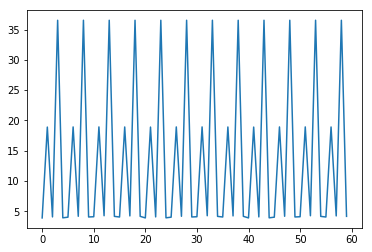

In [50]:
plt.plot(list_score)

In [51]:
pred_test_y = np.zeros(x_test.shape[0])
pred_test_y.shape

(9914,)

In [52]:
train_set = lgb.Dataset(x_train, y_train, silent=True)
train_set

In [53]:
model = lgb.train(best_params, train_set = train_set, num_boost_round=300)

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [54]:
print(model)

In [55]:
pred_test_y = model.predict(x_test, num_iteration = model.best_iteration)

In [56]:
print(pred_test_y)

[10.6257566  11.05444309  4.5039098  ... 53.97993647 20.16864031
  6.77297534]


In [57]:
pred_test_y_proba = model.predict(x_test, num_iteration = model.best_iteration)

In [58]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['fare_amount'] = pred_test_y
submission.to_csv('../output/tuned_LGB.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.625757
1,2015-01-27 13:08:24.0000003,11.054443
2,2011-10-08 11:53:44.0000002,4.503910
3,2012-12-01 21:12:12.0000002,8.945619
4,2012-12-01 21:12:12.0000003,15.654838
5,2012-12-01 21:12:12.0000005,10.782008
6,2011-10-06 12:10:20.0000001,5.124659
7,2011-10-06 12:10:20.0000003,49.388087
8,2011-10-06 12:10:20.0000002,11.142337
9,2014-02-18 15:22:20.0000002,7.012149


In [59]:
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_bin': 511,
 'max_depth': -1,
 'metric': 'rmse',
 'min_child_weight': 3,
 'min_split_gain': 0.01,
 'num_leaves': 31,
 'objective': 'regression',
 'reg_alpha': 0.1,
 'reg_lambda': 2.69,
 'seed': 114,
 'subsample': 0.9,
 'task': 'train',
 'verbose': 0}